<h1>Data exploration</h1>

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
import pickle
import xgboost as xgb
import seaborn as sns
from seaborn import clustermap
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scipy

Loading the train and test set.

In [11]:
train = pd.read_csv('../data/train.txt', sep='\t')
test = pd.read_csv('../data/test.txt', sep='\t')
print(train.shape, test.shape)
print(set(train.columns).difference(test.columns))

(334601, 152) (10842, 151)


In [14]:
test['oldTestset'] = True
test['sample_weight'] = 1.0
train['oldTestset'] = False

In [18]:
data = pd.concat([train, test])
data.shape

//anaconda3/envs/py3_vp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(345443, 153)

In [19]:
label_counts = data['label'].value_counts()
print('The dataset contains {} variants, of which {} ({}%) are benign and {} ({}%) are pathogenic, and has {} features.'
    .format(
        data.shape[0], 
        label_counts['Benign'], 
        round(label_counts['Benign']/data.shape[0]*100, 2), 
        label_counts['Pathogenic'], 
        round(label_counts['Pathogenic']/data.shape[0]*100, 2), 
        data.shape[1]
))


The dataset contains 345443 variants, of which 299341 (86.65%) are benign and 46102 (13.35%) are pathogenic, and has 153 features.


Not all features in the dataset were used for training the model. Some features were only used for plotting afterwards. Load the CAPICE model to extract the used features.

In [20]:
model = pickle.load(open('../model/xgb_weightedSample_randomsearch.pickle.dat', 'rb'))
model_features = set(model.best_estimator_.get_booster().feature_names)
print(len(model_features))

131


//anaconda3/envs/py3_vp/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
//anaconda3/envs/py3_vp/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.19.1 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The features used for the model are all from CADD 1.4. Categorical variables were converted to dummy variables, hence the large number of features. The used features should all be from CADD. Below I copied the features from CADD version 1.4 (https://cadd.gs.washington.edu/static/ReleaseNotes_CADD_v1.4.pdf) and checked the overlap etc. with the features in the train set.

In [21]:
#all_cadd_features contains all features from cadd, cadd_features only contains the features used for training.
all_cadd_features = set([ 'Chrom', 'Pos', 'Ref','Alt','Type','Length', 'Annotype', 'Consequence', 'ConsScore', 'ConsDetail', 'GC','CpG','motifECount', 'MotifEName', 'motifEHIPos','motifEScoreChng','oAA','nAA', 'GeneID', 'FeatureID', 'GeneName', 'CCDS', 'Intron', 'Exon', 'cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Domain','Dst2Splice','Dst2SplType','minDistTSS','minDistTSE','SIFTcat','SIFTval','PolyPhenCat','PolyPhenVal','priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','bStatistic','targetScan','mirSVR-Score','mirSVR-E','mirSVR-Aln','cHmmTssA','cHmmTssAFlnk','cHmmTxFlnk','cHmmTx','cHmmTxWk','cHmmEnhG','cHmmEnh','cHmmZnfRpts','cHmmHet','cHmmTssBiv','cHmmBivFlnk','cHmmEnhBiv','cHmmReprPC','cHmmReprPCWk','cHmmQuies','GerpRS','GerpRSpval','GerpN','GerpS','TFBS','TFBSPeaks','TFBSPeaksMax','tOverlapMotifs','motifDist','Segway','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncExp','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig','EncOCmycSig','Grantham','Dist2Mutation','Freq100bp','Rare100bp','Sngl100bp','Freq1000bp','Rare1000bp','Sngl1000bp','Freq10000bp','Rare10000bp','Sngl10000bp','dbscSNV-ada_score','dbscSNV-rf_score','RawScore','PHRED'])
cadd_features = set(['Ref', 'Alt', 'Type', 'Length', 'Consequence', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'oAA', 'nAA', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Domain', 'Dst2Splice', 'Dst2SplType', 'minDistTSS', 'minDistTSE', 'SIFTcat', 'SIFTval', 'PolyPhenCat', 'PolyPhenVal', 'priPhCons', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'cHmmTssA', 'cHmmTssAFlnk', 'cHmmTxFlnk', 'cHmmTx', 'cHmmTxWk', 'cHmmEnhG', 'cHmmEnh', 'cHmmZnfRpts', 'cHmmHet', 'cHmmTssBiv', 'cHmmBivFlnk', 'cHmmEnhBiv', 'cHmmReprPC', 'cHmmReprPCWk', 'cHmmQuies', 'GerpRS', 'GerpRSpval', 'GerpN', 'GerpS', 'TFBS', 'TFBSPeaks', 'TFBSPeaksMax', 'tOverlapMotifs', 'motifDist', 'Segway', 'EncH3K27Ac', 'EncH3K4Me1', 'EncH3K4Me3', 'EncExp', 'EncNucleo', 'EncOCC', 'EncOCCombPVal', 'EncOCDNasePVal', 'EncOCFairePVal', 'EncOCpolIIPVal', 'EncOCctcfPVal', 'EncOCmycPVal', 'EncOCDNaseSig', 'EncOCFaireSig', 'EncOCpolIISig', 'EncOCctcfSig', 'EncOCmycSig', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score','dbscSNV-rf_score', 'RawScore', 'PHRED'])

#all_cadd_features = set(['Chrom', 'Pos', 'Ref','Anc', 'Alt','Type','Length','isTv','isDerived', 'AnnoType', 'Consequence','ConsScore', 'ConsDetail', 'GC','CpG','mapAbility20bp', 'mapAbility35bp', 'scoreSegDup', 'priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','GerpN','GerpS','GerpRS','GerpRSpval','bStatistic','EncExp','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig', 'EncOCmycSig','Segway','tOverlapMotifs','motifDist','motifECount','motifEName','motifEHIPos','motifEScoreChng','TFBS','TFBSPeaks','TFBSPeaksMax','isKnownVariant','ESP_AF','ESP_AFR','ESP_EUR','TG_AF','TG_ASN','TG_AMR','TG_AFR','TG_EUR','minDistTSS','minDistTSE','GeneID','FeatureID','CCDS','GeneName','cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Dst2Splice','Dst2SplType','Exon','Intron','oAA','nAA','Grantham','PolyPhenCat','PolyPhenVal','SIFTcat','SIFTval'])
#cadd_features = set(['Ref', 'Alt', 'Type', 'Length', 'isTv','Consequence','GC','CpG','priPhCons','mamPhCons','verPhCons','priPhyloP','mamPhyloP','verPhyloP','GerpN','GerpS','GerpRS','GerpRSpval','bStatistic','EncExp','EncH3K27Ac','EncH3K4Me1','EncH3K4Me3','EncNucleo','EncOCC','EncOCCombPVal','EncOCDNasePVal','EncOCFairePVal','EncOCpolIIPVal','EncOCctcfPVal','EncOCmycPVal','EncOCDNaseSig','EncOCFaireSig','EncOCpolIISig','EncOCctcfSig', 'EncOCmycSig','Segway','tOverlapMotifs','motifDist','motifECount','motifEName','motifEHIPos','motifEScoreChng','TFBS','TFBSPeaks','TFBSPeaksMax','minDistTSS','minDistTSE','cDNApos','relcDNApos','CDSpos','relCDSpos','protPos','relProtPos','Dst2Splice','Dst2SplType','oAA','nAA','Grantham','PolyPhenCat','PolyPhenVal','SIFTcat','SIFTval'])
print('CADD 1.4 contains', len(all_cadd_features), 'features.', len(cadd_features), 'were used for training the CADD model.', len(all_cadd_features)-len(cadd_features), 'were not used.')
print('Features from CADD that were not used for CADD training:', list(all_cadd_features.difference(cadd_features)))
print('\n')

#Were all CADD features used for training CAPICE?
#check intersection cadd_features with model_features which are the numerical features. 
numerical_features_cadd = cadd_features.intersection(model_features)
print(len(numerical_features_cadd), 'features from CADD overlap with the features used for training CAPICE. That means there are', len(cadd_features)-len(numerical_features_cadd), 'left that should be the categorical variables converted to dummy variables.')
#12 variables left that should be the dummy vars.

print('\n')
vars_not_in_model = cadd_features.difference(numerical_features_cadd)
print('The', len(vars_not_in_model), 'features from CADD that are not in the model features:', list(vars_not_in_model), '\n')
print('Are these the features that were converted to dummy variables?')

print('\nThe features from the model that were not in CADD:')
model_vars_not_in_cadd = model_features.difference(cadd_features)
#get difference model_feat - cadd_feat
print(model_vars_not_in_cadd)

print('\nCleaned up (dummy variables summarized as the original feature):')
cleanedup = set(list(map(lambda x: x.split('_')[0], model_vars_not_in_cadd)))
print(cleanedup)

print('\n', len(vars_not_in_model.intersection(cleanedup)), 'variables from CADD that were converted to dummy variables in the model:')
categorical_features_cadd = vars_not_in_model.intersection(cleanedup)
print(categorical_features_cadd)

features_not_in_cadd = cleanedup.difference(vars_not_in_model)
print('\n', len(features_not_in_cadd), 'features from the model not in CADD:')
print(features_not_in_cadd)

print('\n')
all_features_model = list(numerical_features_cadd.union(categorical_features_cadd).union(features_not_in_cadd))
print('Summary:', len(all_features_model), 'features were used for training the CAPICE model. ')
print(len(numerical_features_cadd), 'numerical features from CADD,')
print(len(categorical_features_cadd), 'categorical features from CADD,')
print(len(features_not_in_cadd), 'features not from CADD.')
features_not_in_model = cadd_features.difference(all_features_model)
print(len(features_not_in_model), 'features from CADD not in model:')
print(features_not_in_model)

CADD 1.4 contains 107 features. 95 were used for training the CADD model. 12 were not used.
Features from CADD that were not used for CADD training: ['GeneName', 'Chrom', 'GeneID', 'MotifEName', 'Pos', 'Intron', 'FeatureID', 'Annotype', 'ConsScore', 'Exon', 'ConsDetail', 'CCDS']


82 features from CADD overlap with the features used for training CAPICE. That means there are 13 left that should be the categorical variables converted to dummy variables.


The 13 features from CADD that are not in the model features: ['PolyPhenCat', 'Alt', 'Consequence', 'Domain', 'Ref', 'Type', 'SIFTcat', 'PHRED', 'RawScore', 'Dst2SplType', 'oAA', 'nAA', 'Segway'] 

Are these the features that were converted to dummy variables?

The features from the model that were not in CADD:
{'Dst2SplType_DONOR', 'Ref_other', 'oAA_L', 'SIFTcat_tolerated', 'oAA_A', 'Segway_GE0', 'Segway_R5', 'Type_DEL', 'Domain_other', 'Domain_hmmpanther', 'SIFTcat_deleterious', 'Ref_T', 'nAA_other', 'PolyPhenCat_probably_damaging', '

There are a lot of features in the data. What do they look like?

In [22]:
#some chromosome values are integers, some are strings. Convert everything to string for consistency. 
data['#Chrom'] = data['#Chrom'].apply(lambda x: str(x))

COLUMN 0 : #Chrom
Nr of values: 24
Type of column: object
2     41355
1     35848
17    26010
9     20377
14    18017
16    16334
11    16270
12    15809
5     14980
19    14869
X     14768
3     14755
4     12673
6     12648
7     12517
10    10486
15     9749
8      8882
13     7847
22     6434
18     6200
20     6071
21     2532
Y        12
Name: #Chrom, dtype: int64


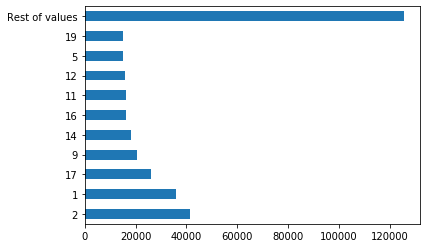




COLUMN 1 : Allergy/Immunology/Infectious
Nr of values: 2
Type of column: bool
False    317394
True      28049
Name: Allergy/Immunology/Infectious, dtype: int64


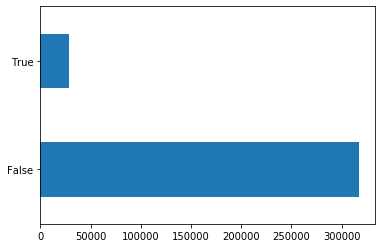




COLUMN 2 : Alt
Nr of values: 3415
Type of column: object
T                                                                        100800
A                                                                         98864
C                                                                         67116
G                                                                         66176
AA                                                                          791
                                                                          ...  
CTCTCTAATCTATTTTCTATACAGCGACCATAGTCGATCTTTTAAAAA                              1
TCGCCG                                                                        1
GGATCCACCCCAATGATCTGCAGAGGGCGCGGCTTCAGGGCTCAAGCCCAGCAAAAGCCCCACCTGGAT         1
ACATGTTTG                                                                     1
GAGCCTGGGAAGTCAAGGCTGCAGTGAGCCTTGATCCTATCACTGCACTCCCA                         1
Name: Alt, Length: 3415, dtype: int64


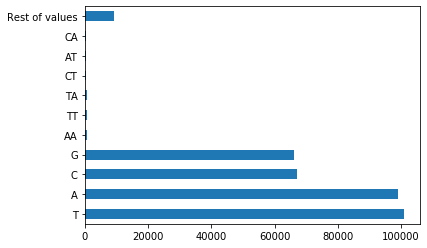




COLUMN 3 : AnnoType
Nr of values: 5
Type of column: object
CodingTranscript       240545
Transcript              70866
Intergenic              25976
RegulatoryFeature        6746
NonCodingTranscript      1310
Name: AnnoType, dtype: int64


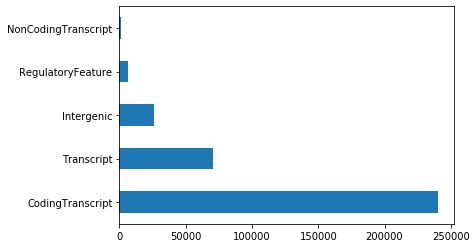




COLUMN 4 : Audiologic/Otolaryngologic
Nr of values: 2
Type of column: bool
False    320633
True      24810
Name: Audiologic/Otolaryngologic, dtype: int64


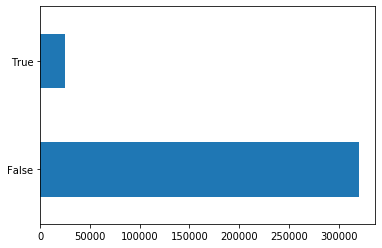




COLUMN 5 : Biochemical
Nr of values: 2
Type of column: bool
False    328377
True      17066
Name: Biochemical, dtype: int64


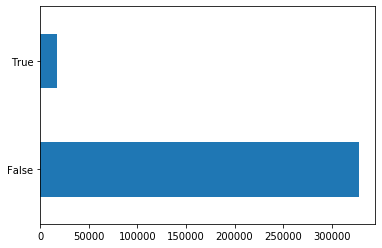




COLUMN 6 : CCDS
Nr of values: 8236
Type of column: object
CCDS59435.1    13966
CCDS9761.2      6666
CCDS9344.1      3601
CCDS48036.1     3262
CCDS11456.2     2749
               ...  
CCDS33679.1        1
CCDS9686.1         1
CCDS13443.1        1
CCDS170.1          1
CCDS63609.1        1
Name: CCDS, Length: 8236, dtype: int64


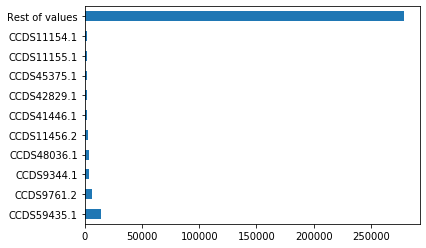




COLUMN 7 : CDSpos
Nr of values: 26406
Type of column: float64
33.0       138
114.0      133
330.0      127
162.0      126
171.0      126
          ... 
44331.0      1
11914.0      1
95309.0      1
95300.0      1
65531.0      1
Name: CDSpos, Length: 26406, dtype: int64


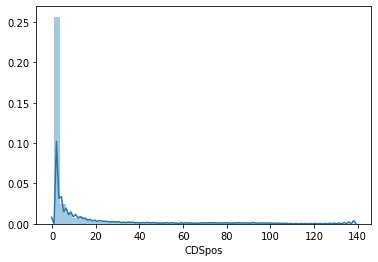




COLUMN 8 : Cardiovascular
Nr of values: 2
Type of column: bool
False    274000
True      71443
Name: Cardiovascular, dtype: int64


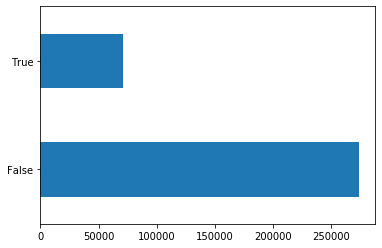




COLUMN 9 : ConsDetail
Nr of values: 94
Type of column: object
missense                                              126067
synonymous                                             67563
intron                                                 42992
frameshift                                             20889
downstream                                             16502
                                                       ...  
intron,5_prime_UTR,splice_acceptor,coding_sequence         1
stop_lost,splice                                           1
stop_retained,inframe_deletion                             1
frameshift,NMD,stop_gained                                 1
stop_retained,frameshift                                   1
Name: ConsDetail, Length: 94, dtype: int64


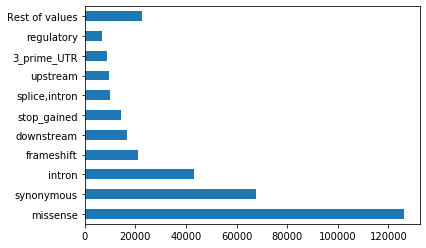




COLUMN 10 : ConsScore
Nr of values: 9
Type of column: float64
7.0    152459
5.0     80746
2.0     52922
1.0     25967
8.0     15100
6.0     10114
4.0      6745
3.0      1380
0.0         9
Name: ConsScore, dtype: int64


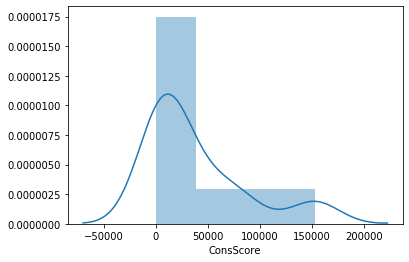




COLUMN 11 : Consequence
Nr of values: 17
Type of column: object
NON_SYNONYMOUS      130522
SYNONYMOUS           67633
INTRONIC             44205
FRAME_SHIFT          21860
DOWNSTREAM           16502
STOP_GAINED          15100
SPLICE_SITE          11818
UPSTREAM              9465
3PRIME_UTR            8717
REGULATORY            6745
CANONICAL_SPLICE      6555
INFRAME               3559
5PRIME_UTR            1380
NONCODING_CHANGE      1292
STOP_LOST               77
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64


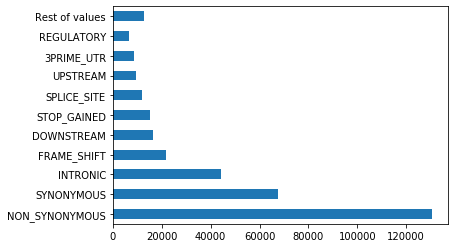




COLUMN 12 : CpG
Nr of values: 920
Type of column: float64
0.013333    52749
0.026667    49328
0.000000    39830
0.040000    38639
0.053333    30464
            ...  
0.010309        1
0.131868        1
0.325359        1
0.325581        1
0.196319        1
Name: CpG, Length: 920, dtype: int64


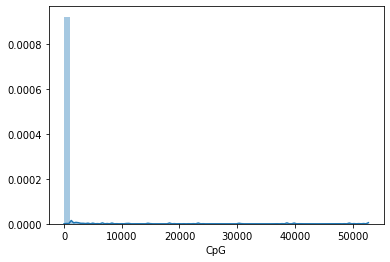




COLUMN 13 : Craniofacial
Nr of values: 2
Type of column: bool
False    294554
True      50889
Name: Craniofacial, dtype: int64


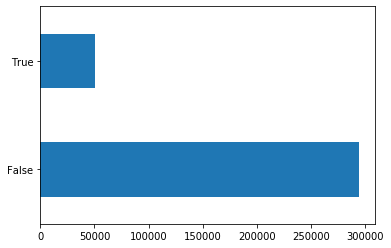




COLUMN 14 : Dental
Nr of values: 2
Type of column: bool
False    334917
True      10526
Name: Dental, dtype: int64


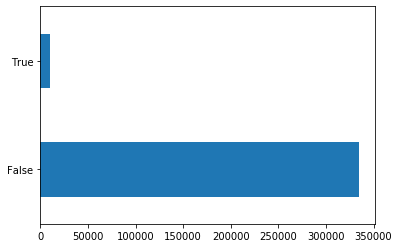




COLUMN 15 : Dermatologic
Nr of values: 2
Type of column: bool
False    298052
True      47391
Name: Dermatologic, dtype: int64


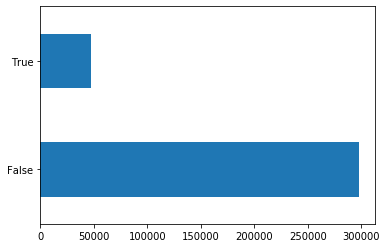




COLUMN 16 : Dist2Mutation
Nr of values: 537
Type of column: float64
15.0     8004
12.0     7959
9.0      7869
14.0     7722
17.0     7682
         ... 
623.0       1
406.0       1
619.0       1
618.0       1
659.0       1
Name: Dist2Mutation, Length: 537, dtype: int64


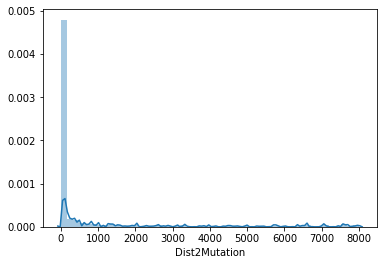




COLUMN 17 : Domain
Nr of values: 6
Type of column: object
ndomain       147997
hmmpanther     52201
lcompl         21762
ncoils         11527
sigp            1214
other            120
Name: Domain, dtype: int64


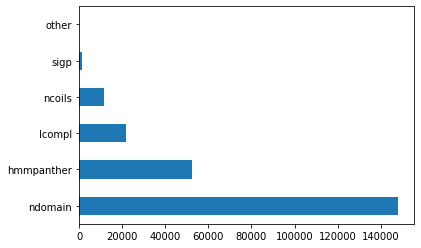




COLUMN 18 : Dst2SplType
Nr of values: 2
Type of column: object
ACCEPTOR    44198
DONOR       42788
Name: Dst2SplType, dtype: int64


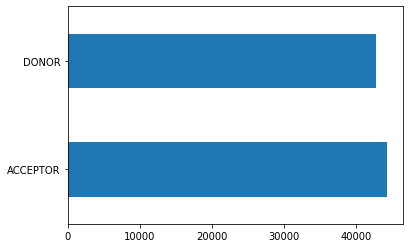




COLUMN 19 : Dst2Splice
Nr of values: 40
Type of column: float64
-1.0     4253
 1.0     2958
 13.0    2635
 3.0     2603
 6.0     2596
 18.0    2594
 12.0    2594
 19.0    2593
 10.0    2589
 16.0    2554
 7.0     2502
 15.0    2473
 17.0    2461
 9.0     2450
 8.0     2441
 14.0    2431
 11.0    2402
 4.0     2387
 20.0    2384
-2.0     2366
 5.0     2303
 2.0     2275
-9.0     2063
-10.0    2026
-8.0     1982
-7.0     1932
-5.0     1686
-14.0    1663
-18.0    1659
-4.0     1653
-15.0    1645
-11.0    1635
-13.0    1632
-16.0    1627
-12.0    1591
-6.0     1565
-17.0    1518
-20.0    1503
-19.0    1490
-3.0     1272
Name: Dst2Splice, dtype: int64


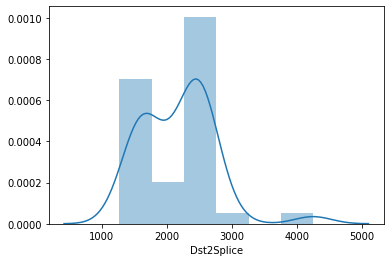




COLUMN 20 : EncExp
Nr of values: 27236
Type of column: float64
0.841077       3035
1.682150       2231
0.444104       2076
2.523230       1872
0.888208       1666
               ... 
2434.740000       1
5738.160000       1
2880.690000       1
2948.660000       1
1531.250000       1
Name: EncExp, Length: 27236, dtype: int64


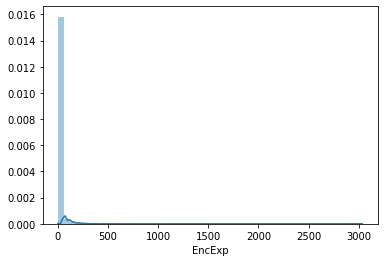




COLUMN 21 : EncH3K27Ac
Nr of values: 4338
Type of column: float64
3.00      35979
2.00      35182
4.00      26101
1.00      17722
5.00      16218
          ...  
207.72        1
103.64        1
145.28        1
92.80         1
127.20        1
Name: EncH3K27Ac, Length: 4338, dtype: int64


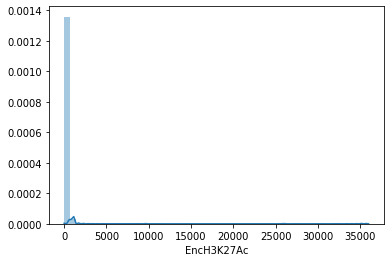




COLUMN 22 : EncH3K4Me1
Nr of values: 1902
Type of column: float64
2.00     45054
3.00     34740
1.00     24001
4.00     20236
5.00     10936
         ...  
62.68        1
58.64        1
61.48        1
60.52        1
62.24        1
Name: EncH3K4Me1, Length: 1902, dtype: int64


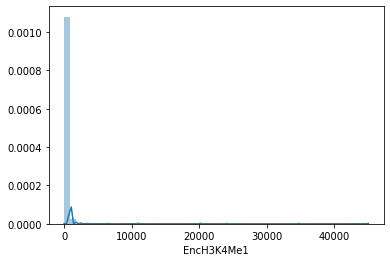




COLUMN 23 : EncH3K4Me3
Nr of values: 6151
Type of column: float64
2.00      57741
3.00      50576
4.00      27168
1.00      21617
5.00      11878
          ...  
181.72        1
261.04        1
53.00         1
407.32        1
428.88        1
Name: EncH3K4Me3, Length: 6151, dtype: int64


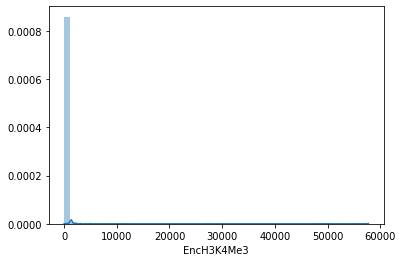




COLUMN 24 : EncNucleo
Nr of values: 139
Type of column: float64
1.2     15773
1.0     15733
1.1     15704
0.9     15472
1.3     15183
        ...  
11.7        1
13.4        1
11.1        1
12.0        1
16.9        1
Name: EncNucleo, Length: 139, dtype: int64


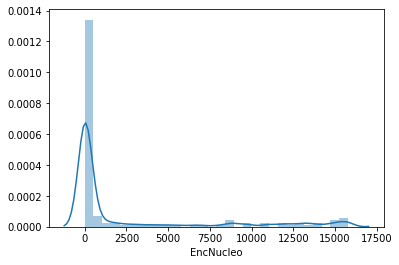




COLUMN 25 : EncOCC
Nr of values: 4
Type of column: float64
2.0    89921
3.0    15417
1.0    12822
4.0     6946
Name: EncOCC, dtype: int64


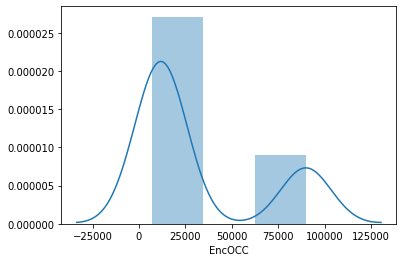




COLUMN 26 : EncOCCombPVal
Nr of values: 1378
Type of column: float64
16.00    14731
14.42     2945
15.18     2653
15.48     1522
15.95     1441
         ...  
13.66        1
11.75        1
14.30        1
11.86        1
14.01        1
Name: EncOCCombPVal, Length: 1378, dtype: int64


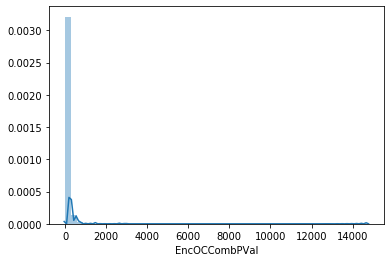




COLUMN 27 : EncOCDNasePVal
Nr of values: 991
Type of column: float64
16.00    23284
0.00     12069
2.98       814
11.80      794
1.93       609
         ...  
0.52         1
9.26         1
5.48         1
5.99         1
6.01         1
Name: EncOCDNasePVal, Length: 991, dtype: int64


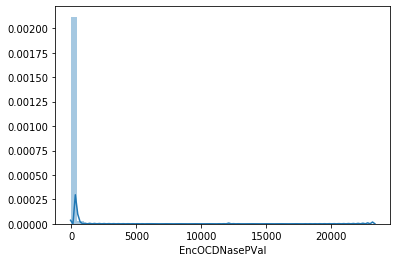




COLUMN 28 : EncOCDNaseSig
Nr of values: 4607
Type of column: float64
0.6610    2163
0.4070     638
1.6873     613
0.3814     529
0.6858     494
          ... 
1.1625       1
0.3016       1
0.5045       1
0.1459       1
1.2779       1
Name: EncOCDNaseSig, Length: 4607, dtype: int64


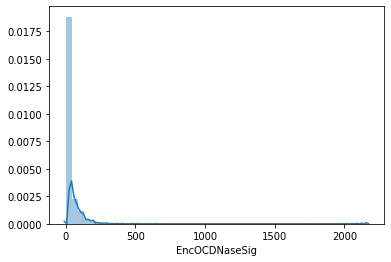




COLUMN 29 : EncOCFairePVal
Nr of values: 832
Type of column: float64
0.00    40593
1.63     2606
0.83     1341
0.78     1238
0.74      898
        ...  
7.08        1
8.61        1
6.70        1
6.44        1
5.32        1
Name: EncOCFairePVal, Length: 832, dtype: int64


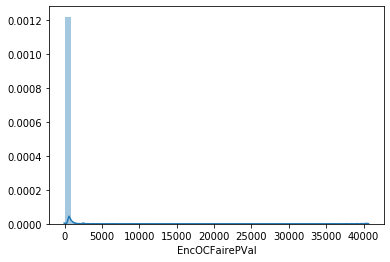




COLUMN 30 : EncOCFaireSig
Nr of values: 689
Type of column: float64
0.0180    2607
0.0113    1503
0.0093    1375
0.0117    1368
0.0095    1224
          ... 
0.0568       1
0.0767       1
0.0701       1
0.0751       1
0.0694       1
Name: EncOCFaireSig, Length: 689, dtype: int64


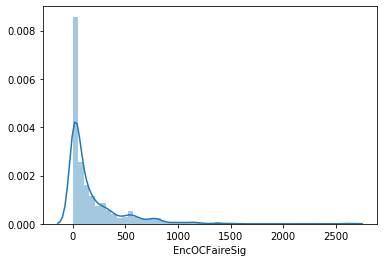




COLUMN 31 : EncOCctcfPVal
Nr of values: 866
Type of column: float64
0.00     58185
16.00    11248
11.00     2202
1.88       847
1.95       731
         ...  
4.78         1
8.18         1
4.51         1
4.60         1
7.01         1
Name: EncOCctcfPVal, Length: 866, dtype: int64


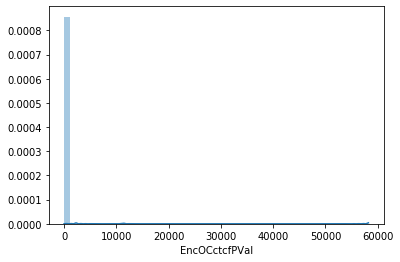




COLUMN 32 : EncOCctcfSig
Nr of values: 5465
Type of column: float64
0.0000    4969
1.8090    2163
0.1899     796
1.3494     613
0.0515     526
          ... 
1.4667       1
0.8619       1
0.7284       1
2.8427       1
2.0018       1
Name: EncOCctcfSig, Length: 5465, dtype: int64


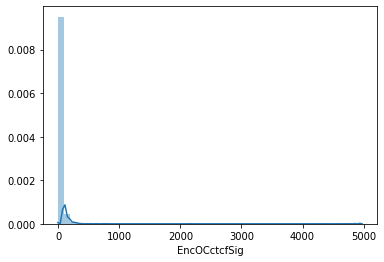




COLUMN 33 : EncOCmycPVal
Nr of values: 788
Type of column: float64
0.00     69035
2.23      2275
3.09      1205
16.00     1051
1.61       693
         ...  
7.71         1
8.55         1
7.69         1
15.10        1
4.38         1
Name: EncOCmycPVal, Length: 788, dtype: int64


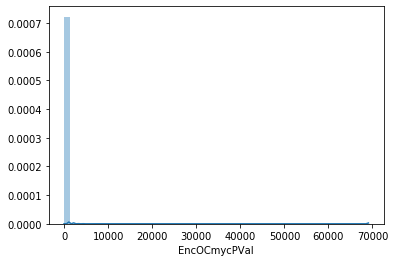




COLUMN 34 : EncOCmycSig
Nr of values: 2432
Type of column: float64
0.0000    30960
0.1351     2156
0.2063     1158
0.0856      552
0.0782      495
          ...  
0.1445        1
0.4320        1
0.1111        1
0.4268        1
0.2884        1
Name: EncOCmycSig, Length: 2432, dtype: int64


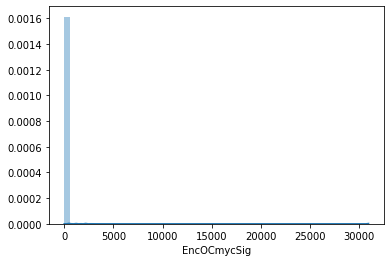




COLUMN 35 : EncOCpolIIPVal
Nr of values: 909
Type of column: float64
0.00     58691
16.00     8484
6.33      2273
4.41       615
2.71       609
         ...  
8.49         1
6.32         1
7.40         1
5.56         1
6.97         1
Name: EncOCpolIIPVal, Length: 909, dtype: int64


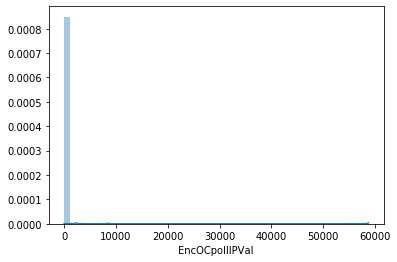




COLUMN 36 : EncOCpolIISig
Nr of values: 3210
Type of column: float64
0.0000    33714
0.1161     2165
0.1154      599
0.0816      546
0.0509      490
          ...  
0.4580        1
0.2987        1
0.3457        1
0.2263        1
0.4424        1
Name: EncOCpolIISig, Length: 3210, dtype: int64


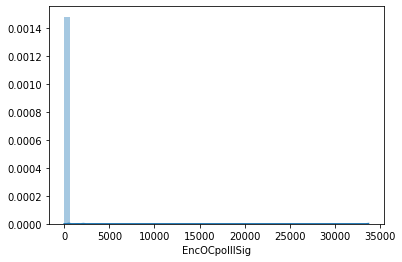




COLUMN 37 : Endocrine
Nr of values: 2
Type of column: bool
False    323828
True      21615
Name: Endocrine, dtype: int64


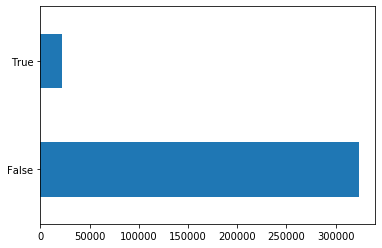




COLUMN 38 : Exon
Nr of values: 4442
Type of column: object
2/2        5134
4/4        3637
3/3        3530
1/1        3217
326/363    2840
           ... 
71/87         1
24/61         1
51/182        1
10/55         1
31/182        1
Name: Exon, Length: 4442, dtype: int64


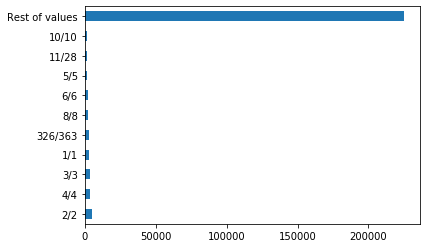




COLUMN 39 : FeatureID
Nr of values: 12058
Type of column: object
ENST00000589042    13966
ENST00000358025     6666
ENST00000544455     3601
ENST00000372739     3262
ENST00000471181     2749
                   ...  
ENSR00000357149        1
ENST00000568149        1
ENSR00000260169        1
ENSR00000317475        1
ENST00000526229        1
Name: FeatureID, Length: 12058, dtype: int64


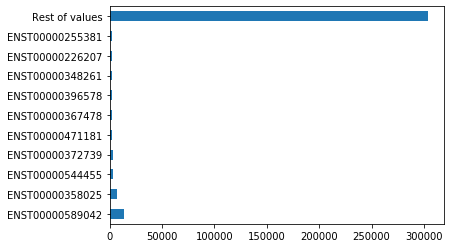




COLUMN 40 : Freq10000bp
Nr of values: 198
Type of column: float64
11.0     13600
13.0     13392
14.0     13187
8.0      13092
12.0     13004
         ...  
564.0        1
454.0        1
558.0        1
631.0        1
141.0        1
Name: Freq10000bp, Length: 198, dtype: int64


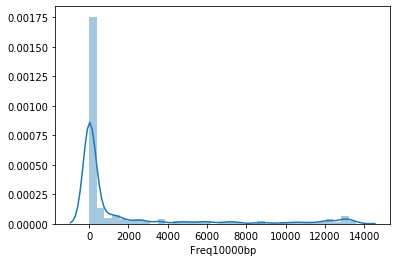




COLUMN 41 : Freq1000bp
Nr of values: 76
Type of column: float64
0.0     91891
1.0     91465
2.0     65159
3.0     39807
4.0     23677
        ...  
46.0        1
97.0        1
54.0        1
78.0        1
83.0        1
Name: Freq1000bp, Length: 76, dtype: int64


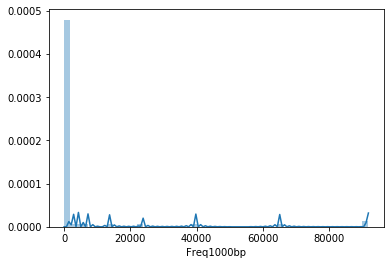




COLUMN 42 : Freq100bp
Nr of values: 23
Type of column: float64
0.0     284022
1.0      48894
2.0       7156
3.0       1008
4.0        235
5.0         42
10.0        40
9.0         35
6.0         23
8.0         22
7.0         13
11.0         9
15.0         9
12.0         7
13.0         6
16.0         6
19.0         4
25.0         3
18.0         2
14.0         2
22.0         2
26.0         1
23.0         1
Name: Freq100bp, dtype: int64


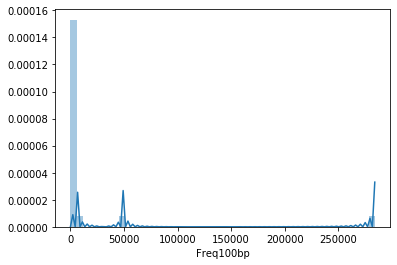




COLUMN 43 : GC
Nr of values: 2167
Type of column: float64
0.423841    6153
0.430464    5987
0.410596    5964
0.437086    5941
0.417219    5908
            ... 
0.192982       1
0.310976       1
0.827586       1
0.815476       1
0.254777       1
Name: GC, Length: 2167, dtype: int64


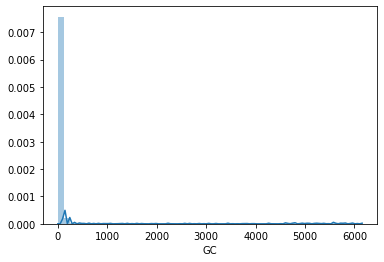




COLUMN 44 : Gastrointestinal
Nr of values: 2
Type of column: bool
False    317297
True      28146
Name: Gastrointestinal, dtype: int64


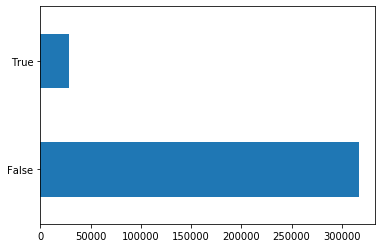




COLUMN 45 : GeneID
Nr of values: 9936
Type of column: object
ENSG00000155657    13966
ENSG00000054654     6666
ENSG00000139618     3601
ENSG00000197694     3262
ENSG00000012048     2749
                   ...  
ENSG00000144711        1
ENSG00000206969        1
ENSG00000163064        1
ENSG00000150477        1
ENSG00000063015        1
Name: GeneID, Length: 9936, dtype: int64


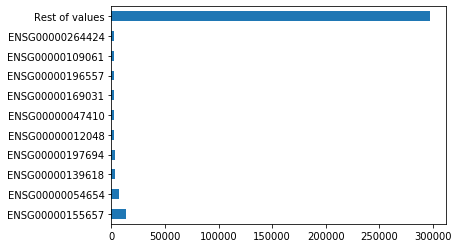




COLUMN 46 : GeneName
Nr of values: 9667
Type of column: object
MIR548N     10384
MIR548AZ     8888
MIR1268A     7743
MYHAS        7083
TTN          4823
            ...  
B4GALT2         1
NRIP1           1
GSDMB           1
CABP1           1
RNASE11         1
Name: GeneName, Length: 9667, dtype: int64


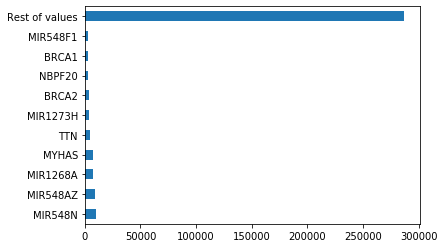




COLUMN 47 : General
Nr of values: 2
Type of column: bool
False    345043
True        400
Name: General, dtype: int64


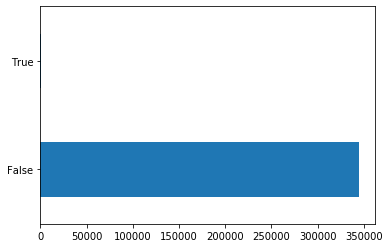




COLUMN 48 : Genitourinary
Nr of values: 2
Type of column: bool
False    330238
True      15205
Name: Genitourinary, dtype: int64


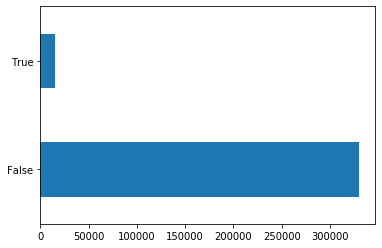




COLUMN 49 : GerpN
Nr of values: 1146
Type of column: float64
6.170    3158
5.650    2789
5.870    2665
5.740    2536
5.600    2531
         ... 
0.655       1
0.551       1
0.705       1
0.780       1
0.660       1
Name: GerpN, Length: 1146, dtype: int64


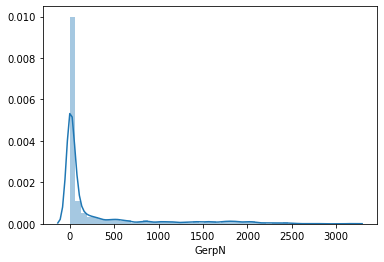




COLUMN 50 : GerpRS
Nr of values: 15257
Type of column: float64
3134.0    790
1917.4    725
3477.7    612
2677.3    596
1872.0    518
         ... 
1266.1      1
1732.1      1
2415.0      1
7935.2      1
2237.2      1
Name: GerpRS, Length: 15257, dtype: int64


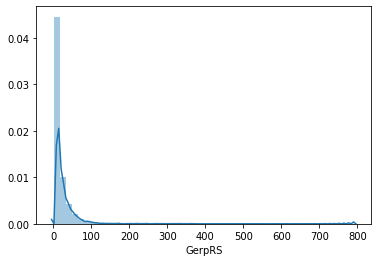




COLUMN 51 : GerpRSpval
Nr of values: 42518
Type of column: float64
0.000000e+00     44294
2.146100e-131      725
1.163960e-156      622
3.097140e-78       518
2.676060e-103      453
                 ...  
5.374830e-98         1
1.939220e-13         1
1.352000e-08         1
2.255780e-71         1
2.243360e-51         1
Name: GerpRSpval, Length: 42518, dtype: int64


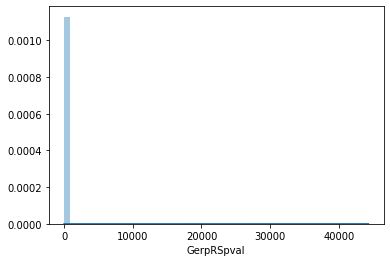




COLUMN 52 : GerpS
Nr of values: 5130
Type of column: float64
 0.00000    1452
 6.17000    1272
 5.87000    1147
 5.65000    1107
 5.74000    1074
            ... 
 0.00556       1
-0.09710       1
 0.00716       1
-0.00792       1
-0.00733       1
Name: GerpS, Length: 5130, dtype: int64


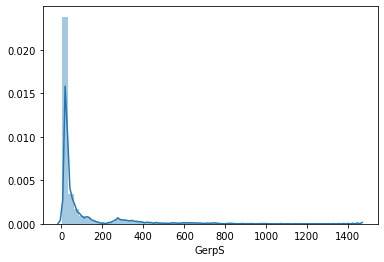




COLUMN 53 : Grantham
Nr of values: 81
Type of column: float64
29.0     10934
56.0      7470
58.0      7227
98.0      6860
64.0      4929
         ...  
59.0         1
153.0        1
195.0        1
158.0        1
124.0        1
Name: Grantham, Length: 81, dtype: int64


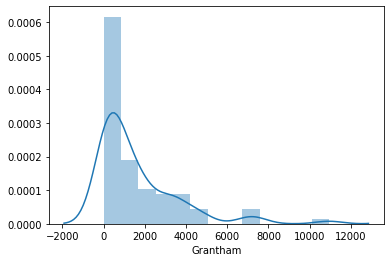




COLUMN 54 : Hematologic
Nr of values: 2
Type of column: bool
False    318835
True      26608
Name: Hematologic, dtype: int64


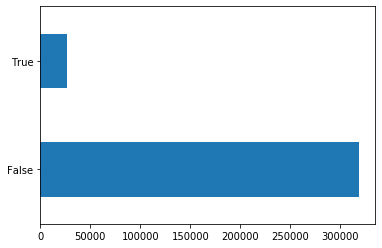




COLUMN 55 : Intron
Nr of values: 3500
Type of column: object
2/3      474
8/8      438
10/10    300
1/1      295
3/3      288
        ... 
4/54       1
18/68      1
37/62      1
75/84      1
57/84      1
Name: Intron, Length: 3500, dtype: int64


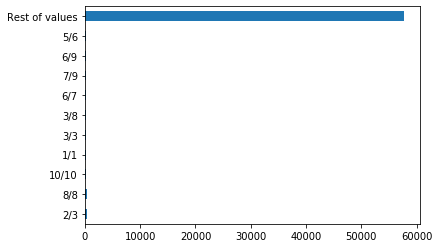




COLUMN 56 : Length
Nr of values: 111
Type of column: float64
0.0      305169
1.0       19353
2.0        6565
3.0        3385
4.0        3136
          ...  
83.0          1
136.0         1
104.0         1
95.0          1
112.0         1
Name: Length, Length: 111, dtype: int64


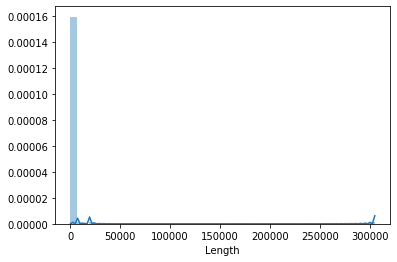




COLUMN 57 : Musculoskeletal
Nr of values: 2
Type of column: bool
False    259251
True      86192
Name: Musculoskeletal, dtype: int64


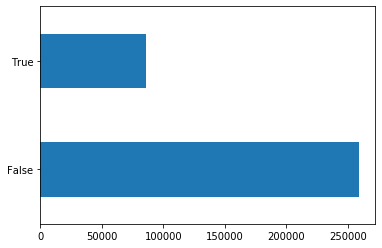




COLUMN 58 : Neurologic
Nr of values: 2
Type of column: bool
False    231684
True     113759
Name: Neurologic, dtype: int64


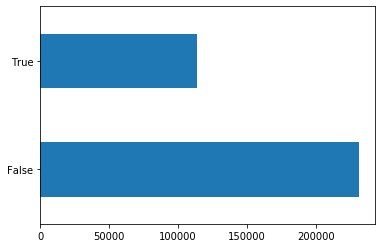




COLUMN 59 : Obstetric
Nr of values: 2
Type of column: bool
False    341718
True       3725
Name: Obstetric, dtype: int64


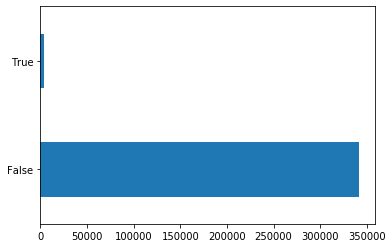




COLUMN 60 : Oncologic
Nr of values: 2
Type of column: bool
False    302078
True      43365
Name: Oncologic, dtype: int64


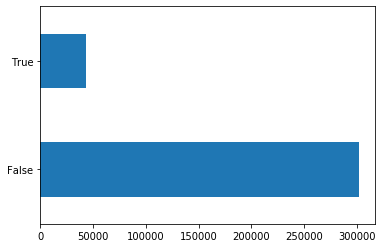




COLUMN 61 : Ophthalmologic
Nr of values: 2
Type of column: bool
False    292120
True      53323
Name: Ophthalmologic, dtype: int64


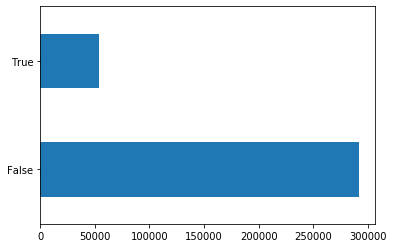




COLUMN 62 : PHRED
Nr of values: 11146
Type of column: float64
35.000    8726
34.000    7352
33.000    5618
32.000    4858
31.000    2666
          ... 
8.594        1
2.430        1
6.695        1
81.000       1
6.751        1
Name: PHRED, Length: 11146, dtype: int64


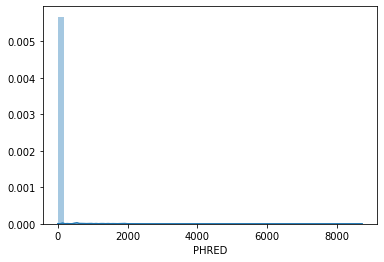




COLUMN 63 : PolyPhenCat
Nr of values: 4
Type of column: object
benign               63706
probably_damaging    39178
possibly_damaging    20067
unknown                186
Name: PolyPhenCat, dtype: int64


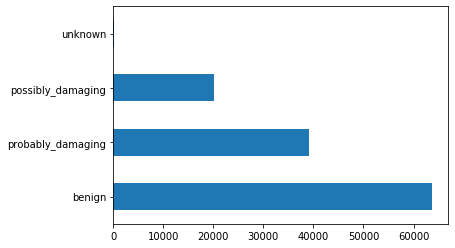




COLUMN 64 : PolyPhenVal
Nr of values: 988
Type of column: float64
0.000    11586
1.000     7045
0.999     5192
0.003     4275
0.001     3427
         ...  
0.363       14
0.555       13
0.337       12
0.538       10
0.485       10
Name: PolyPhenVal, Length: 988, dtype: int64


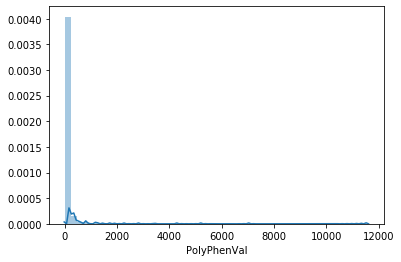




COLUMN 65 : Pos
Nr of values: 326962
Type of column: int64
35083508     17
38627152     14
47641559     12
35083509     12
92537353     12
             ..
179477498     1
201333419     1
52437676      1
40457241      1
57147392      1
Name: Pos, Length: 326962, dtype: int64


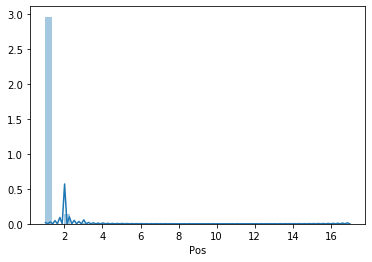




COLUMN 66 : Pulmonary
Nr of values: 2
Type of column: bool
False    334630
True      10813
Name: Pulmonary, dtype: int64


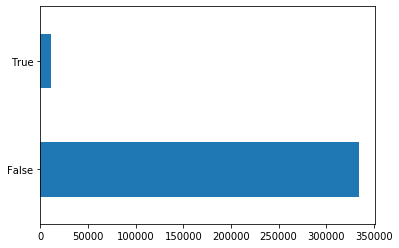




COLUMN 67 : Rare10000bp
Nr of values: 244
Type of column: float64
63.0     8391
56.0     8146
62.0     8010
60.0     7972
55.0     7945
         ... 
280.0       1
213.0       1
195.0       1
277.0       1
270.0       1
Name: Rare10000bp, Length: 244, dtype: int64


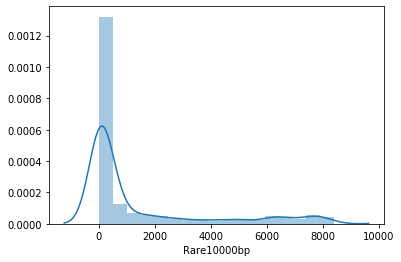




COLUMN 68 : Rare1000bp
Nr of values: 57
Type of column: float64
5.0     46134
4.0     44728
6.0     42265
3.0     37612
7.0     35659
8.0     27283
2.0     24556
9.0     21460
10.0    15684
1.0     12221
11.0    10582
12.0     6857
13.0     4668
14.0     3235
0.0      2873
15.0     2162
16.0     1493
17.0     1220
18.0      875
19.0      596
20.0      534
21.0      320
22.0      242
34.0      236
23.0      177
24.0      170
25.0      152
33.0      143
26.0       97
27.0       90
29.0       56
30.0       40
28.0       39
31.0       24
32.0       18
53.0       12
35.0        7
41.0        4
38.0        3
71.0        2
55.0        2
36.0        2
65.0        1
74.0        1
40.0        1
44.0        1
61.0        1
70.0        1
54.0        1
72.0        1
73.0        1
37.0        1
52.0        1
39.0        1
79.0        1
64.0        1
45.0        1
Name: Rare1000bp, dtype: int64


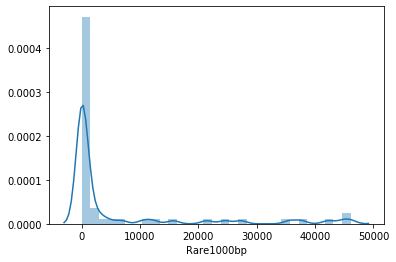




COLUMN 69 : Rare100bp
Nr of values: 18
Type of column: float64
0.0     186989
1.0     105650
2.0      35349
3.0       9957
4.0       2375
5.0        656
6.0        239
7.0        153
10.0        80
8.0         31
12.0        29
9.0         15
11.0        10
16.0         3
22.0         2
13.0         2
18.0         1
14.0         1
Name: Rare100bp, dtype: int64


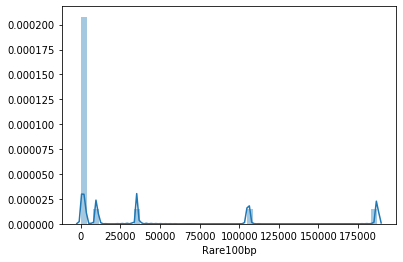




COLUMN 70 : RawScore
Nr of values: 333899
Type of column: float64
 0.079269    4
 0.414479    4
-0.243369    4
 2.331621    4
 0.438020    4
            ..
 1.306922    1
 4.237931    1
 3.588252    1
 3.404678    1
 2.169072    1
Name: RawScore, Length: 333899, dtype: int64


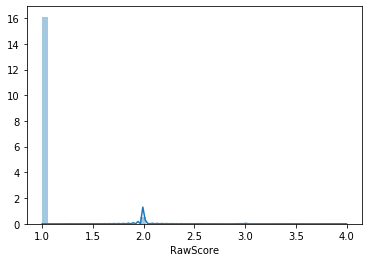




COLUMN 71 : Ref
Nr of values: 5614
Type of column: object
C                104643
G                103098
A                 54846
T                 54089
CT                 1429
                  ...  
AGCTGCATCC            1
CCCCATGGCA            1
TACCAATGTAGAA         1
CAACCT                1
TACACTC               1
Name: Ref, Length: 5614, dtype: int64


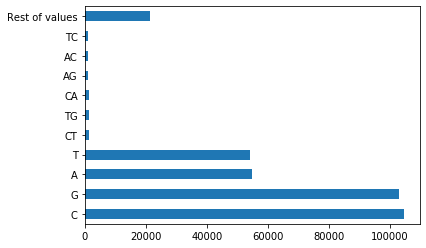




COLUMN 72 : Renal
Nr of values: 2
Type of column: bool
False    313728
True      31715
Name: Renal, dtype: int64


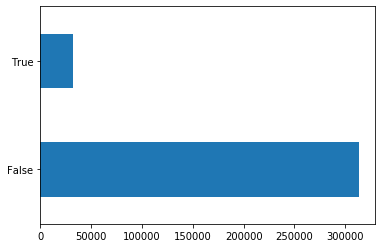




COLUMN 73 : SIFTcat
Nr of values: 2
Type of column: object
deleterious    61572
tolerated      59933
Name: SIFTcat, dtype: int64


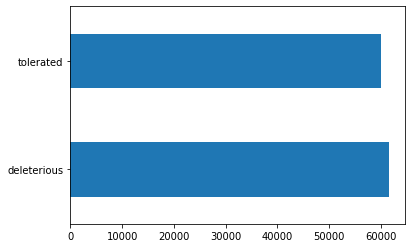




COLUMN 74 : SIFTval
Nr of values: 101
Type of column: float64
0.00    34128
0.01    10743
0.02     6463
0.03     4776
1.00     4684
        ...  
0.93       86
0.95       83
0.97       83
0.98       82
0.99       78
Name: SIFTval, Length: 101, dtype: int64


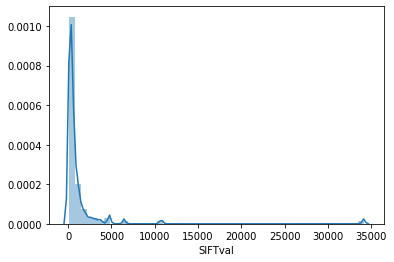




COLUMN 75 : Segway
Nr of values: 25
Type of column: object
TF2        36837
TF0        34281
GE0        33422
GE1        27879
R5         27816
GE2        24513
L1         14100
R1         13499
TF1        12749
R0         11693
L0         11136
R3         11040
F0         10589
F1         10444
GM1         9990
TSS         9694
R2          9297
D           8400
GS          7571
GM0         3843
R4          3787
H3K9me1     3366
E/GM        3112
C1          2822
C0          1558
Name: Segway, dtype: int64


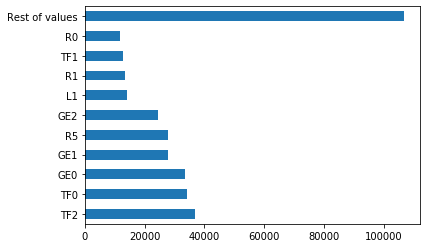




COLUMN 76 : Sngl10000bp
Nr of values: 1482
Type of column: float64
538.0     2445
556.0     2245
558.0     2234
557.0     2227
536.0     2219
          ... 
32.0         1
154.0        1
1700.0       1
1425.0       1
1362.0       1
Name: Sngl10000bp, Length: 1482, dtype: int64


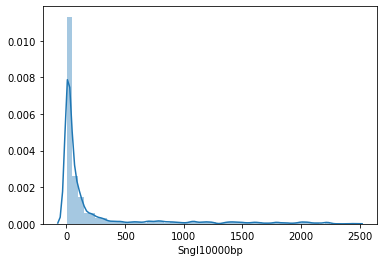




COLUMN 77 : Sngl1000bp
Nr of values: 242
Type of column: float64
56.0     10608
54.0     10573
55.0     10551
57.0     10431
53.0     10206
         ...  
239.0        1
242.0        1
200.0        1
269.0        1
227.0        1
Name: Sngl1000bp, Length: 242, dtype: int64


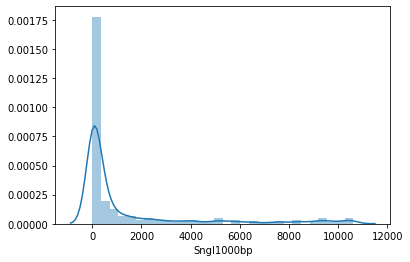




COLUMN 78 : Sngl100bp
Nr of values: 72
Type of column: float64
5.0     43573
6.0     42423
4.0     40932
7.0     37691
3.0     32046
        ...  
38.0        1
50.0        1
44.0        1
45.0        1
46.0        1
Name: Sngl100bp, Length: 72, dtype: int64


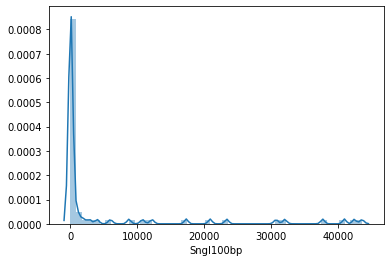




COLUMN 79 : Stars
Nr of values: 4
Type of column: float64
1.0    92914
2.0    23382
3.0     5693
4.0       23
Name: Stars, dtype: int64


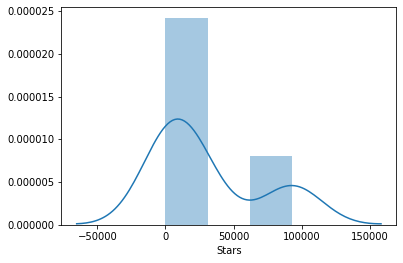




COLUMN 80 : TFBS
Nr of values: 109
Type of column: float64
1.0      26206
2.0      12147
3.0       5695
4.0       3529
5.0       2354
         ...  
112.0        2
105.0        2
109.0        2
106.0        1
118.0        1
Name: TFBS, Length: 109, dtype: int64


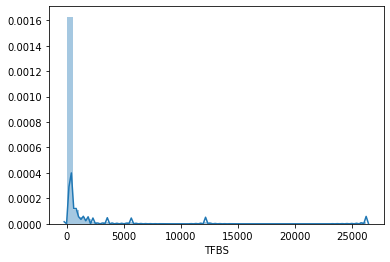




COLUMN 81 : TFBSPeaks
Nr of values: 223
Type of column: float64
1.0      22553
2.0      10073
3.0       5772
4.0       4178
5.0       3109
         ...  
226.0        1
238.0        1
240.0        1
155.0        1
209.0        1
Name: TFBSPeaks, Length: 223, dtype: int64


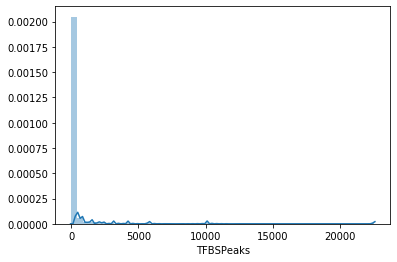




COLUMN 82 : TFBSPeaksMax
Nr of values: 15597
Type of column: float64
574.6504    385
24.1861     216
56.5523     211
352.5565    165
27.0111     165
           ... 
285.4881      1
92.1205       1
146.5194      1
33.8600       1
42.2231       1
Name: TFBSPeaksMax, Length: 15597, dtype: int64


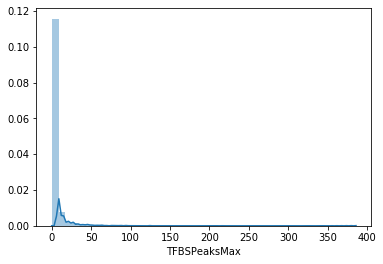




COLUMN 83 : Type
Nr of values: 3
Type of column: object
SNV    305616
DEL     28135
INS     11692
Name: Type, dtype: int64


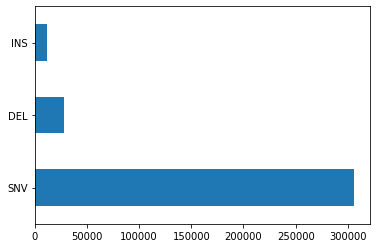




COLUMN 84 : allvalid
Nr of values: 2
Type of column: bool
False    313527
True      31916
Name: allvalid, dtype: int64


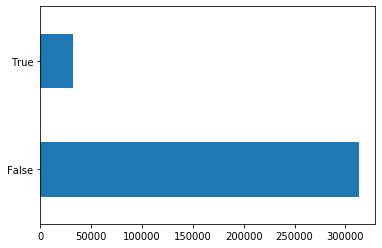




COLUMN 85 : bStatistic
Nr of values: 989
Type of column: float64
0.0      13586
952.0     2476
111.0     2079
259.0     2010
970.0     1870
         ...  
984.0        4
993.0        2
30.0         2
29.0         1
985.0        1
Name: bStatistic, Length: 989, dtype: int64


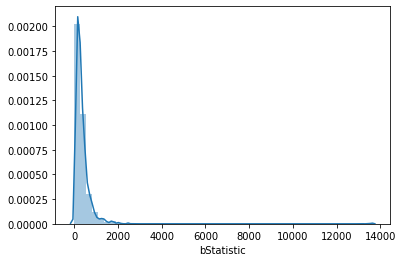




COLUMN 86 : binarized_label
Nr of values: 2
Type of column: int64
0    299341
1     46102
Name: binarized_label, dtype: int64


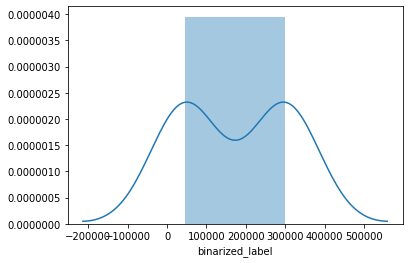




COLUMN 87 : cDNApos
Nr of values: 26898
Type of column: float64
753.0      113
844.0      112
886.0      111
490.0      110
707.0      110
          ... 
12159.0      1
53472.0      1
97279.0      1
97282.0      1
7632.0       1
Name: cDNApos, Length: 26898, dtype: int64


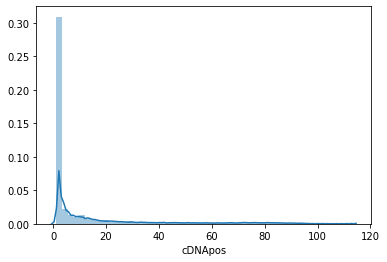




COLUMN 88 : cHmmBivFlnk
Nr of values: 88
Type of column: float64
0.0000    323989
0.0080      5836
0.0160      2151
0.0240      1644
0.0310       972
           ...  
0.0235         1
0.2595         1
0.0120         1
0.2795         1
0.0315         1
Name: cHmmBivFlnk, Length: 88, dtype: int64


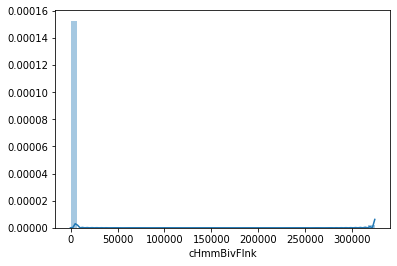




COLUMN 89 : cHmmEnh
Nr of values: 118
Type of column: float64
0.0000    186717
0.0080     48293
0.0160     25262
0.0240     14350
0.0310     10726
           ...  
0.1300         1
0.4055         1
0.2995         1
0.1535         1
0.2795         1
Name: cHmmEnh, Length: 118, dtype: int64


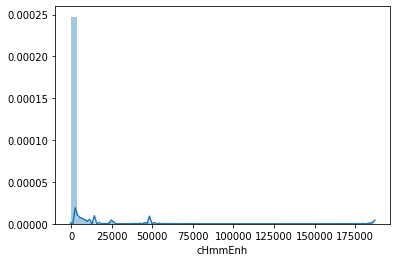




COLUMN 90 : cHmmEnhBiv
Nr of values: 76
Type of column: float64
0.0000    304693
0.0080     15623
0.0160      6123
0.0240      3153
0.0310      2106
           ...  
0.0830         1
0.4250         1
0.0430         1
0.2085         1
0.0985         1
Name: cHmmEnhBiv, Length: 76, dtype: int64


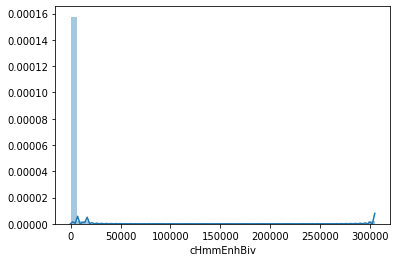




COLUMN 91 : cHmmEnhG
Nr of values: 119
Type of column: float64
0.000    191681
0.008     47119
0.016     26783
0.024     17645
0.031     10040
          ...  
0.591         1
0.287         1
0.240         1
0.114         1
0.122         1
Name: cHmmEnhG, Length: 119, dtype: int64


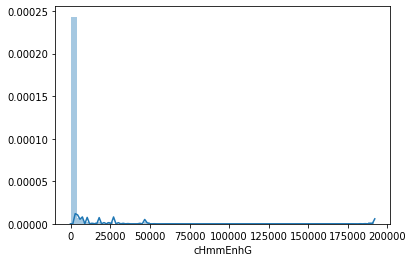




COLUMN 92 : cHmmHet
Nr of values: 107
Type of column: float64
0.0000    267595
0.0080     29886
0.0160     15274
0.0240      8088
0.0310      5010
           ...  
0.7640         1
0.2955         1
0.5670         1
0.0590         1
0.0275         1
Name: cHmmHet, Length: 107, dtype: int64


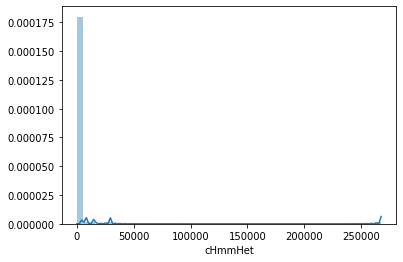




COLUMN 93 : cHmmQuies
Nr of values: 204
Type of column: float64
0.0080    28440
0.0000    28295
0.0160    25533
0.0240    14457
0.0310    10874
          ...  
0.6970        1
0.6260        1
0.7995        1
0.6020        1
0.5700        1
Name: cHmmQuies, Length: 204, dtype: int64


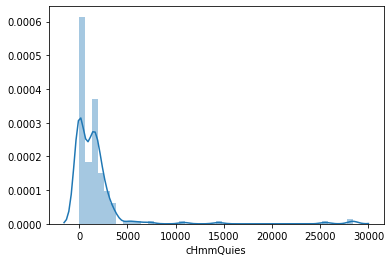




COLUMN 94 : cHmmReprPC
Nr of values: 148
Type of column: float64
0.0000    235919
0.0080     28648
0.0160     15910
0.0240      9335
0.0310      6924
           ...  
0.1105         1
0.3815         1
0.2365         1
0.2045         1
0.2285         1
Name: cHmmReprPC, Length: 148, dtype: int64


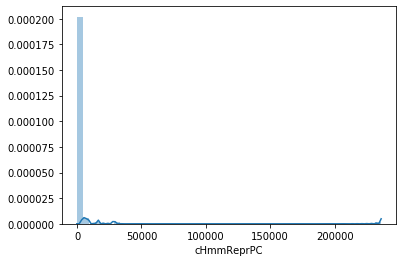




COLUMN 95 : cHmmReprPCWk
Nr of values: 148
Type of column: float64
0.0000    151644
0.0080     34573
0.0160     12594
0.0240     10415
0.0310      8342
           ...  
0.2995         1
0.7720         1
0.2005         1
0.6420         1
0.0200         1
Name: cHmmReprPCWk, Length: 148, dtype: int64


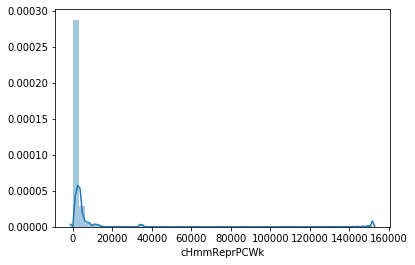




COLUMN 96 : cHmmTssA
Nr of values: 162
Type of column: float64
0.0000    291451
0.0080     14099
0.0160      4589
0.0240      2790
0.0310      2062
           ...  
0.8035         1
0.0315         1
0.2635         1
0.1740         1
0.6730         1
Name: cHmmTssA, Length: 162, dtype: int64


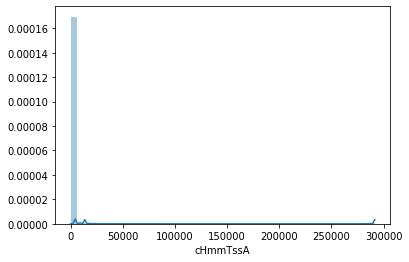




COLUMN 97 : cHmmTssAFlnk
Nr of values: 137
Type of column: float64
0.0000    283236
0.0080     21610
0.0160      9236
0.0240      4650
0.0310      4086
           ...  
0.8030         1
0.8660         1
0.1300         1
0.0275         1
0.0705         1
Name: cHmmTssAFlnk, Length: 137, dtype: int64


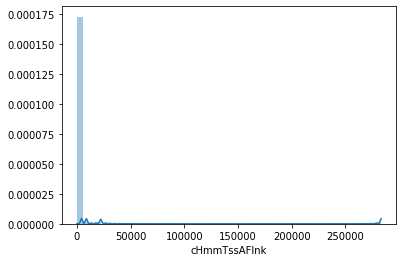




COLUMN 98 : cHmmTssBiv
Nr of values: 84
Type of column: float64
0.000    314294
0.008      9131
0.016      3940
0.024      2066
0.031      1490
          ...  
0.240         1
0.433         1
0.449         1
0.091         1
0.335         1
Name: cHmmTssBiv, Length: 84, dtype: int64


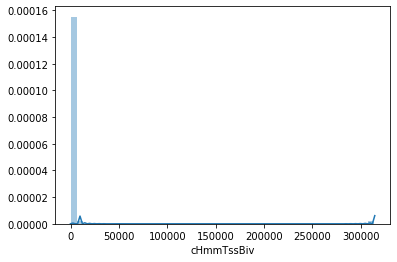




COLUMN 99 : cHmmTx
Nr of values: 256
Type of column: float64
0.0000    78207
0.0080    20125
0.0160    11703
0.0240     7831
0.0310     6466
          ...  
0.5945        1
0.3465        1
0.8940        1
0.4095        1
0.5315        1
Name: cHmmTx, Length: 256, dtype: int64


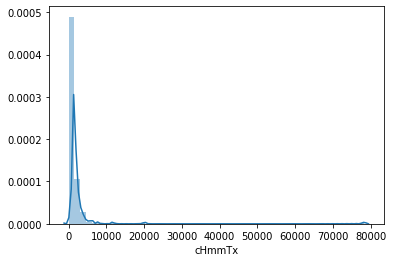




COLUMN 100 : cHmmTxFlnk
Nr of values: 125
Type of column: float64
0.0000    280578
0.0080     28615
0.0160     14235
0.0240      6773
0.0310      3273
           ...  
0.7720         1
0.4880         1
0.0510         1
0.2675         1
0.2950         1
Name: cHmmTxFlnk, Length: 125, dtype: int64


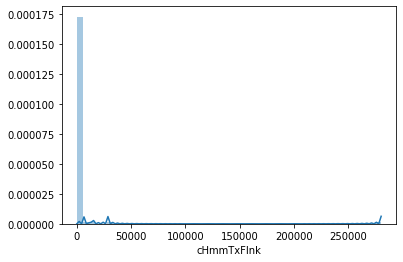




COLUMN 101 : cHmmTxWk
Nr of values: 271
Type of column: float64
0.0000    20522
0.0080    13765
0.0160    11780
0.0240     9771
0.0310     8562
          ...  
0.5515        1
0.7440        1
0.6615        1
0.3350        1
0.8585        1
Name: cHmmTxWk, Length: 271, dtype: int64


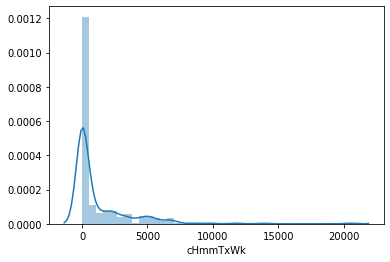




COLUMN 102 : cHmmZnfRpts
Nr of values: 122
Type of column: float64
0.0000    280078
0.0080     34905
0.0160     11534
0.0240      5156
0.0310      2780
           ...  
0.6770         1
0.0865         1
0.9840         1
0.8900         1
0.0275         1
Name: cHmmZnfRpts, Length: 122, dtype: int64


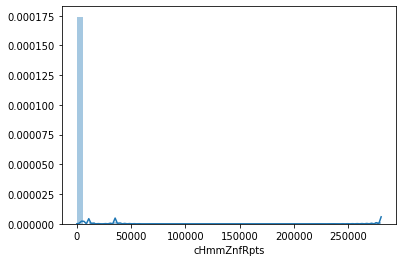




COLUMN 103 : chr_pos_ref_alt
Nr of values: 345443
Type of column: object
8_97307480_C_A          1
9_131254665_A_T         1
1_46726266_C_T          1
14_64596503_G_A         1
4_39450162_G_A          1
                       ..
7_100550908_A_C         1
1_201341180_GAGAAG_G    1
14_64492188_T_A         1
9_2101601_A_G           1
19_7167956_G_A          1
Name: chr_pos_ref_alt, Length: 345443, dtype: int64


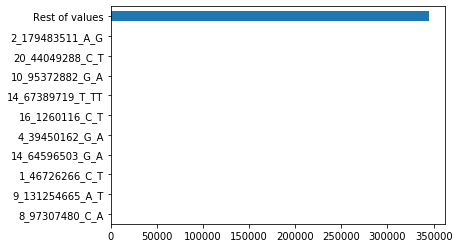




COLUMN 104 : chr_pos_ref_alt_gene
Nr of values: 345443
Type of column: object
10_81928900_G_C_ANXA11         1
7_105206085_T_C_RINT1          1
9_130996357_C_T_DNM1           1
1_186321251_A_C_MIR548F1       1
14_64726956_G_A_MIR548AZ       1
                              ..
X_31190531_C_G_DMD             1
2_215593531_G_A_BARD1          1
1_114445358_T_C_AP4B1          1
3_41925423_T_C_ULK4            1
13_111156503_G_A_COL4A2-AS1    1
Name: chr_pos_ref_alt_gene, Length: 345443, dtype: int64


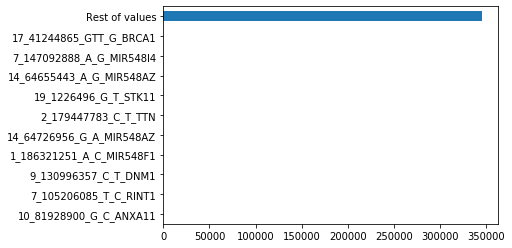




COLUMN 105 : clinpred
Nr of values: 121552
Type of column: float64
0.999970    20
1.000000    19
0.000295    17
0.999966     8
0.000581     7
            ..
0.446236     1
0.011053     1
0.877041     1
0.022283     1
0.795615     1
Name: clinpred, Length: 121552, dtype: int64


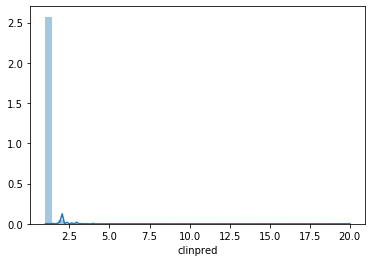




COLUMN 106 : dbscSNV-ada_score
Nr of values: 21458
Type of column: float64
0.999988    950
0.999987    824
0.999990    736
0.999986    375
0.999989    285
           ... 
0.999976      1
0.999965      1
0.006369      1
0.999970      1
0.000597      1
Name: dbscSNV-ada_score, Length: 21458, dtype: int64


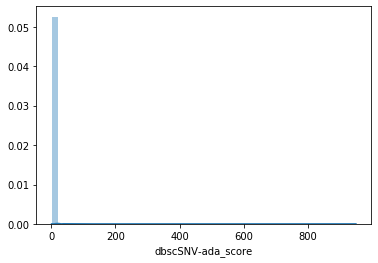




COLUMN 107 : dbscSNV-rf_score
Nr of values: 1065
Type of column: object
0.0                    3026
0.002                  1299
0.938                   902
0.004                   874
0.934                   558
                       ... 
0.684                     1
0.31                      1
0.32799999999999996       1
0.486                     1
0.748                     1
Name: dbscSNV-rf_score, Length: 1065, dtype: int64


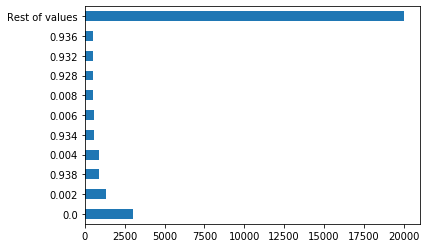




COLUMN 108 : fathmm_score
Nr of values: 64472
Type of column: float64
0.990749    26
0.991091    17
0.991682    14
0.991363    13
0.991769    12
            ..
0.116391     1
0.289346     1
0.009132     1
0.087277     1
0.015625     1
Name: fathmm_score, Length: 64472, dtype: int64


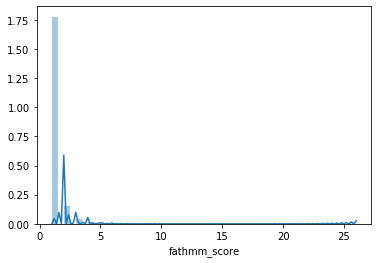




COLUMN 109 : inClinvar
Nr of values: 2
Type of column: object
False    214119
True     122012
Name: inClinvar, dtype: int64


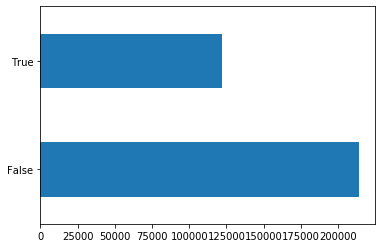




COLUMN 110 : inClinvar1Star
Nr of values: 2
Type of column: object
False    307033
True      29098
Name: inClinvar1Star, dtype: int64


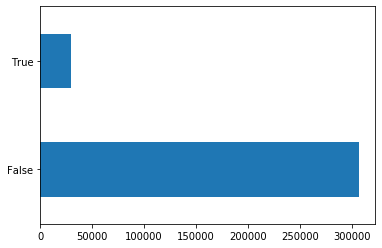




COLUMN 111 : inClinvar2Star
Nr of values: 2
Type of column: object
False    243217
True      92914
Name: inClinvar2Star, dtype: int64


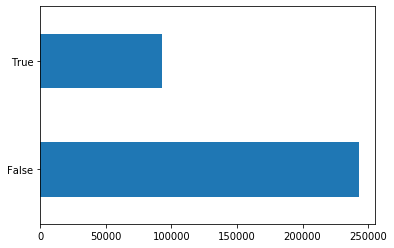




COLUMN 112 : inTest
Nr of values: 2
Type of column: object
False    338231
True       1791
Name: inTest, dtype: int64


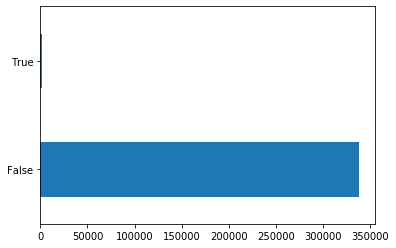




COLUMN 113 : inVKGLInsertion
Nr of values: 2
Type of column: object
False    320078
True        114
Name: inVKGLInsertion, dtype: int64


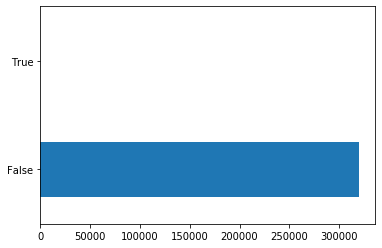




COLUMN 114 : inheritance
Nr of values: 31
Type of column: object
AD                                                                                                     113642
AR                                                                                                      52832
AD/AR                                                                                                   36482
XL                                                                                                      11829
AD/AR/Digenic                                                                                            1970
AD/Digenic                                                                                                934
AR/Digenic                                                                                                626
AD/BG                                                                                                     549
AR                                                  

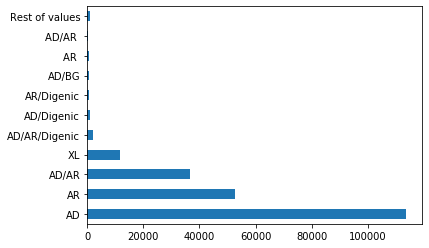




COLUMN 115 : isAR
Nr of values: 2
Type of column: bool
False    252272
True      93171
Name: isAR, dtype: int64


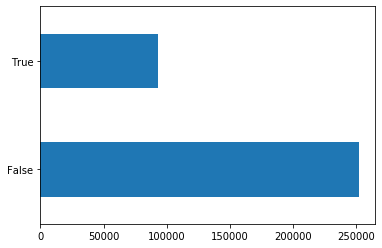




COLUMN 116 : isInsertion
Nr of values: 2
Type of column: bool
False    333751
True      11692
Name: isInsertion, dtype: int64


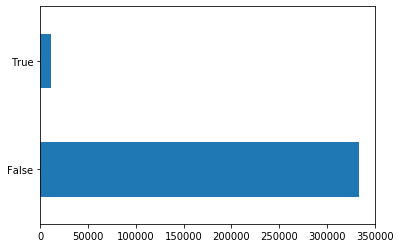




COLUMN 117 : isPopulation
Nr of values: 2
Type of column: bool
False    195314
True     150129
Name: isPopulation, dtype: int64


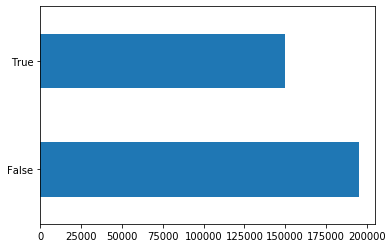




COLUMN 118 : isVKGL_needsFurtherCorrection
Nr of values: 1
Type of column: bool
False    345443
Name: isVKGL_needsFurtherCorrection, dtype: int64


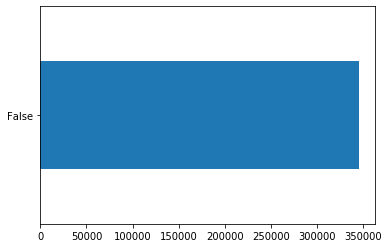




COLUMN 119 : label
Nr of values: 2
Type of column: object
Benign        299341
Pathogenic     46102
Name: label, dtype: int64


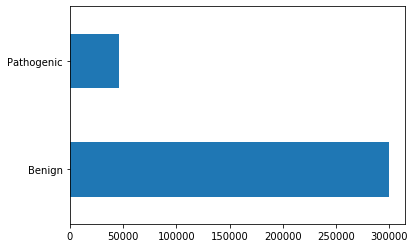




COLUMN 120 : mamPhCons
Nr of values: 1001
Type of column: float64
1.000    86355
0.000    52008
0.999    20024
0.001    13635
0.998     9326
         ...  
0.433       33
0.465       32
0.472       30
0.348       29
0.538       27
Name: mamPhCons, Length: 1001, dtype: int64


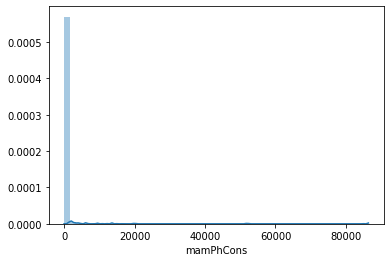




COLUMN 121 : mamPhyloP
Nr of values: 8017
Type of column: float64
 2.938    1391
-0.000     917
 2.368     836
 2.933     556
 2.891     469
          ... 
-5.818       1
-4.978       1
-5.241       1
-4.160       1
-5.853       1
Name: mamPhyloP, Length: 8017, dtype: int64


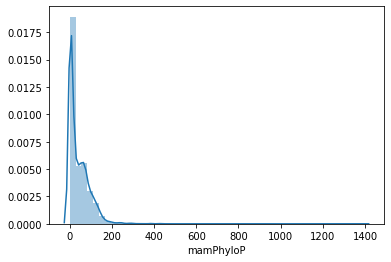




COLUMN 122 : max_AF
Nr of values: 61280
Type of column: float64
0.000000    80991
0.000032     5661
0.000058     2778
0.000030     2354
0.001193     2203
            ...  
0.000180        1
0.000360        1
0.000072        1
0.000006        1
0.000676        1
Name: max_AF, Length: 61280, dtype: int64


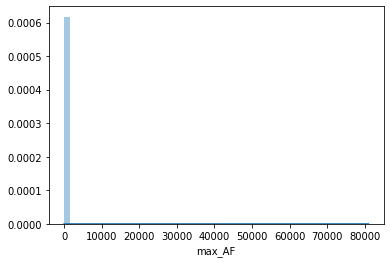




COLUMN 123 : minDistTSE
Nr of values: 63495
Type of column: float64
1.0         774
2.0         749
3.0         658
5.0         629
8.0         617
           ... 
173121.0      1
173122.0      1
43281.0       1
173126.0      1
43520.0       1
Name: minDistTSE, Length: 63495, dtype: int64


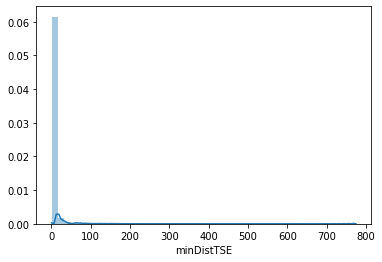




COLUMN 124 : minDistTSS
Nr of values: 82127
Type of column: float64
1.0         632
3.0         562
2.0         546
7.0         517
6.0         501
           ... 
40446.0       1
87194.0       1
174387.0      1
36704.0       1
131069.0      1
Name: minDistTSS, Length: 82127, dtype: int64


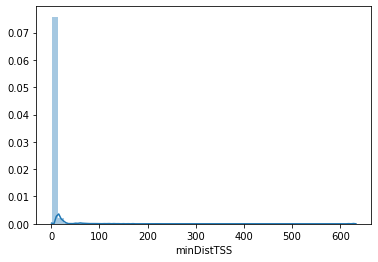




COLUMN 125 : mirSVR-Aln
Nr of values: 69
Type of column: float64
120.0    4650
140.0    3242
145.0    1996
147.0    1525
150.0    1458
         ... 
197.0       2
187.0       1
186.0       1
185.0       1
180.0       1
Name: mirSVR-Aln, Length: 69, dtype: int64


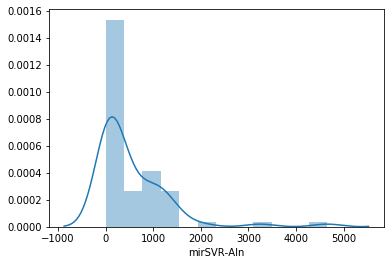




COLUMN 126 : mirSVR-E
Nr of values: 2971
Type of column: float64
-15.06    75
-26.11    53
-18.51    49
-16.23    47
-10.02    47
          ..
-38.10     1
-45.27     1
-31.44     1
-3.61      1
-35.54     1
Name: mirSVR-E, Length: 2971, dtype: int64


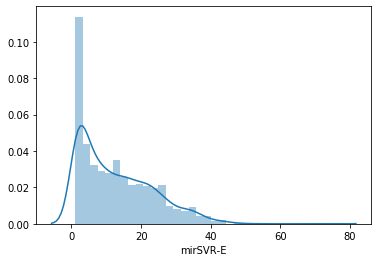




COLUMN 127 : mirSVR-Score
Nr of values: 8970
Type of column: float64
-0.0001    199
-0.0002    180
-0.0004    178
-0.0000    147
-0.0003    147
          ... 
-1.2550      1
-0.5716      1
-0.5375      1
-0.7106      1
-0.5917      1
Name: mirSVR-Score, Length: 8970, dtype: int64


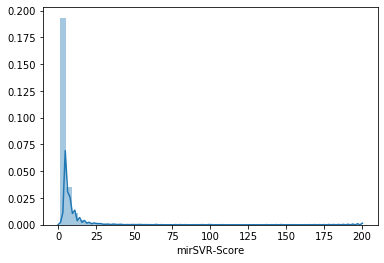




COLUMN 128 : motifDist
Nr of values: 561
Type of column: float64
 0.00    1165
 1.00     751
-1.00     217
 0.04     208
 0.01     199
         ... 
-3.69       1
-6.54       1
-6.06       1
-2.42       1
-7.35       1
Name: motifDist, Length: 561, dtype: int64


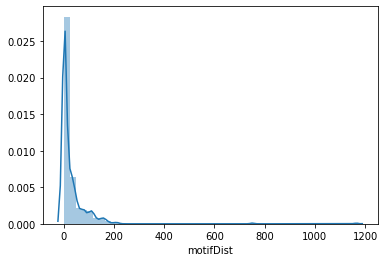




COLUMN 129 : motifECount
Nr of values: 13
Type of column: float64
1.0     1204
2.0      402
3.0      151
4.0       84
5.0       40
6.0       24
8.0       15
10.0      11
9.0       10
12.0       7
7.0        7
11.0       4
13.0       1
Name: motifECount, dtype: int64


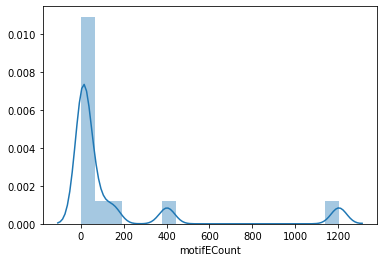




COLUMN 130 : motifEHIPos
Nr of values: 2
Type of column: float64
0.0    1419
1.0     541
Name: motifEHIPos, dtype: int64


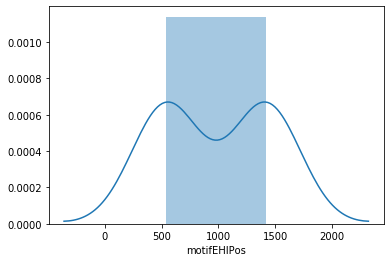




COLUMN 131 : motifEName
Nr of values: 58
Type of column: object
CTCF:MA0139.1      384
Egr1:MA0162.2      182
Egr1:PB0010.1      160
E2F1:MA0024.2      105
Egr1:MA0341.1       95
Yy1:MA0095.2        82
Znf263:MA0528.1     78
Gabp:MA0062.2       55
Max:PB0043.1        55
Gabp:PB0020.1       53
Nrsf:MA0138.2       51
E2F4:MA0470.1       45
Cjun:MA0303.1       42
USF1:MA0281.1       41
Max:PB0147.1        41
E2F4:MA0541.1       40
Egr1:MA0337.1       37
Egr1:MA0366.1       36
USF1:MA0093.2       28
Gabp:PB0124.1       27
Egr1:PB0114.1       21
Max:MA0569.1        20
Srf:MA0083.2        17
ZBTB33:MA0527.1     17
HNF4A:MA0114.2      15
E2F6:MA0471.1       15
Jund:MA0491.1       14
Cjun:MA0488.1       14
CTCFL:MA0531.1      13
PU1:PB0058.1        13
ELF1:MA0473.1       13
FOSL2:MA0478.1      12
SP1:MA0079.3        12
Max:MA0058.2        12
Srf:MA0271.1         9
Cjun:MA0489.1        9
Gabp:MA0062.1        9
HNF4A:PB0134.1       8
Tr4:MA0504.1         8
PU1:MA0080.3         8
Cmyc:MA0147.2

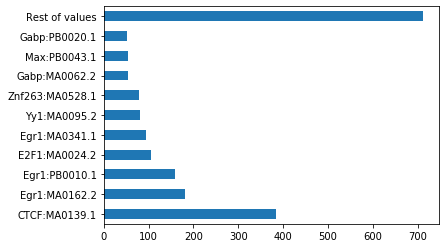




COLUMN 132 : motifEScoreChng
Nr of values: 185
Type of column: float64
-0.203    92
-0.030    41
-0.007    38
-0.103    37
 0.006    33
          ..
-0.102     1
-0.053     1
 0.055     1
 0.032     1
-0.131     1
Name: motifEScoreChng, Length: 185, dtype: int64


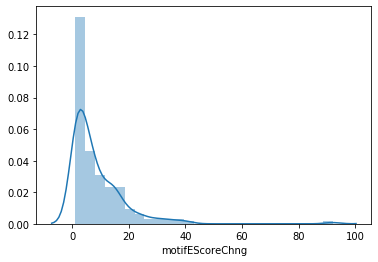




COLUMN 133 : nAA
Nr of values: 1889
Type of column: object
L        18387
S        17724
X        16292
T        15712
V        15251
         ...  
NQGPX        1
RSSR         1
KSIDX        1
ADX          1
DILX         1
Name: nAA, Length: 1889, dtype: int64


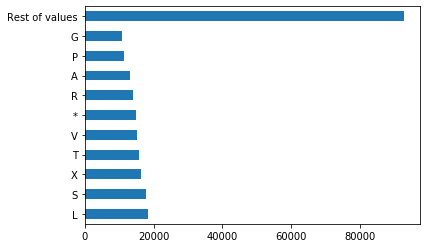




COLUMN 134 : notinTest1
Nr of values: 2
Type of column: bool
True     337127
False      8316
Name: notinTest1, dtype: int64


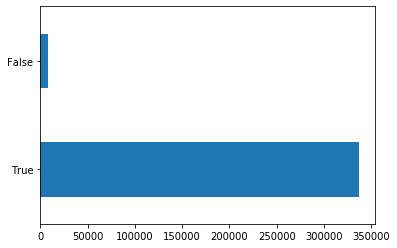




COLUMN 135 : oAA
Nr of values: 3022
Type of column: object
R                           24143
A                           19192
L                           17532
P                           17105
S                           16845
                            ...  
QTPTTVLITTTTTMTPTPTPTSTK        1
SIAP                            1
VDYLK                           1
ISLGRT                          1
LEEE                            1
Name: oAA, Length: 3022, dtype: int64


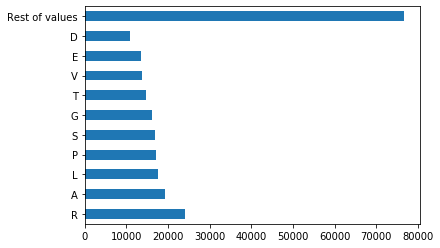




COLUMN 136 : oldTestset
Nr of values: 2
Type of column: bool
False    334601
True      10842
Name: oldTestset, dtype: int64


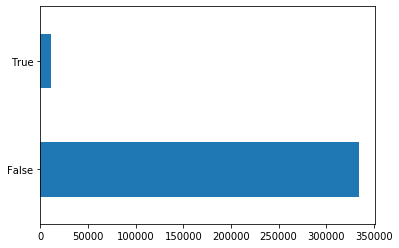




COLUMN 137 : priPhCons
Nr of values: 1000
Type of column: float64
0.998    10635
0.997     8391
0.001     7399
0.996     7147
0.000     6043
         ...  
0.557       89
0.487       88
0.411       84
0.514       83
0.508       76
Name: priPhCons, Length: 1000, dtype: int64


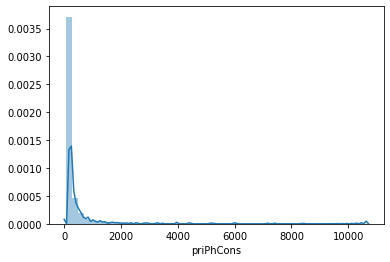




COLUMN 138 : priPhyloP
Nr of values: 3934
Type of column: float64
 0.651    40606
 0.530    24926
 0.557    19200
 0.645    15484
 0.457    14224
          ...  
-4.955        1
-2.571        1
-3.139        1
-3.185        1
-3.702        1
Name: priPhyloP, Length: 3934, dtype: int64


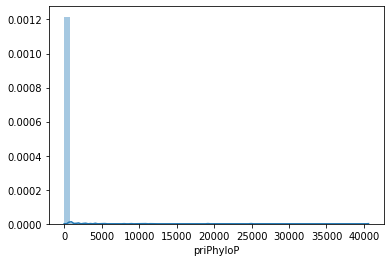




COLUMN 139 : protPos
Nr of values: 16125
Type of column: float64
68.0       321
142.0      319
93.0       314
172.0      312
94.0       312
          ... 
23370.0      1
13040.0      1
8028.0       1
13661.0      1
28832.0      1
Name: protPos, Length: 16125, dtype: int64


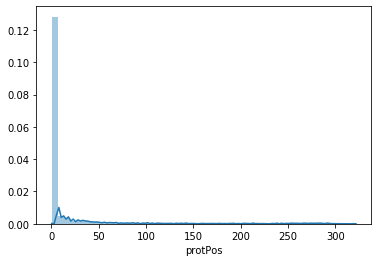




COLUMN 140 : provean
Nr of values: 2320
Type of column: float64
-0.00     70734
 0.73       360
 0.80       341
 0.85       341
 0.63       335
          ...  
-11.05        1
-5.06         1
-3.46         1
-3.52         1
 41.87        1
Name: provean, Length: 2320, dtype: int64


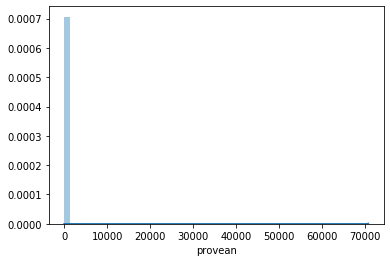




COLUMN 141 : relCDSpos
Nr of values: 203706
Type of column: float64
0.333333    100
0.666667     94
0.833333     66
1.000000     42
0.500000     41
           ... 
0.664073      1
0.590301      1
0.257085      1
0.464316      1
0.745079      1
Name: relCDSpos, Length: 203706, dtype: int64


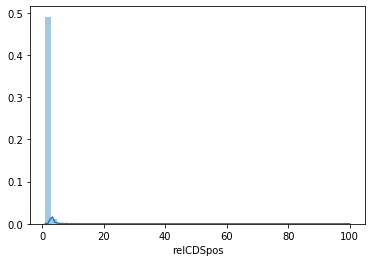




COLUMN 142 : relProtPos
Nr of values: 163777
Type of column: float64
1.000000    239
0.500000    155
0.666667    118
0.333333    116
0.750000     89
           ... 
0.630663      1
0.663110      1
0.830034      1
0.789866      1
0.644918      1
Name: relProtPos, Length: 163777, dtype: int64


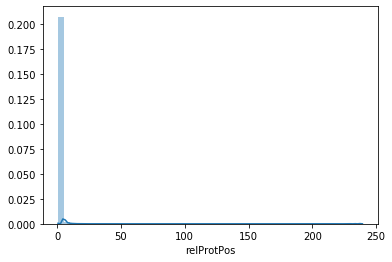




COLUMN 143 : relcDNApos
Nr of values: 233606
Type of column: float64
0.500000    35
0.333333    30
0.400000    28
0.666667    25
0.250000    24
            ..
0.991160     1
0.466068     1
0.166641     1
0.576938     1
0.087726     1
Name: relcDNApos, Length: 233606, dtype: int64


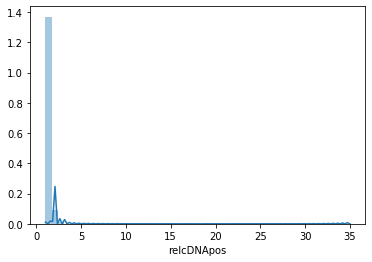




COLUMN 144 : revel
Nr of values: 1001
Type of column: float64
0.030    406
0.041    404
0.033    402
0.036    388
0.043    387
        ... 
0.001     17
0.997     16
0.999     11
1.000     10
0.000      7
Name: revel, Length: 1001, dtype: int64


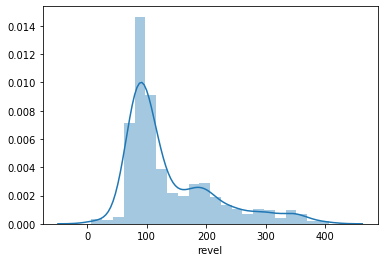




COLUMN 145 : sample_weight
Nr of values: 2
Type of column: float64
0.8    301818
1.0     43625
Name: sample_weight, dtype: int64


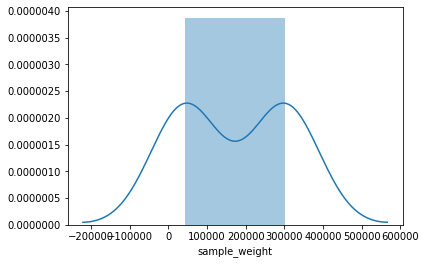




COLUMN 146 : sift
Nr of values: 1001
Type of column: float64
0.000    60411
1.000    20841
0.999     9305
0.998     4934
0.997     3398
         ...  
0.058       18
0.187       17
0.054       16
0.045       15
0.026       12
Name: sift, Length: 1001, dtype: int64


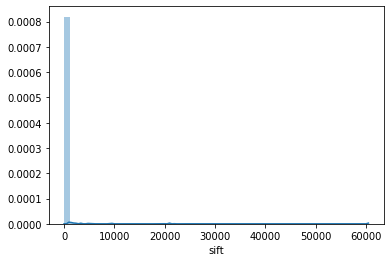




COLUMN 147 : source
Nr of values: 3
Type of column: object
unknown    214119
clinvar    122012
vkgl         9312
Name: source, dtype: int64


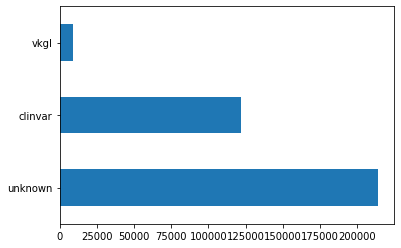




COLUMN 148 : tOverlapMotifs
Nr of values: 28
Type of column: float64
1.0     11230
2.0      2856
3.0      1344
4.0       624
5.0       370
6.0       214
7.0       116
10.0       58
8.0        56
9.0        48
11.0       31
15.0       16
12.0       16
20.0       13
13.0       10
14.0        7
17.0        6
16.0        5
21.0        5
19.0        4
18.0        4
22.0        4
27.0        3
36.0        2
26.0        2
31.0        1
23.0        1
24.0        1
Name: tOverlapMotifs, dtype: int64


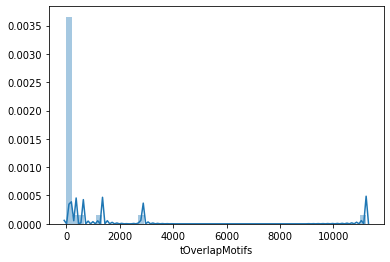




COLUMN 149 : targetScan
Nr of values: 67
Type of column: float64
99.0    41
98.0    35
96.0    34
97.0    28
78.0    27
        ..
15.0     1
27.0     1
50.0     1
43.0     1
62.0     1
Name: targetScan, Length: 67, dtype: int64


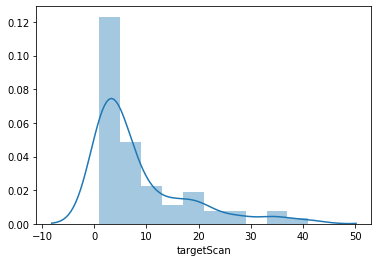




COLUMN 150 : to_be_deleted
Nr of values: 2
Type of column: bool
False    341557
True       3886
Name: to_be_deleted, dtype: int64


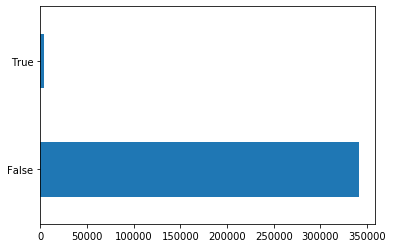




COLUMN 151 : verPhCons
Nr of values: 1001
Type of column: float64
1.000    120003
0.000     57510
0.999     16075
0.001     12746
0.998      6984
          ...  
0.525        24
0.520        24
0.630        23
0.490        23
0.557        22
Name: verPhCons, Length: 1001, dtype: int64


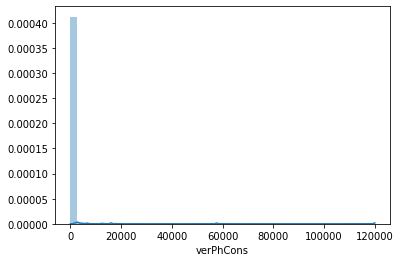




COLUMN 152 : verPhyloP
Nr of values: 11334
Type of column: float64
 0.000    759
 0.311    211
 0.202    193
 0.192    193
 0.275    181
         ... 
-5.237      1
-5.626      1
-3.712      1
-4.545      1
-4.556      1
Name: verPhyloP, Length: 11334, dtype: int64


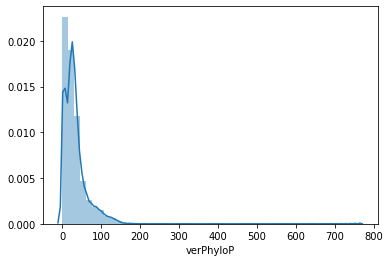

In [23]:
for i in range(len(train.columns)):
    c = data.columns[i]
    print('COLUMN', i, ':', c)
    counts = data[c].value_counts()
    t = data[c].dtype
    print('Nr of values:', len(counts))
    print('Type of column:', t)
    print(counts)
    
    #if type of variable is numerical, plot histogram, else plot barplot (of the top 10 values if there are more than 10 values). 
    if t == 'int64' or t == 'float64':
        sns.distplot(counts)
    else:   
        if len(counts) > 10:
            rest = counts[10:].sum()
            counts = counts[0:10]
            counts['Rest of values'] = rest
        counts.plot(kind='barh')
    if c not in all_features_model:
        c = 'NOT-USED_' + c
    plt.savefig('../figures/data_exploration/feature_frequency_plots_all_data/' + c.replace('/', '_') + '.png', bbox_inches='tight')
    plt.show()
    print('\n\n')

<h3>Adding NCBoost pathogenic variants</h3>
655 pathogenic variants from NCBoost were downloaded from https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1634-2#Sec34 (Additional file 1). Add them to the data.

In [26]:
#TODO: First run CADD on the downloaded variants.
#Before adding them to the data, check if labels are consistent. Write numbers to file to put in report later. 

In [92]:
ncboost = pd.read_csv('../files/NCBoost_pathogenic_variants/13059_2019_1634_MOESM1_ESM.txt', sep='\t')

In [93]:
ncboost.columns

Index(['chr', 'pos', 'ref', 'alt', 'closest_gene_name',
       'annovar_genomic_region', 'OMIM_diseases', 'HGMD_DM_public', 'ClinVar',
       'Smedley_2016'],
      dtype='object')

In [94]:
ncboost.columns = ['#Chrom', 'Pos', 'Ref', 'Alt', 'NCBoost_closest_gene_name', 'NBoost_annovar_genomic_region', 'NCBoost_OMIM_diseases', 'NCBoost_HGMD_DM_public', 'NCBoost_ClinVar', 'NCBoost_Smedley']
ncboost

#Chrom        Pos Ref Alt NCBoost_closest_gene_name  \
0        1   21835920   C   T                      ALPL   
1        1   55505180   C   A                     PCSK9   
2        1  113498814   C   T                   SLC16A1   
3        1  209975332   G   T                      IRF6   
4        1  209975361   T   A                      IRF6   
..     ...        ...  ..  ..                       ...   
650      8   11561283   C   T                     GATA4   
651      8   41655260   G   C                      ANK1   
652      X   49834101   G   A                     CLCN5   
653      X   55054635   A   G                     ALAS2   
654      8   11422122   G   T                       BLK   

    NBoost_annovar_genomic_region  \
0                            UTR5   
1                            UTR5   
2                            UTR5   
3                            UTR5   
4                            UTR5   
..                            ...   
650                      intronic   
651                      intronic   
652                      intronic   
653                      intronic   
654                    downstream   

                                 NCBoost_OMIM_diseases  \
0    Hypophosphatasia, adult |||| Odontohypophospha...   
1                    Hypercholesterolemia, familial, 3   
2    Erythrocyte lactate transporter defect |||| Hy...   
3    van der Woude syndrome |||| Popliteal pterygiu...   
4    van der Woude syndrome |||| Popliteal pterygiu...   
..                                                 ...   
650  Tetralogy of Fallo || Atrial septal defect  ||...   
651                               Spherocytosis, type    
652  Dent diseas || Hypophosphatemic ricket || Prot...   
653  Anemia, sideroblastic,  || Protoporphyria, ery...   
654      Maturity-onset diabetes of the young, type 11   

     NCBoost_HGMD_DM_public  NCBoost_ClinVar  NCBoost_Smedley  
0                         1                0                1  
1                         1                0                1  
2                         1                1                1  
3                         1                0                0  
4                         1                0                1  
..                      ...              ...              ...  
650                       0                0                1  
651                       0                0                1  
652                       0                0                1  
653                       0                0                1  
654                       0                1                1  

[655 rows x 10 columns]

Which variants overlap? Are the labels consistent?

In [99]:
merged = data[['#Chrom', 'Pos', 'Ref', 'Alt', 'label', 'sample_weight', 'Consequence']].merge(ncboost, on=['#Chrom', 'Pos', 'Ref', 'Alt'])
merged

#Chrom        Pos Ref Alt       label  sample_weight Consequence  \
0       X  153136500   G   A  Pathogenic            0.8    INTRONIC   
1      11   47368616   C   T  Pathogenic            0.8    INTRONIC   
2       2   47635062   T   G  Pathogenic            1.0    INTRONIC   
3       5   60223572   C   G  Pathogenic            0.8    INTRONIC   
4       1  228337561   A   G  Pathogenic            0.8  DOWNSTREAM   
..    ...        ...  ..  ..         ...            ...         ...   
73      6  152643033   T   C  Pathogenic            1.0    INTRONIC   
74      2   74177701   C   G  Pathogenic            1.0    INTRONIC   
75     19   11200090   C   G  Pathogenic            1.0  REGULATORY   
76     19   11200089   C   T  Pathogenic            1.0  REGULATORY   
77      9   21974860   C   A  Pathogenic            1.0  5PRIME_UTR   

   NCBoost_closest_gene_name NBoost_annovar_genomic_region  \
0                      L1CAM                      intronic   
1                     MYBPC3                      intronic   
2                       MSH2                      intronic   
3                      ERCC8                      intronic   
4                       GJC2                          UTR5   
..                       ...                           ...   
73                     SYNE1                      intronic   
74                     DGUOK                      intronic   
75                      LDLR                          UTR5   
76                      LDLR                          UTR5   
77                    CDKN2A                          UTR5   

                                NCBoost_OMIM_diseases  NCBoost_HGMD_DM_public  \
0   CRASH syndrome |||| MASA syndrome |||| Corpus ...                       0   
1   Cardiomyopathy, hypertrophic, 4 |||| Cardiomyo...                       0   
2   Colorectal cancer, hereditary nonpolyposis, ty...                       0   
3   Cockayne syndrome, type A |||| UV-sensitive sy...                       0   
4   Leukodystrophy, hypomyelinating, 2 |||| Spasti...                       1   
..                                                ...                     ...   
73  Spinocerebellar ataxia, autosomal recessive 8 ...                       0   
74  Mitochondrial DNA depletion syndrome 3 (hepato...                       0   
75                     Hypercholesterolemia, familial                       1   
76                     Hypercholesterolemia, familial                       1   
77  Melanoma and neural system tumor syndrome ||||...                       1   

    NCBoost_ClinVar  NCBoost_Smedley  
0                 1                0  
1                 1                0  
2                 1                0  
3                 1                0  
4                 1                1  
..              ...              ...  
73                1                0  
74                1                0  
75                0                0  
76                0                1  
77                1                1  

[78 rows x 13 columns]

In [96]:
merged.label.value_counts()
merged.sample_weight.value_counts()

0.8    43
1.0    35
Name: sample_weight, dtype: int64

In [97]:
merged[merged.label=='Benign']

#Chrom        Pos Ref Alt   label  sample_weight Consequence  \
58      5  176836585   C   G  Benign            0.8    UPSTREAM   
59      5  176836590   G   A  Benign            0.8    UPSTREAM   
60     12   52308396   G   C  Benign            0.8    INTRONIC   
61      X   55057393   G   A  Benign            0.8  5PRIME_UTR   
62      X  153991099   C   G  Benign            0.8  5PRIME_UTR   
63      9  130616643   C   T  Benign            0.8  REGULATORY   
64     19   11242035   G   A  Benign            0.8  DOWNSTREAM   
65     14   21162173   G   A  Benign            0.8  3PRIME_UTR   
66      1   91382343   G   C  Benign            0.8  3PRIME_UTR   

   NCBoost_closest_gene_name NBoost_annovar_genomic_region  \
58                       F12                      upstream   
59                       F12                      upstream   
60                    ACVRL1                      intronic   
61                     ALAS2                          UTR5   
62                      DKC1                          UTR5   
63                       ENG                          UTR5   
64                      LDLR                          UTR3   
65                       ANG                          UTR3   
66                    ZNF644                          UTR3   

                                NCBoost_OMIM_diseases  NCBoost_HGMD_DM_public  \
58  Factor XII deficienc || Angioedema, hereditary...                       0   
59  Factor XII deficiency |||| Angioedema, heredit...                       1   
60     Telangiectasia, hereditary hemorrhagic, type 2                       1   
61  Anemia, sideroblastic, 1 |||| Protoporphyria, ...                       1   
62                   Dyskeratosis congenita, X-linked                       1   
63      Telangiectasia, hereditary hemorrhagic, type                        0   
64                     Hypercholesterolemia, familial                       1   
65                    Amyotrophic lateral sclerosis 9                       1   
66                       Myopia 21, autosomal dominan                       0   

    NCBoost_ClinVar  NCBoost_Smedley  
58                0                1  
59                0                1  
60                0                0  
61                0                0  
62                0                1  
63                0                1  
64                0                0  
65                0                0  
66                0                1

The labeling is pretty consistent. 9 of the 69 variants do not agree on labeling. Probably because our variants were extracted from ClinVar. The authors of NCBoost also looked at literature (Smedley dataset) and the Human Gene Mutation Database. A variant can be annotated pathogenic in Smedley or HGMD but not in ClinVar. Therefore, correct these labels in our dataset and add all the variants from NCBoost to our data. 

In [84]:
ncboost['label'] = 'Pathogenic'

Now merge NCBoost data with our data.

In [88]:
print(ncboost.shape, data.shape)

(655, 11) (345443, 153)


<h1>Subsetting the data on non-coding variants</h1>
<br>To generate the noncoding subset, only keep variants where 'Consequence' points to non-coding.

In [24]:
data.Consequence.value_counts()

NON_SYNONYMOUS      130522
SYNONYMOUS           67633
INTRONIC             44205
FRAME_SHIFT          21860
DOWNSTREAM           16502
STOP_GAINED          15100
SPLICE_SITE          11818
UPSTREAM              9465
3PRIME_UTR            8717
REGULATORY            6745
CANONICAL_SPLICE      6555
INFRAME               3559
5PRIME_UTR            1380
NONCODING_CHANGE      1292
STOP_LOST               77
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64

In [32]:
nc_consq_values = ['INTRONIC', 'DOWNSTREAM', 'UPSTREAM', '3PRIME_UTR', '5PRIME_UTR', 'INTERGENIC', 'NONCODING_CHANGE']
nc = data.loc[data.Consequence.isin(nc_consq_values)]

print('Percentage of non-coding variants in whole dataset:', nc.shape[0]/train.shape[0]*100)
print(nc.shape)
c = nc['label'].value_counts()
print('Percentage pathogenic in non-coding dataset:', round(c['Pathogenic'] / nc.shape[0] * 100, 2))
print(c)
print('Percentage pathogenic in whole dataset:', round( train['label'].value_counts()['Pathogenic']/train.shape[0]*100, 2))

Percentage of non-coding variants in whole dataset: 24.37828936554284
(81570, 153)
Percentage pathogenic in non-coding dataset: 2.44
Benign        79582
Pathogenic     1988
Name: label, dtype: int64
Percentage pathogenic in whole dataset: 12.16


Check how much NA values there are per column for the whole dataset and the noncoding subset, and remove non-informative features from the noncoding subset.

<h3>Save dataset</h3>
Save noncoding dataset. 

In [34]:
nc.to_csv('../data/data_nc.txt', sep='\t', index=False)

<h3>More data exploration</h3>

In [27]:
na_all = data[all_features_model].isnull().sum().divide(data.shape[0]).multiply(100).round(2)
na_nc = nc[all_features_model].isnull().sum().divide(nc.shape[0]).multiply(100).round(2)

In [28]:
feature_importance = list(map(lambda x: x[0], sorted([[k,v] for k, v in model.best_estimator_.get_booster().get_fscore().items()], key=lambda x: x[1], reverse=True)))
features_model_not_in_feature_importances = list(numerical_features_cadd.difference(set(feature_importance)))
print('Features from the model not in feature importances:', features_model_not_in_feature_importances)

#order the numerical features on importance. Add the other features to the end of the list
feature_importance_numerical = [x for x in feature_importance if x in numerical_features_cadd] + features_model_not_in_feature_importances


Features from the model not in feature importances: ['protPos']


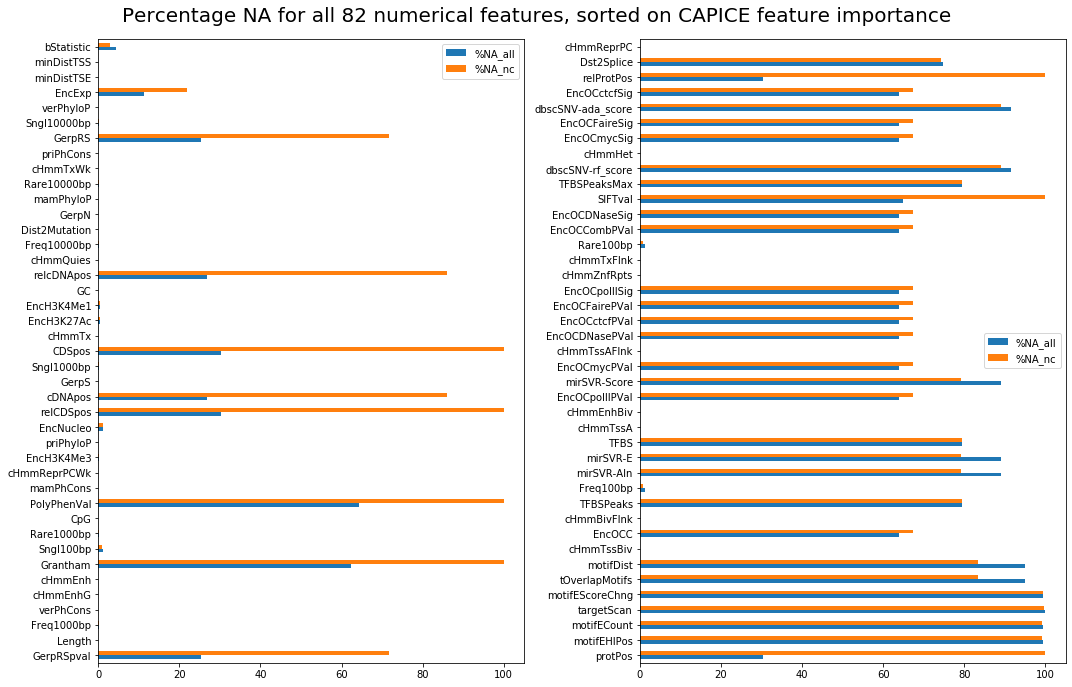

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
na_df_numerical = pd.DataFrame({'%NA_all': na_all, '%NA_nc': na_nc}, index=na_nc.index).reindex(feature_importance_numerical[::-1])
na_df_numerical[round(na_df_numerical.shape[0]/2):].plot.barh(rot=0, ax=ax0)
na_df_numerical[:round(na_df_numerical.shape[0]/2)].plot.barh(rot=0, ax=ax1)
fig.suptitle('Percentage NA for all ' + str(len(feature_importance_numerical)) + ' numerical features, sorted on CAPICE feature importance', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/data_exploration/percentage_NA_numerical.png', bbox_inches='tight')


<Figure size 360x360 with 0 Axes>

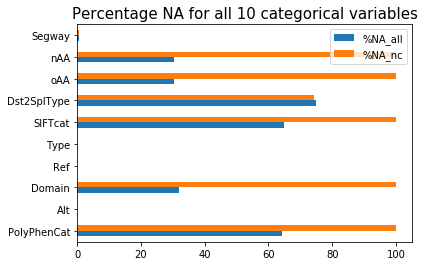

In [30]:
plt.figure(figsize=(5, 5))
na_df_categorical = pd.DataFrame({'%NA_all': na_all, '%NA_nc': na_nc}, index=na_nc.index).reindex(categorical_features_cadd)
na_df_categorical.plot.barh(rot=0)
plt.title('Percentage NA for all ' + str(len(categorical_features_cadd)) + ' categorical variables', fontsize=15)
plt.savefig('../figures/data_exploration/percentage_NA_categorical.png', bbox_inches='tight')

As can be seen in the plots above, some columns have a high percentage of NA values. For the noncoding variants, there are some columns that contain a lot of NA values (e.g. CDSpos, Domain, PolyPhen, SIFT). Drop these columns from the noncoding dataset (filtering out columns with more than 20% of NA values).

In [35]:
features_to_drop = na_df_numerical[na_df_numerical['%NA_nc'] > 20].index.tolist() + na_df_categorical[na_df_categorical['%NA_nc'] > 20].index.tolist()
print(len(features_to_drop), 'features from the', len(nc.columns) ,'will be dropped from the noncoding dataset due to having more than 20% NA values')

45 features from the 153 will be dropped from the noncoding dataset due to having more than 20% NA values


In [36]:
nc = nc.drop(features_to_drop, axis=1)

<h1>Feature correlation</h1>

In [37]:
len(set(nc.columns).intersection(set(model_features)))

43

Text(0.5, 1, 'Feature correlation for all variants')

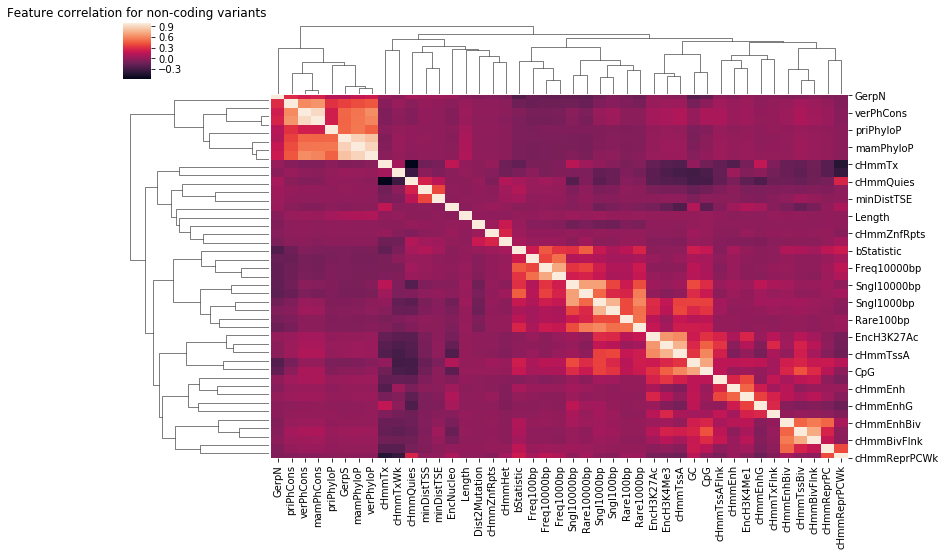

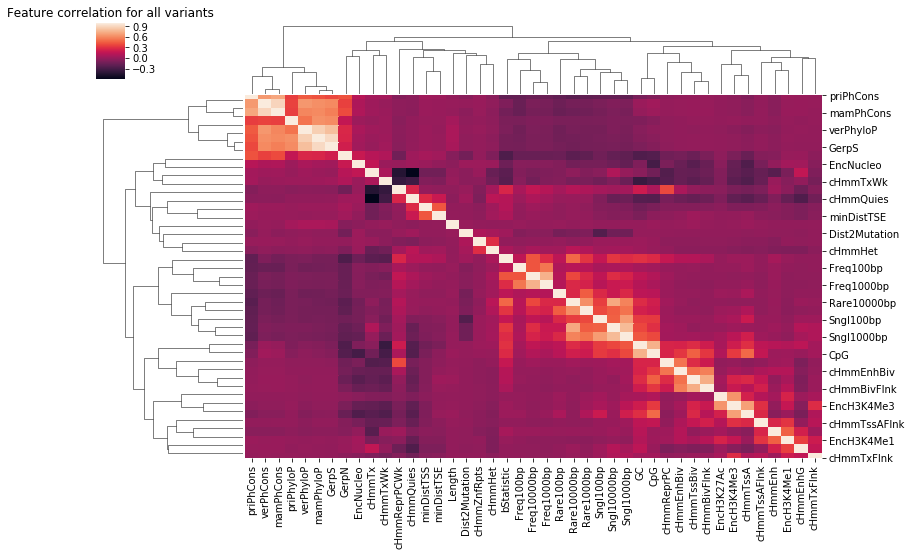

In [39]:
numerical_features = set(nc.columns).intersection(numerical_features_cadd)

#delete two columns because they contain NAs causing clustermap crash
#numerical_features.remove('relProtPos')
#numerical_features.remove('motifEScoreChng')

correlations_matrix = nc[numerical_features].corr()
clustermap(correlations_matrix, figsize=(13,8))
plt.title('Feature correlation for non-coding variants')
#plt.savefig('../figures/data_exploration/nc_features_correlation.png', bbox_inches='tight')

correlations_matrix = data[numerical_features].corr()
clustermap(correlations_matrix, figsize=(13,8))
plt.title('Feature correlation for all variants')
#plt.savefig('../figures/data_exploration/all_features_correlation.png', bbox_inches='tight')

<h1>PCA and tSNE</h1>

In [40]:
def dimreduction(df, features, n_pcs, plot_pc_variance=True, plottitle='PC_variance_ratio'):
    print('Dataframe with {} rows and {} columns. {} columns will be used for dimension reduction.'.format(df.shape[0], df.shape[1], len(features)))
    df_filtered = df[features].dropna()
    print('Dropping {} rows that contain NA values. Continuing with {} rows.'.format(df.shape[0]-df_filtered.shape[0], df_filtered.shape[0]))
    print(df[features].dropna().shape) 
    
    print('Performing PCA, calculating {} components.'.format(n_pcs))
    pca = PCA(n_components=n_pcs)
    min_max_scaler = preprocessing.StandardScaler() 
    normed_data = min_max_scaler.fit_transform(df_filtered)
    normed_pd = pd.DataFrame(data=normed_data, columns=features)
    pca.fit(normed_pd)
    pcs = pca.fit_transform(normed_pd)

    if plot_pc_variance:
        labels = [i+1 for i in range(len(pca.explained_variance_ratio_))]
        index = np.arange(len(labels))
        plt.bar(index, pca.explained_variance_ratio_)
        plt.xlabel('PC')
        plt.ylabel('Variance ratio')
        plt.xticks(index, labels, fontsize=6.5)
        plt.title('PC variance ratio')
        plt.show()
        plt.savefig('../figures/data_exploration/' + plottitle + '.png')
    
    pc_df = pd.DataFrame(data = pcs, columns=['PC' + str(x+1) for x in range(pcs.shape[1])])
    print(pc_df.shape)
    #add features that were not used for PCA to the pc df so we can use them for coloring later on
    remaining_features = set(df.columns).difference(df_filtered.columns) 
    df_dimred = pd.concat([pc_df.reset_index(), df.loc[df_filtered.index, list(remaining_features)].reset_index()], axis=1)
    
    print('Performing tSNE on 10 PCs...')
    #tsne = TSNE(n_components=2)
    #tsne_results = tsne.fit_transform(pc_df)

    #df_dimred['TSNE1'] = tsne_results[:,0]
    #df_dimred['TSNE2'] = tsne_results[:,1]
    
    print('Done!')
    
    return df_dimred

def plot_scatter(df, x, y, color_on, plottitle):
    #if feature to color on is not in
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(1,1,1) #nrows, ncols, index,
    ax.set_xlabel(x, fontsize = 30)
    ax.set_ylabel(y, fontsize = 30)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    #ax.set_title('title', fontsize = 20)
    
    targets = sorted(list(set(df[color_on])))
    for target in targets:
        indicesToKeep = df[color_on] == target
        ax.scatter(df.loc[indicesToKeep, x]
               , df.loc[indicesToKeep, y]
               , s = 8, alpha=1)
    ax.legend(targets, fontsize=30, markerscale=3)
    ax.grid()
    plt.savefig('../figures/data_exploration/' + plottitle + '.png')

Dataframe with 81570 rows and 108 columns. 43 columns will be used for dimension reduction.
Dropping 4383 rows that contain NA values. Continuing with 77187 rows.
(77187, 43)
Performing PCA, calculating 40 components.


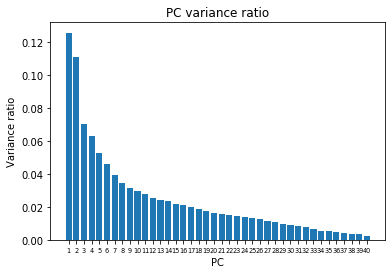

(77187, 40)
Performing tSNE on 10 PCs...
Done!


<Figure size 432x288 with 0 Axes>

In [41]:
nc_dimred = dimreduction(nc, numerical_features, n_pcs=40, plottitle='PC_variance_ratio_noncoding')

In [52]:
#nc_dimred = pickle.load(open('../data/noncoding_dimred.pkl', 'rb'))

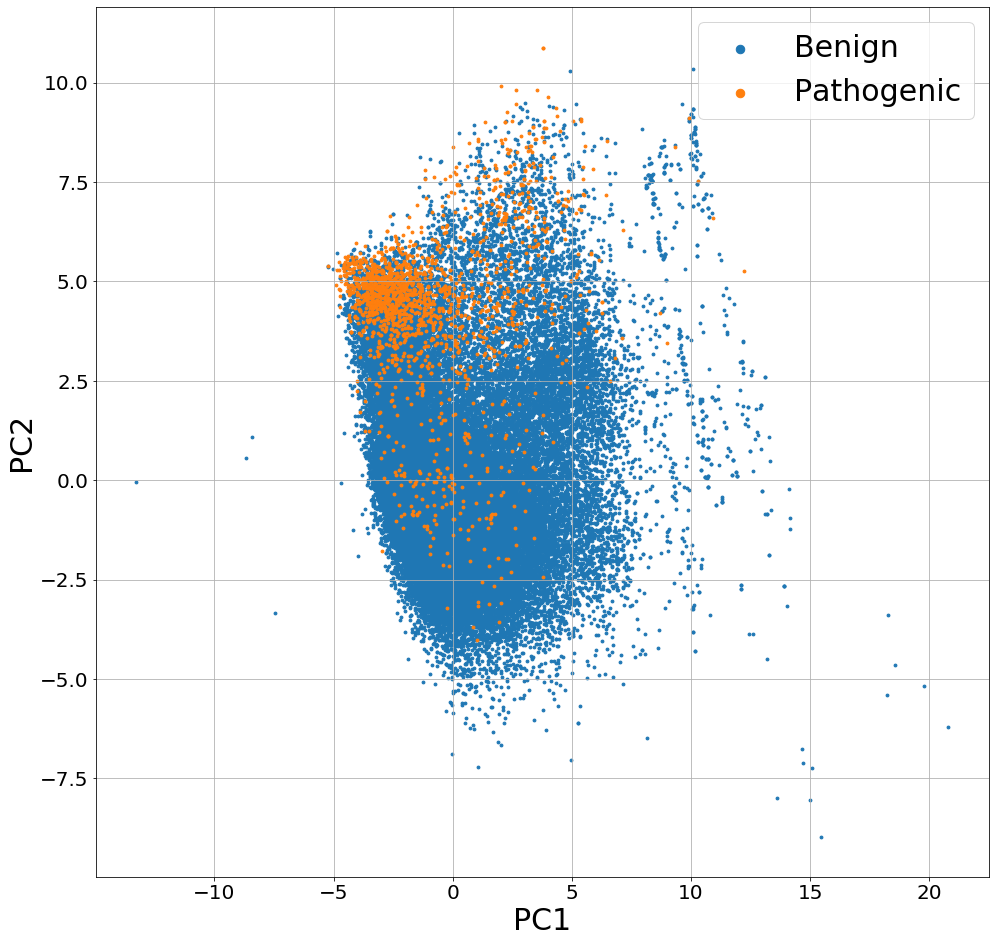

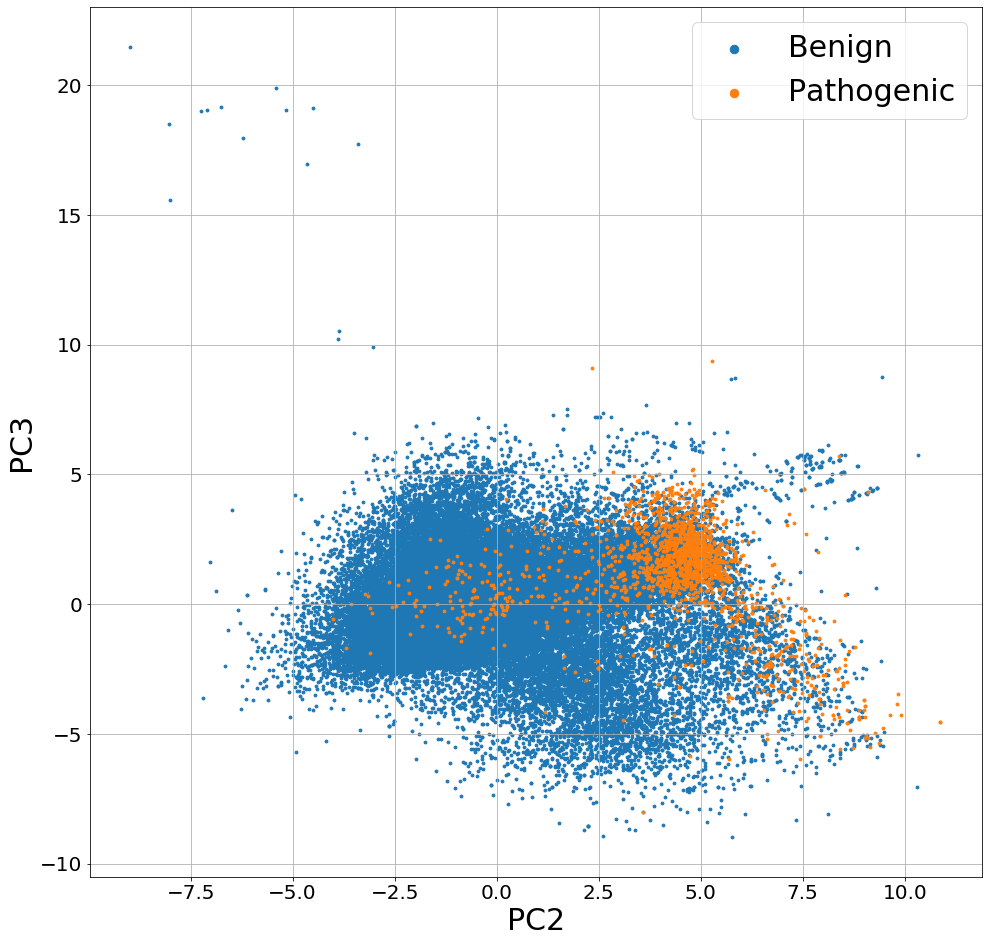

In [42]:
plot_scatter(nc_dimred, x='PC1', y='PC2', color_on='label', plottitle='PC1_PC2_noncoding')
plot_scatter(nc_dimred, x='PC2', y='PC3', color_on='label', plottitle='PC2_PC3_noncoding')

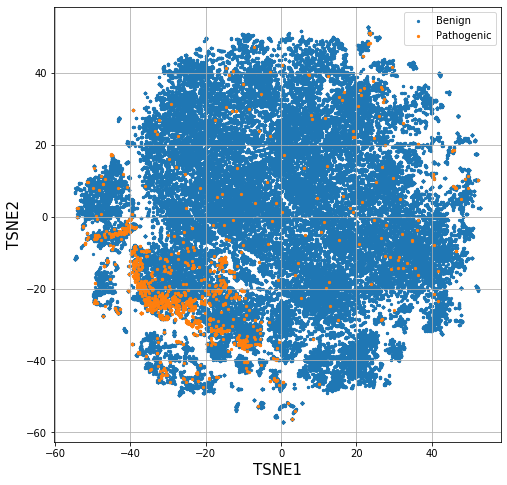

In [56]:
plot_scatter(nc_dimred, x='TSNE1', y='TSNE2', color_on='label', plottitle='TSNE_noncoding')

<h1>Feature violin plots</h1>

For each feature, plot the distribution per label and other categorical features. 

['verPhyloP', -65.07743444973255, 0.0]


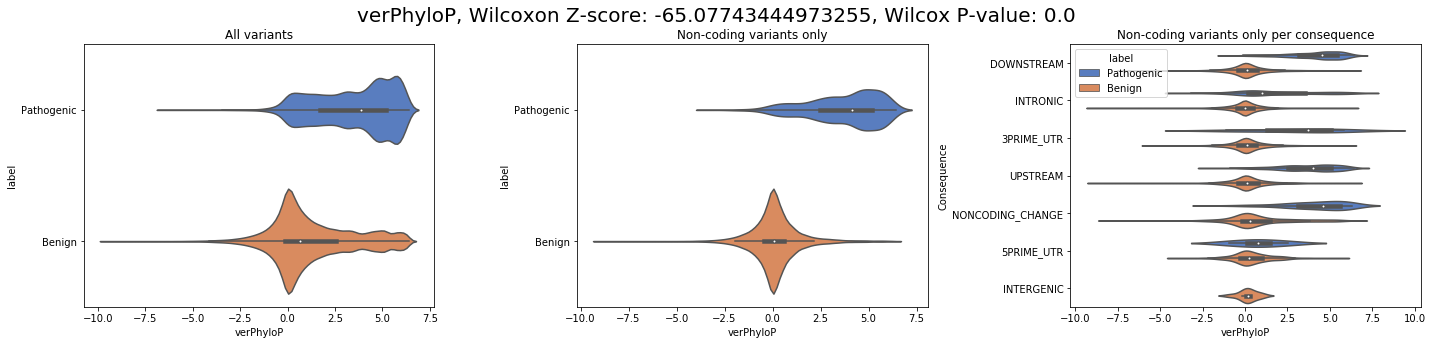

['verPhCons', -63.30190204857224, 0.0]


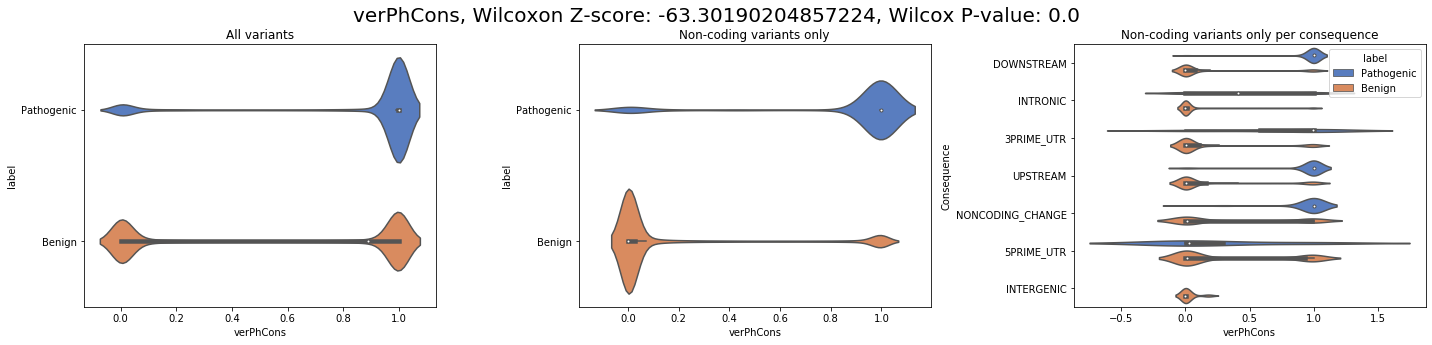

['GerpS', -63.02550120455857, 0.0]


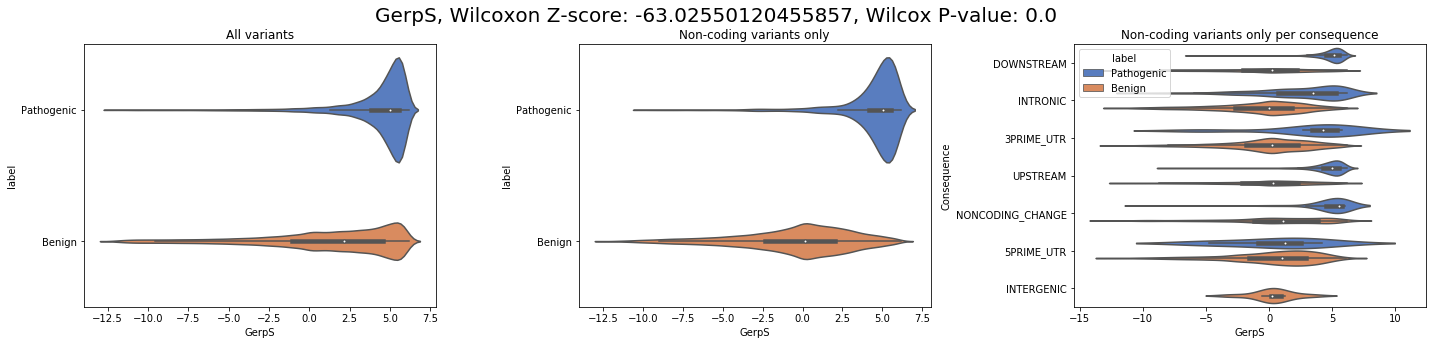

['mamPhyloP', -62.75120202794837, 0.0]


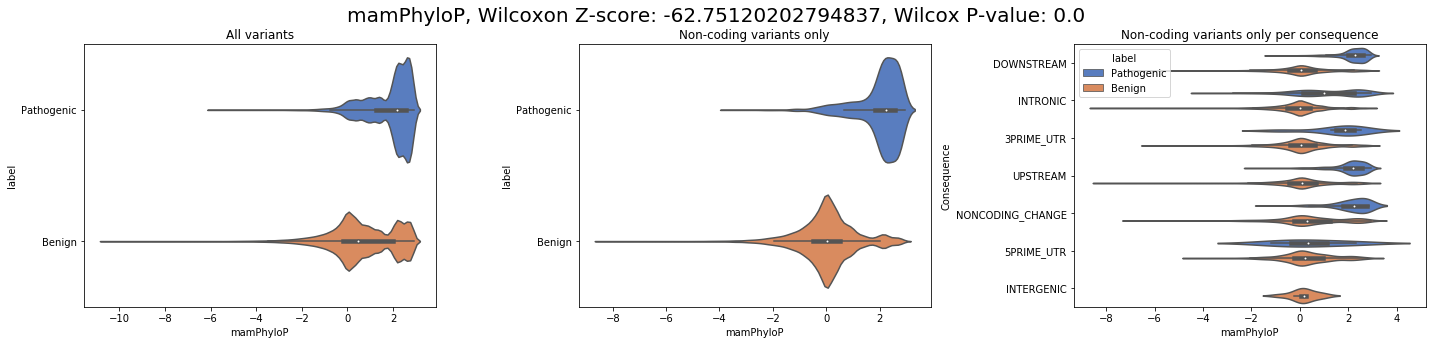

['mamPhCons', -62.02402317777097, 0.0]


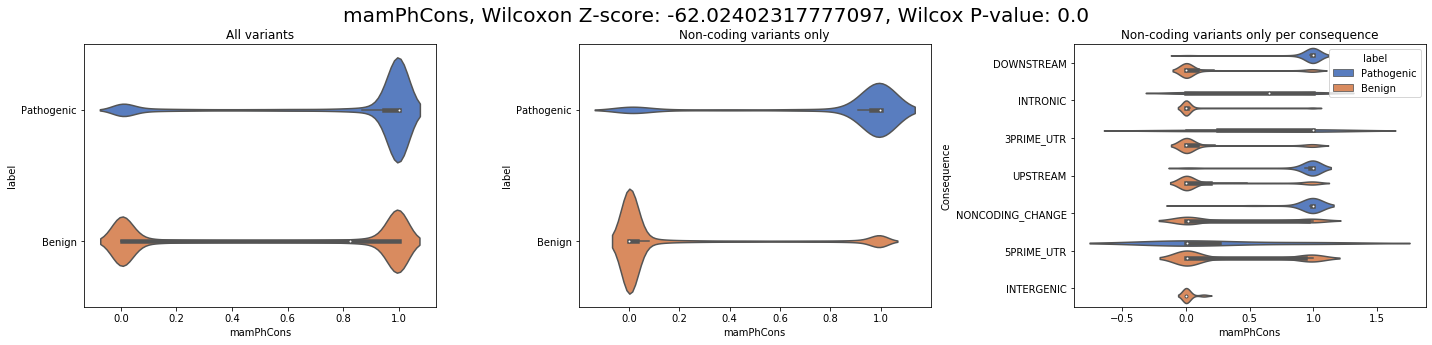

['priPhCons', -45.2304923702181, 0.0]


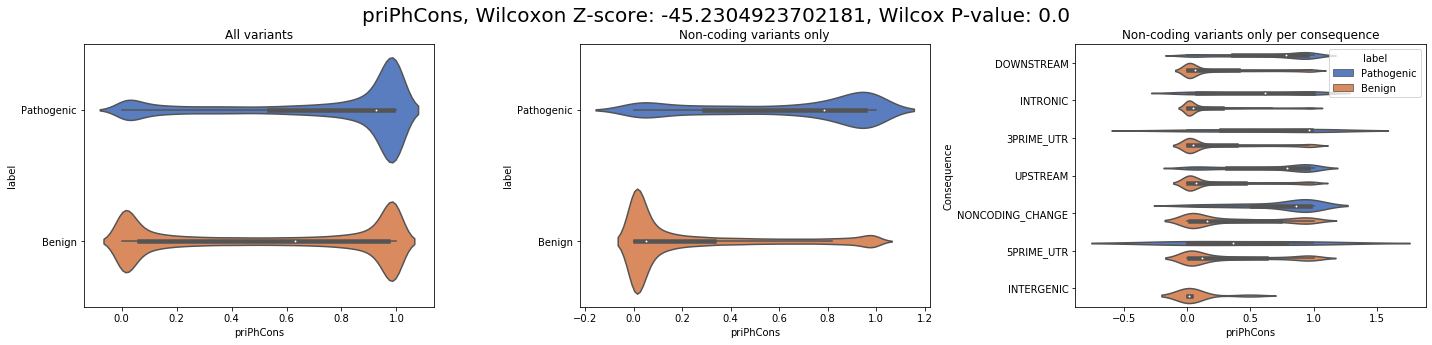

['priPhyloP', -35.24950560275709, 3.491308591322837e-272]


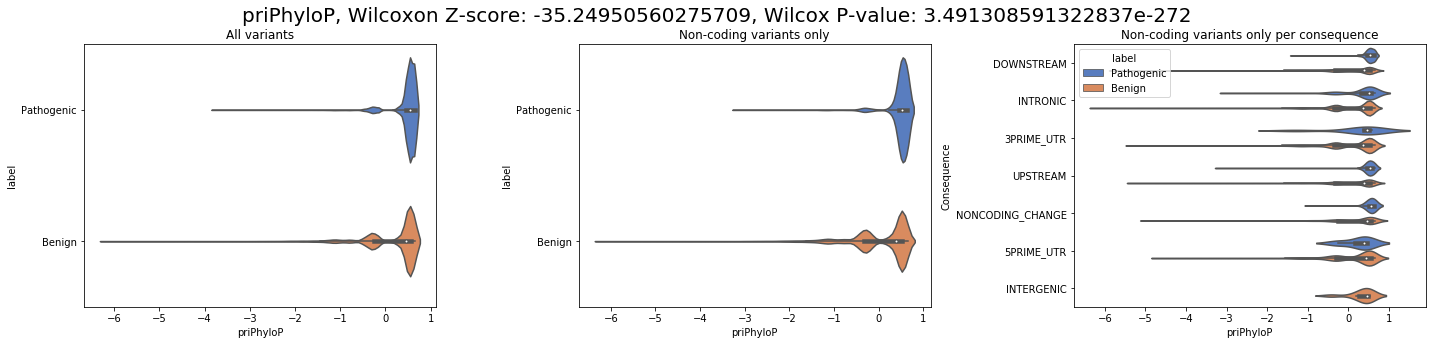

['GerpN', -32.691751301228486, 2.045746074690815e-234]


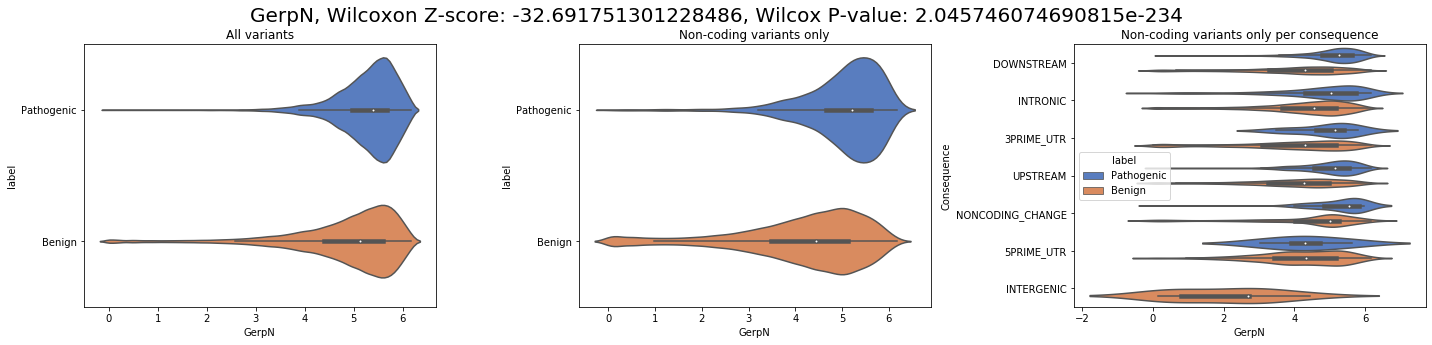

['minDistTSS', 21.365001661190888, 2.828430645928555e-101]


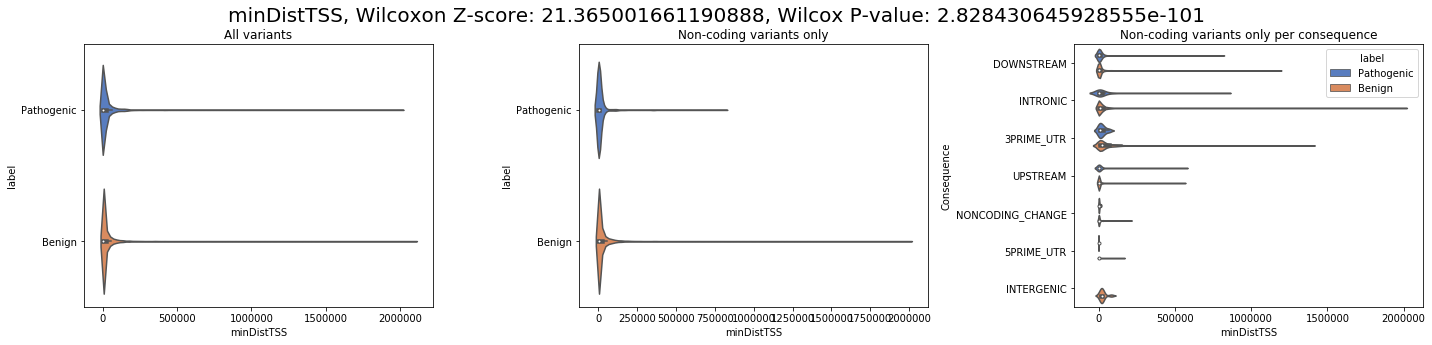

['cHmmQuies', 15.29631529221888, 8.090954098111075e-53]


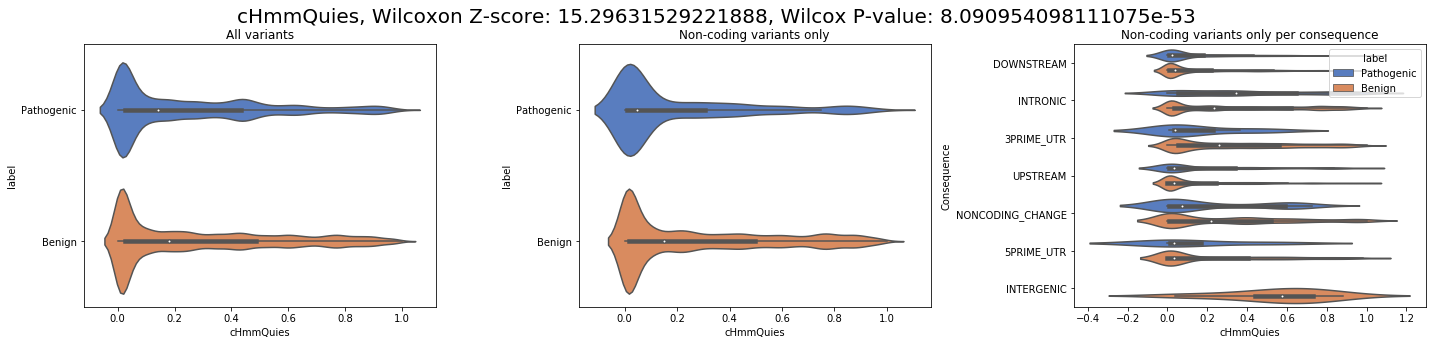

['CpG', -14.337674348201615, 1.2724862490047652e-46]


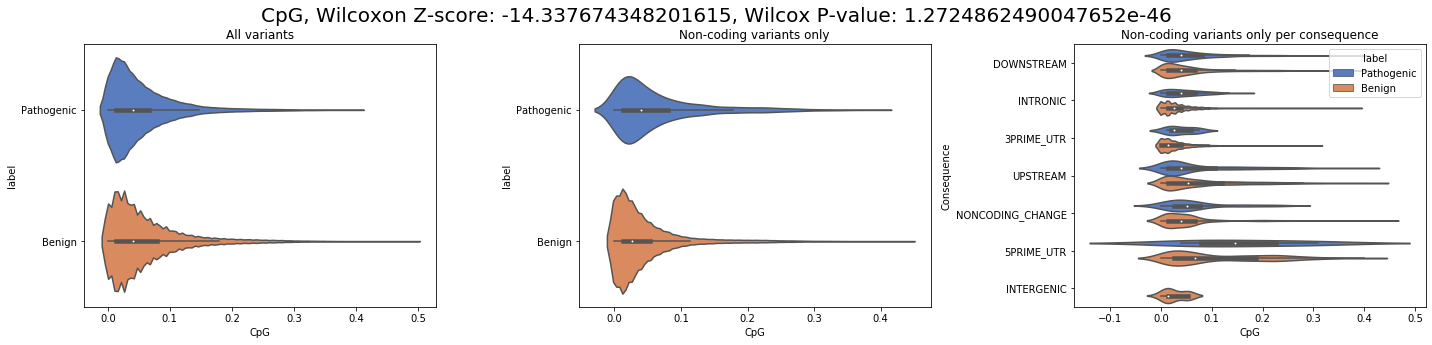

['EncH3K27Ac', -13.77467241342325, 3.620214936455216e-43]


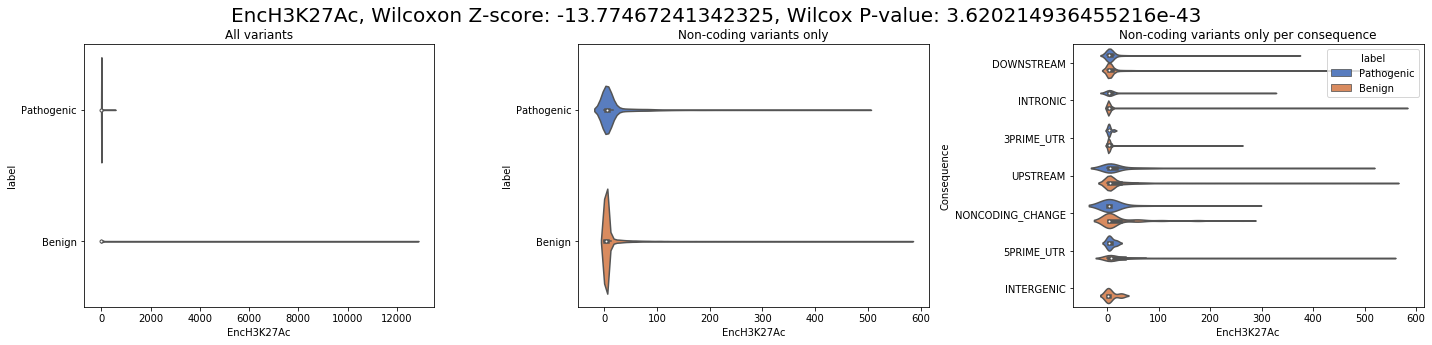

['GC', -13.29726894751606, 2.4007837073163627e-40]


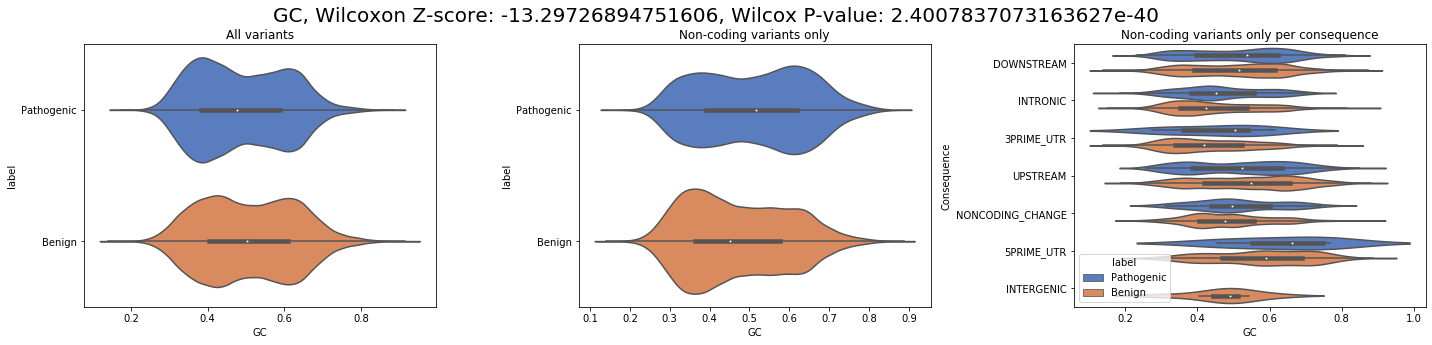

['cHmmReprPCWk', 10.01210870580155, 1.3484714751092457e-23]


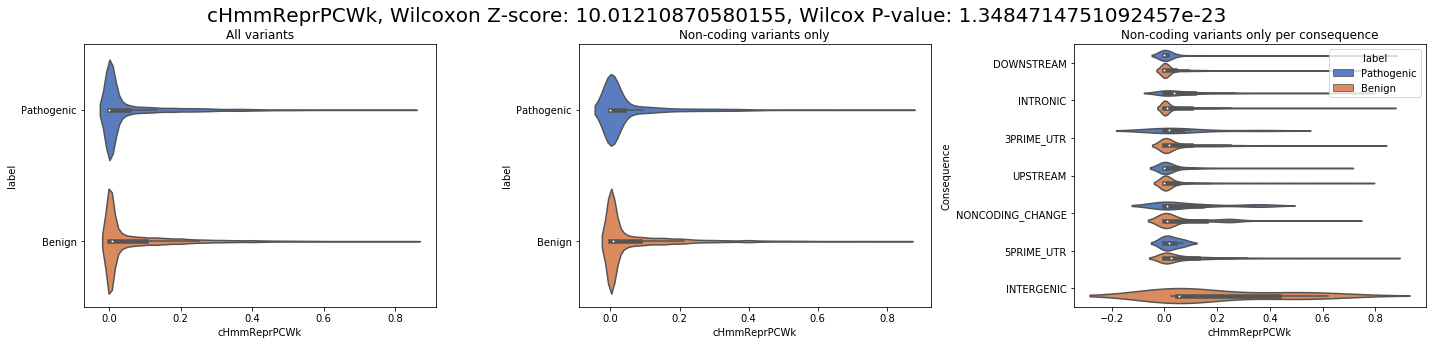

['cHmmTxFlnk', -9.783846122145084, 1.320933319060768e-22]


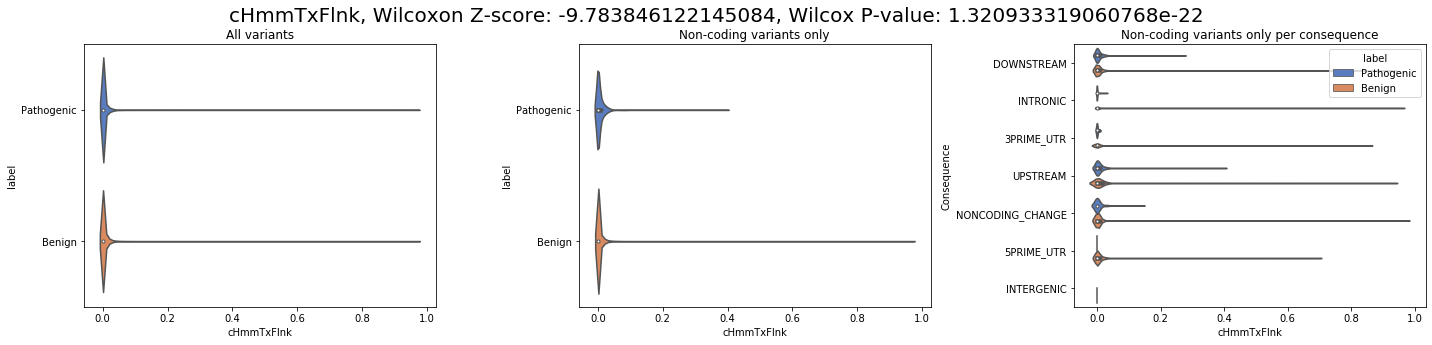

['Freq100bp', 9.27176201014213, 1.830958240300937e-20]


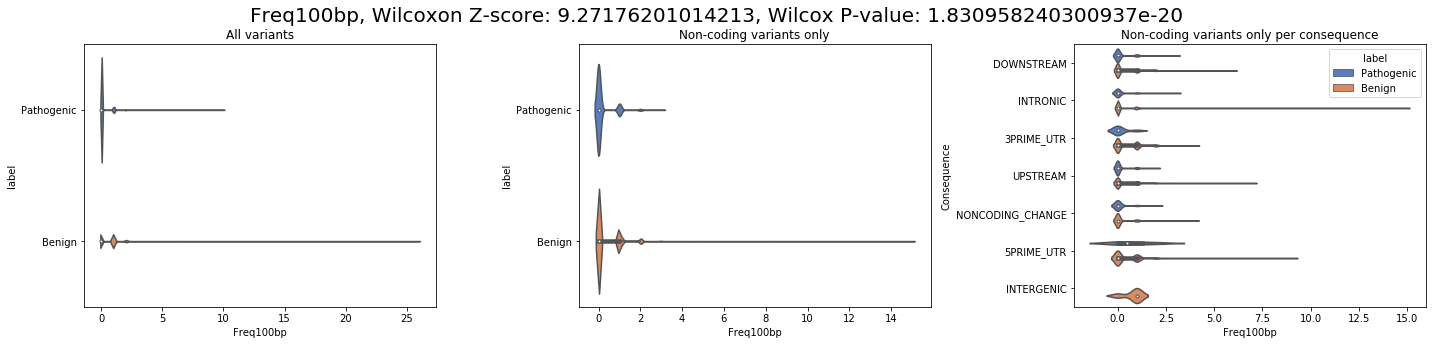

['Rare100bp', 9.135627576853778, 6.50284980460226e-20]


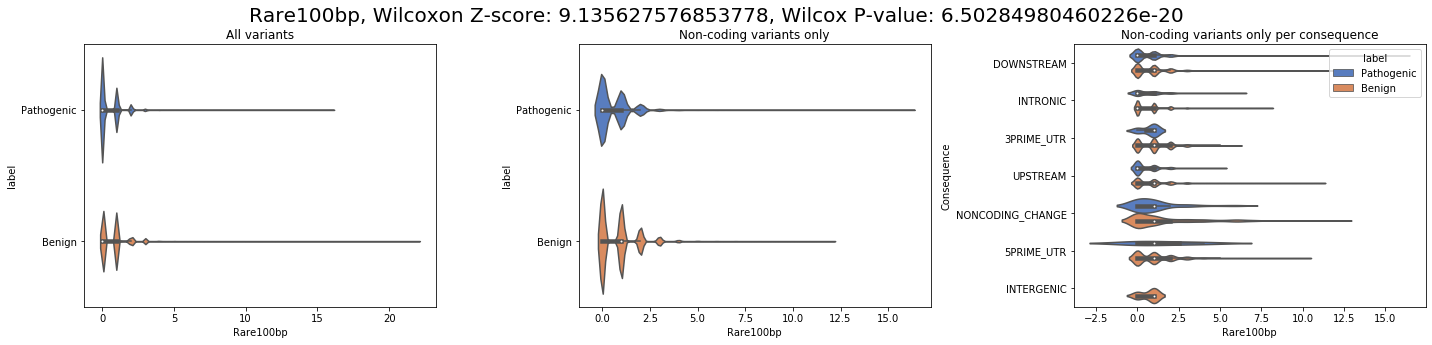

['EncH3K4Me1', -8.568052502520036, 1.052498122881679e-17]


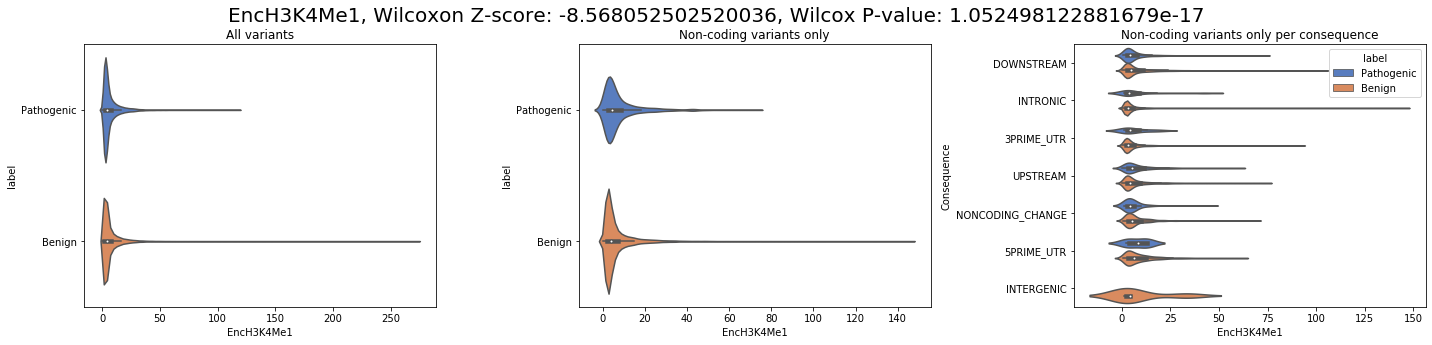

['minDistTSE', 8.520358779291994, 1.5905980837756885e-17]


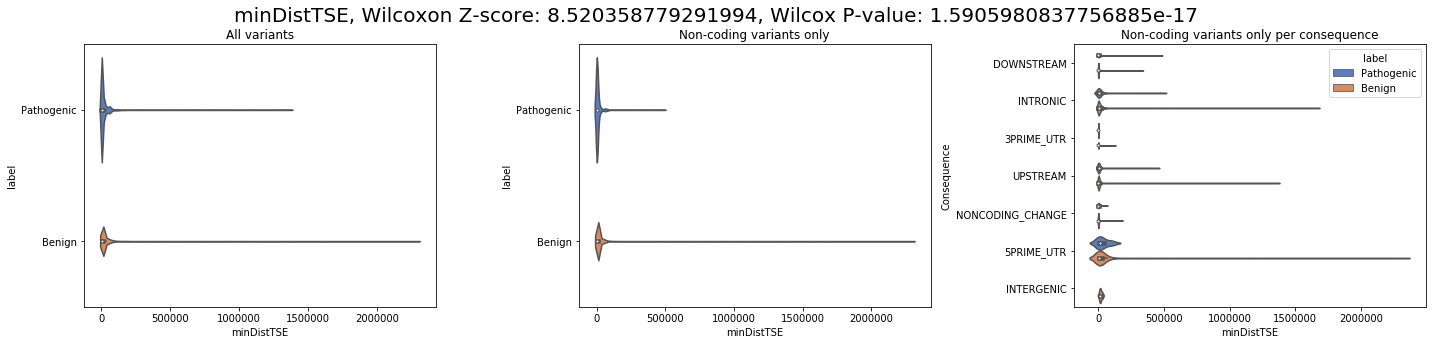

['cHmmTssA', -8.42626396195009, 3.568766312927661e-17]


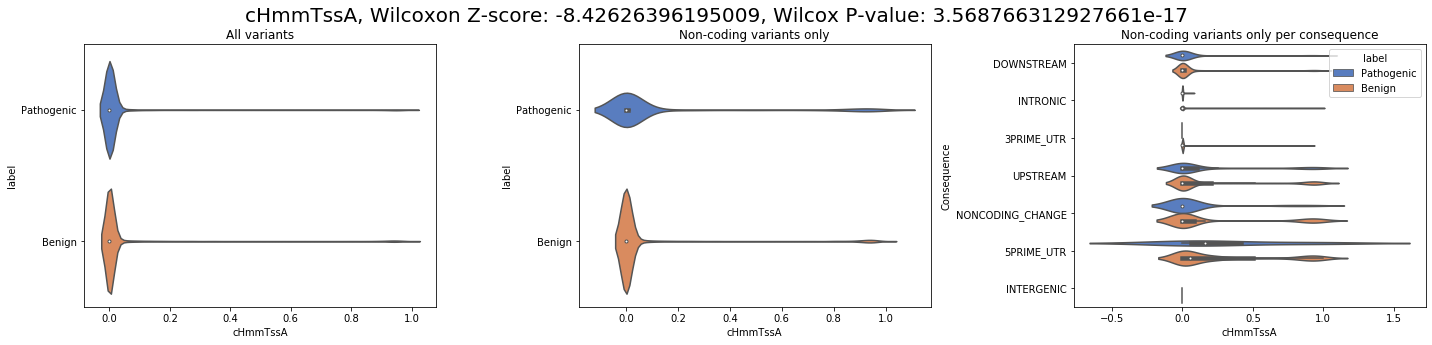

['Freq10000bp', 8.023522001532505, 1.0275557212430932e-15]


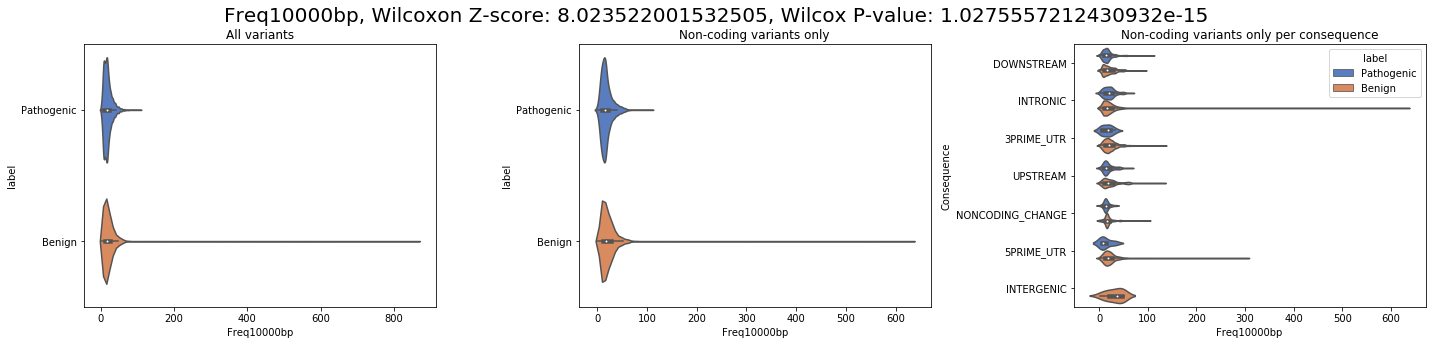

['EncH3K4Me3', -7.985708863323796, 1.3971708120109142e-15]


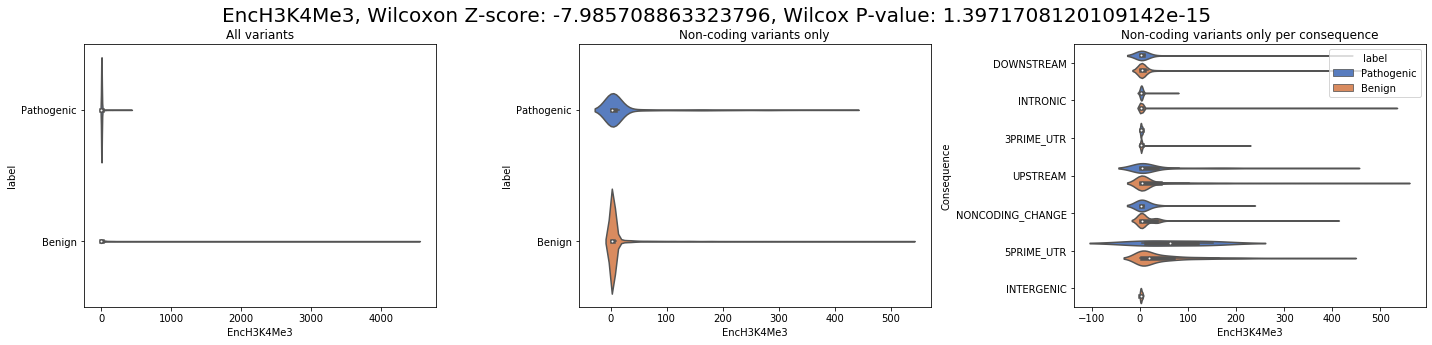

['cHmmTssAFlnk', -7.16228579610624, 7.93427885014458e-13]


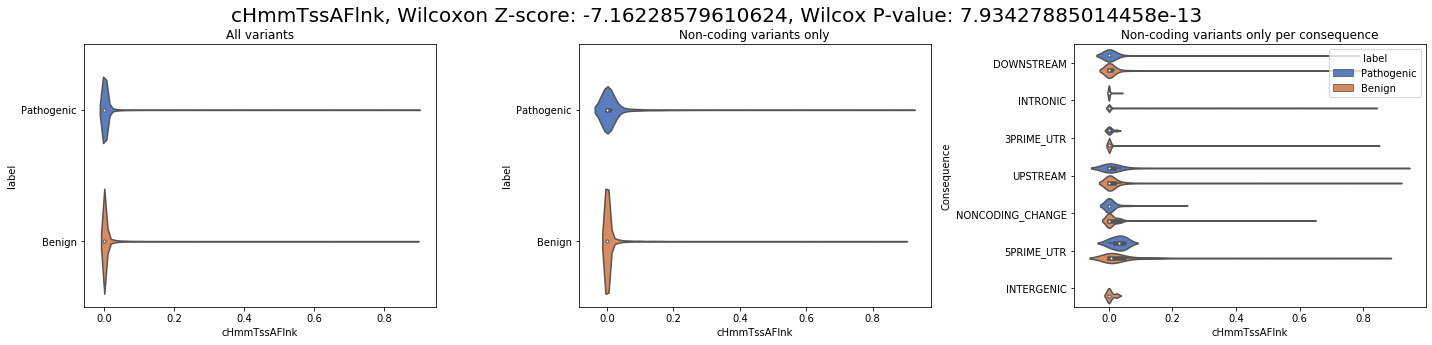

['Sngl10000bp', -7.149114575613482, 8.733941002750596e-13]


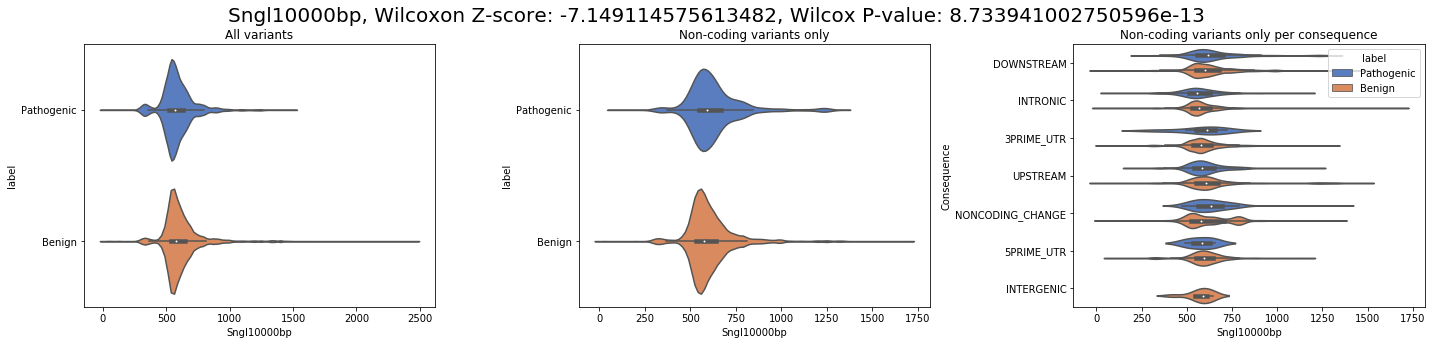

['Freq1000bp', 6.997863951356211, 2.5989426847881293e-12]


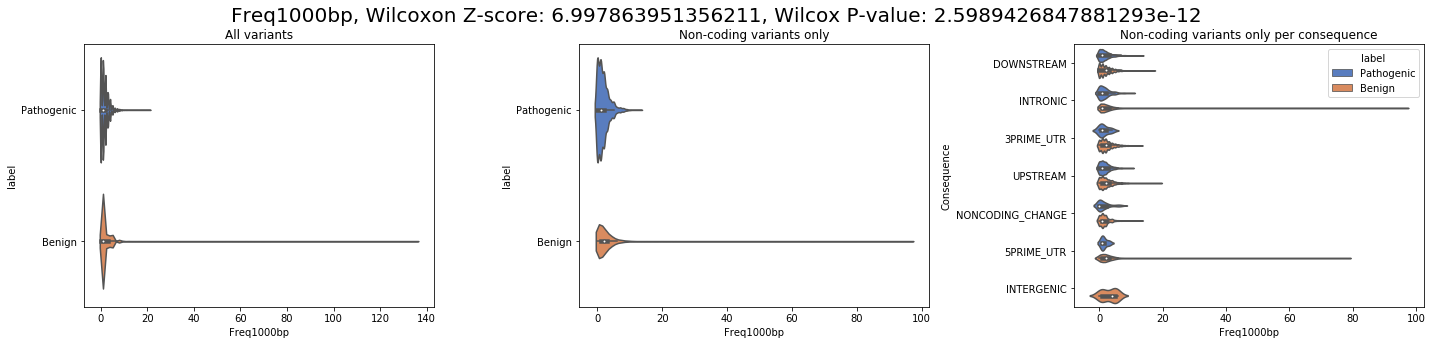

['bStatistic', 6.78305657123922, 1.1765953648823359e-11]


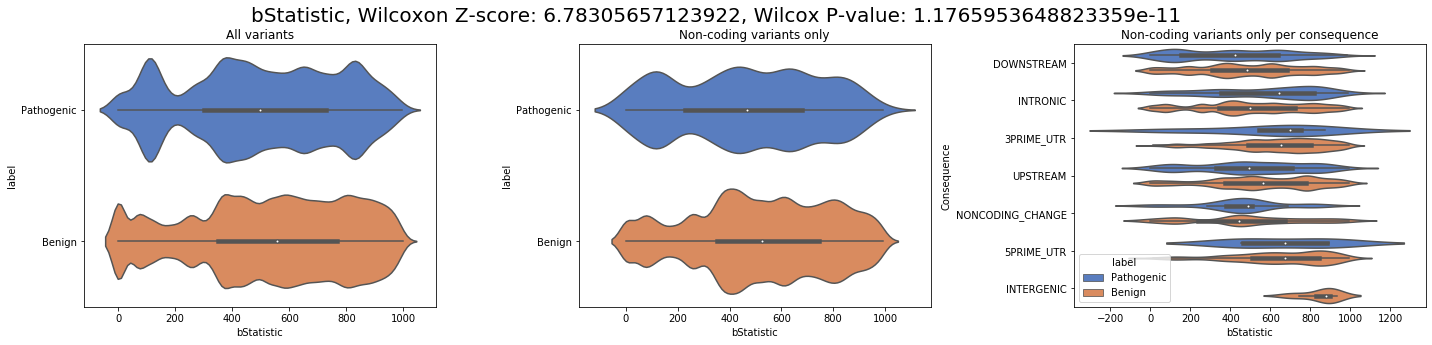

['Sngl1000bp', -5.381107966263383, 7.402877561082095e-08]


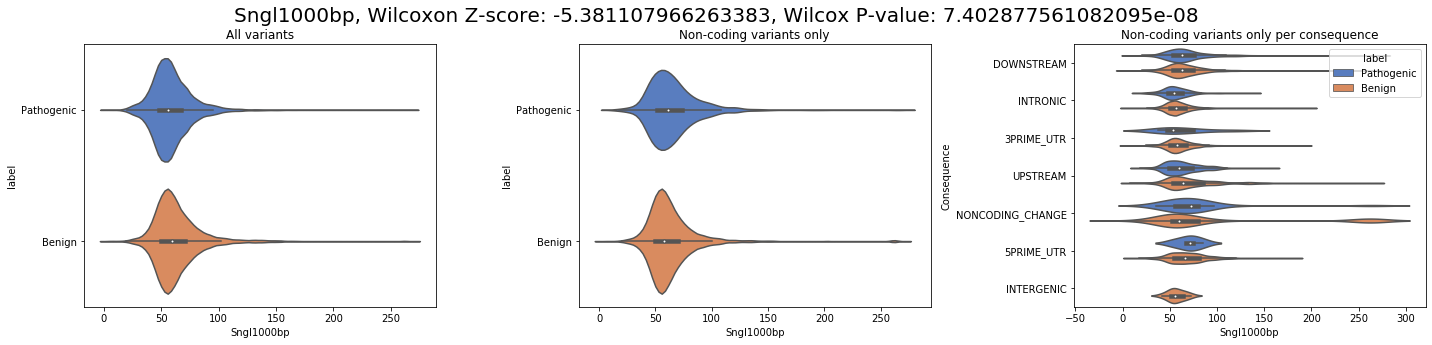

['cHmmTssBiv', -4.581655671768517, 4.6130901247998135e-06]


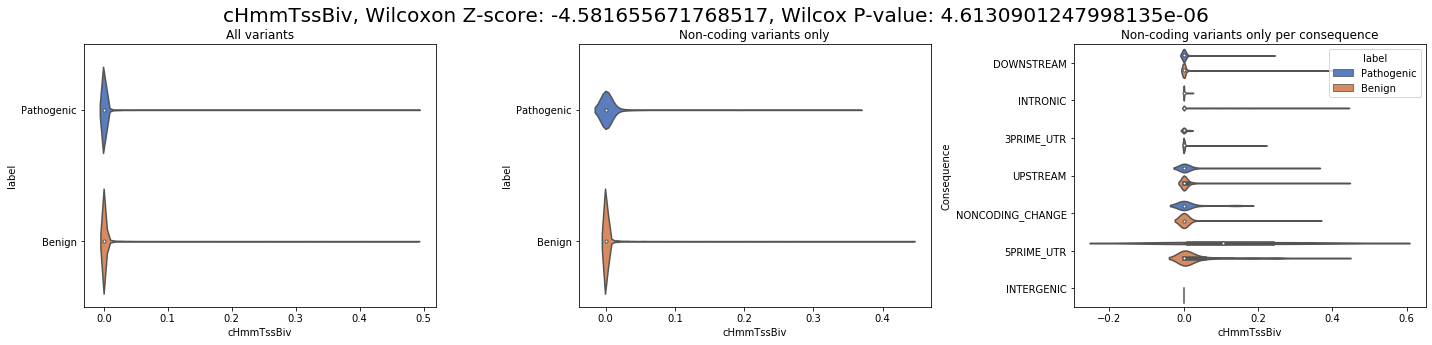

['cHmmEnhG', -4.365001196486881, 1.2712206274786348e-05]


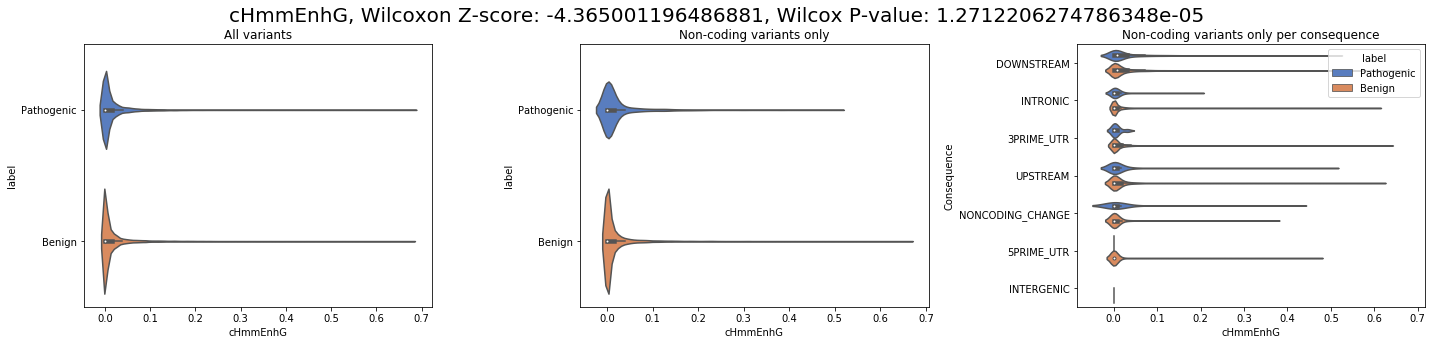

['cHmmReprPC', 4.137203882168415, 3.5156370931683915e-05]


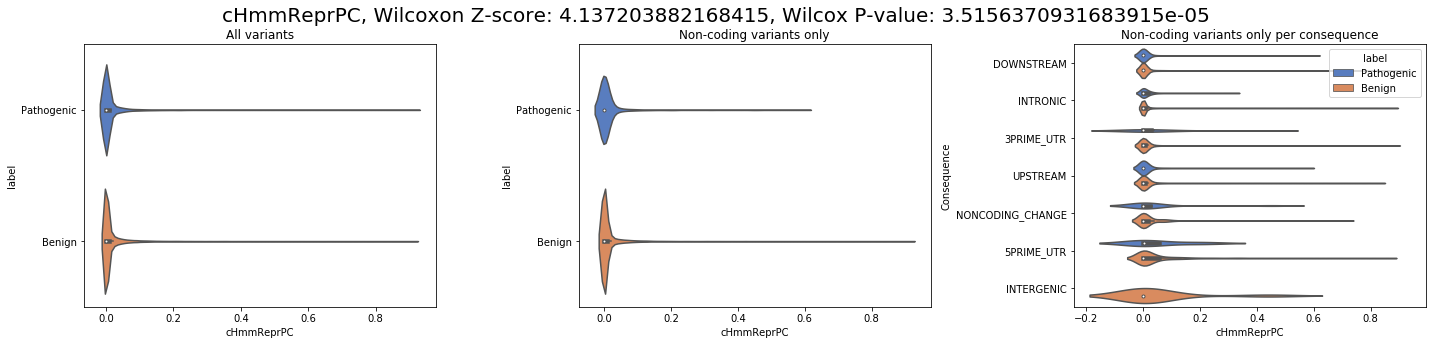

['Rare1000bp', 3.648601166330565, 0.00026367207155681316]


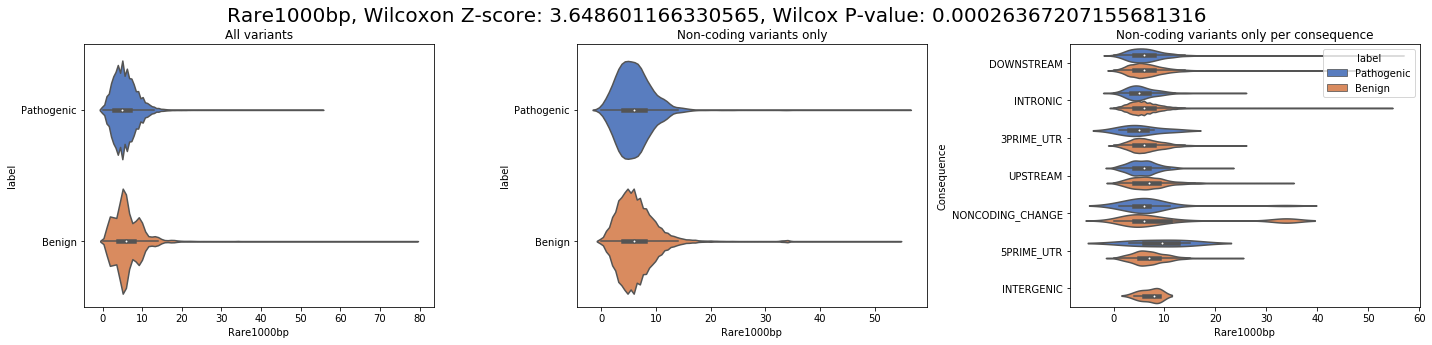

['Rare10000bp', 3.4145393499305996, 0.0006388996408080049]


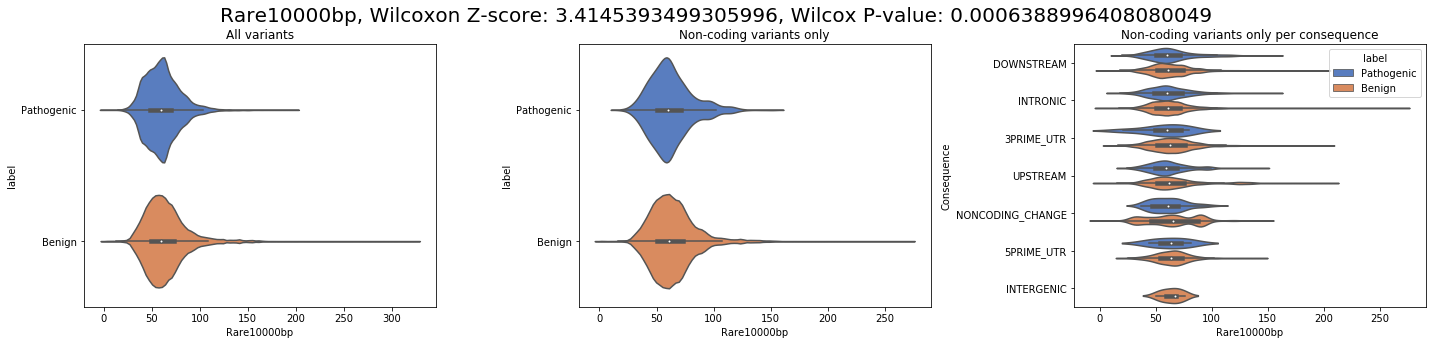

['EncNucleo', -3.3553918045330753, 0.0007925265100590307]


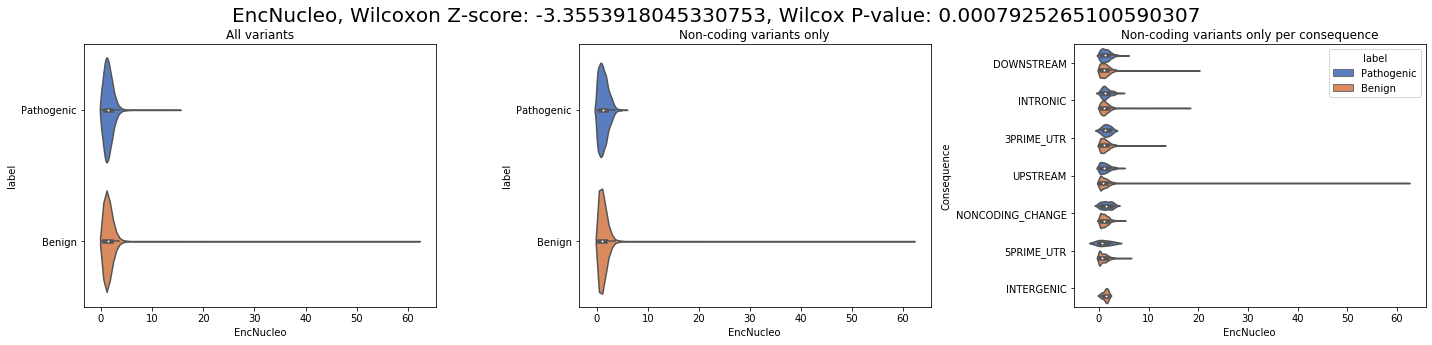

['Sngl100bp', -3.0295783925349205, 0.002448953393499743]


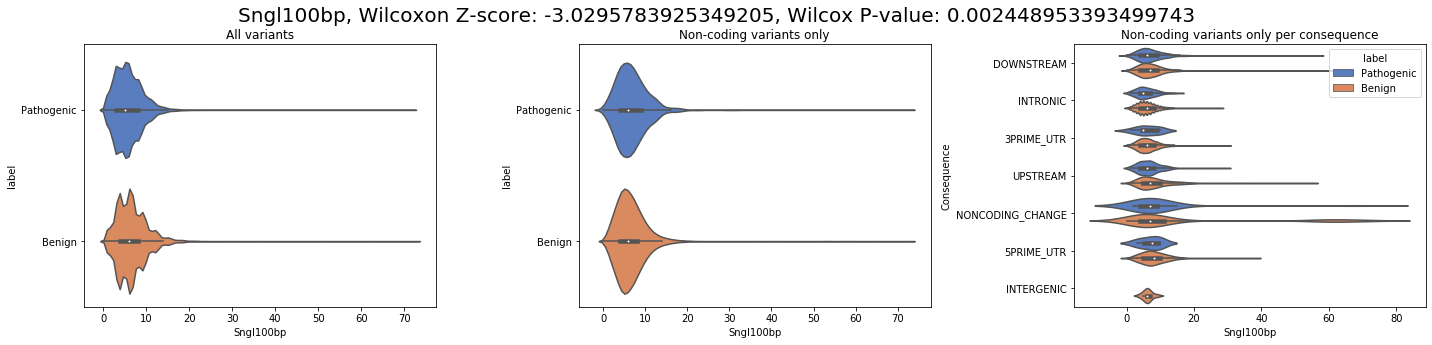

['cHmmHet', 3.019079698405416, 0.0025354382330266523]


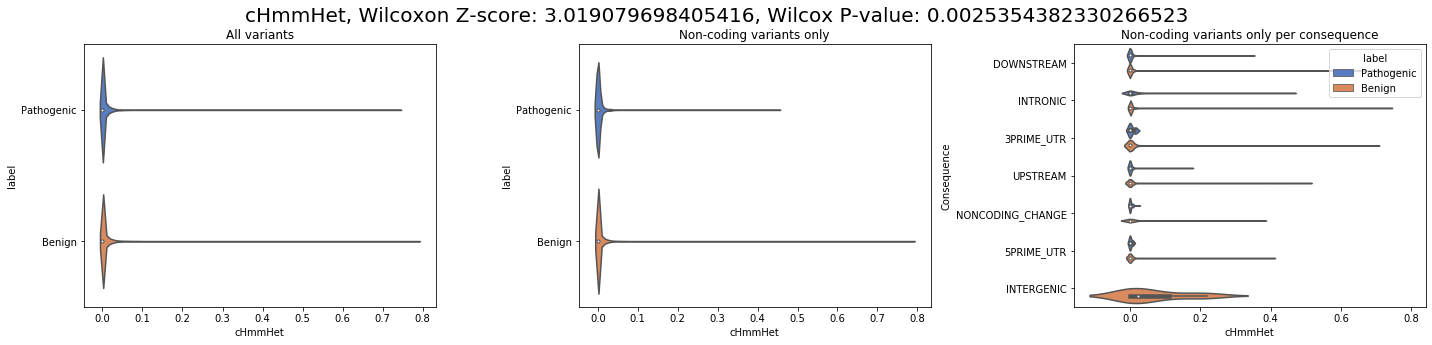

['cHmmTx', -2.103020300630881, 0.03546399496221854]


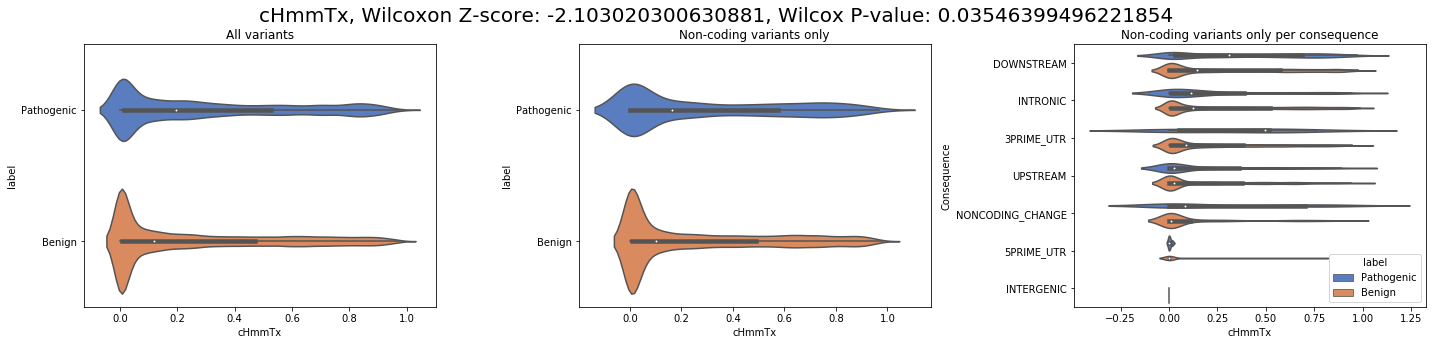

['Dist2Mutation', -1.6863829388441884, 0.0917220654256603]


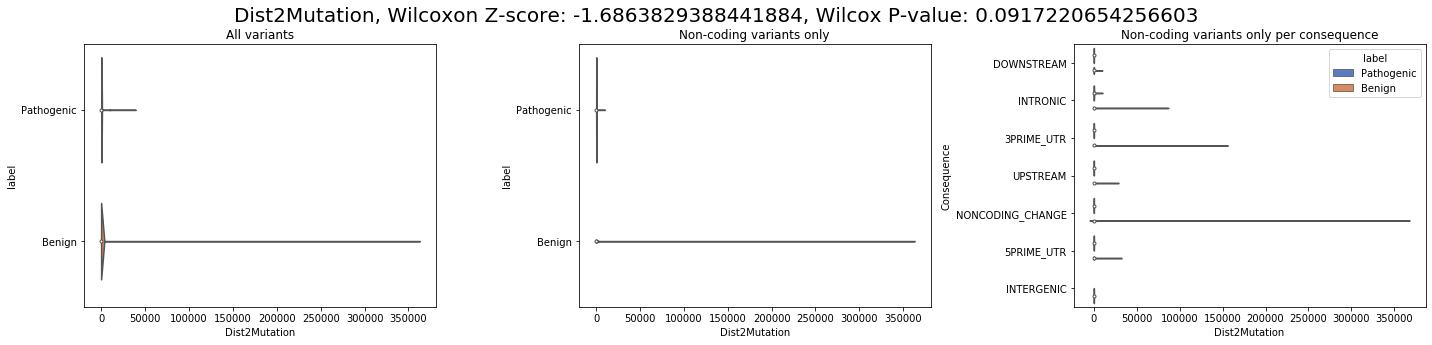

['cHmmBivFlnk', -1.6812370117514581, 0.09271688708154764]


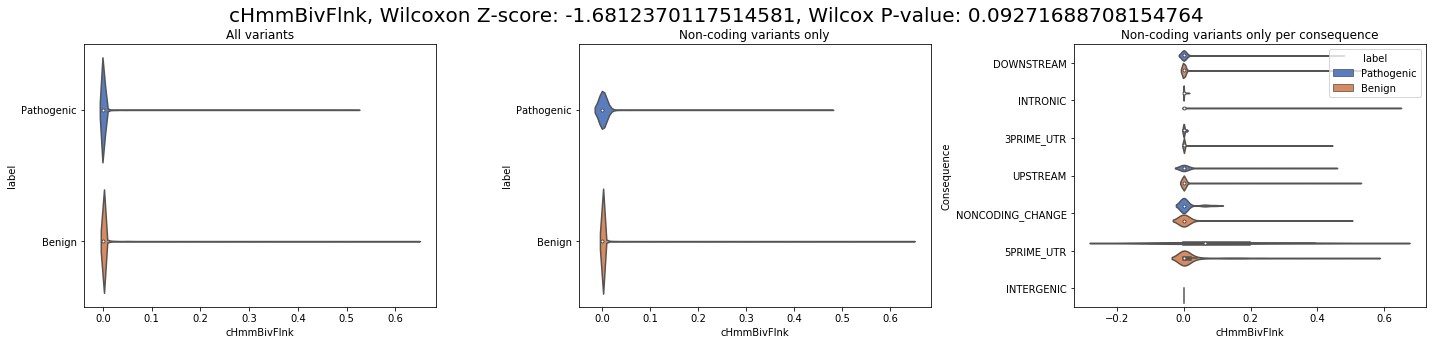

['cHmmEnh', -1.4891053645210215, 0.13645962539855097]


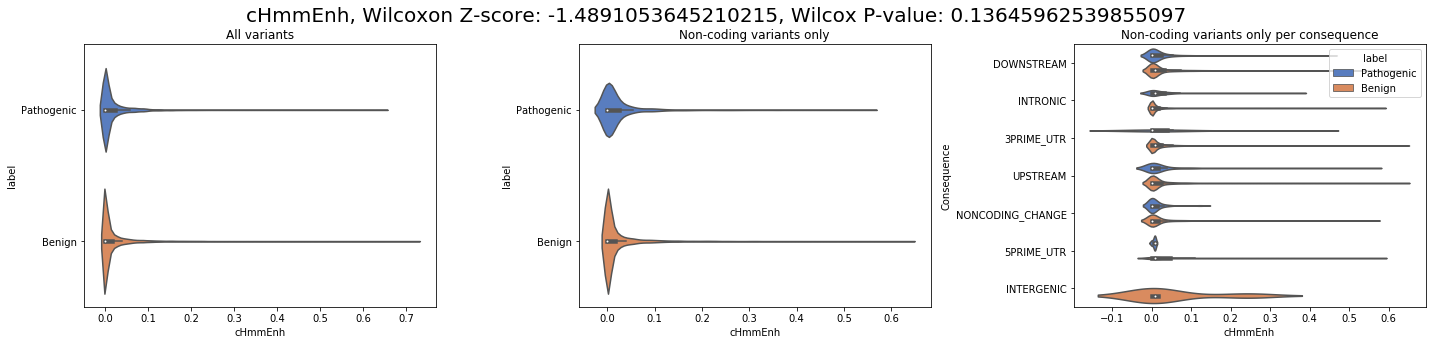

['cHmmEnhBiv', -1.1489954070198556, 0.25055787456372347]


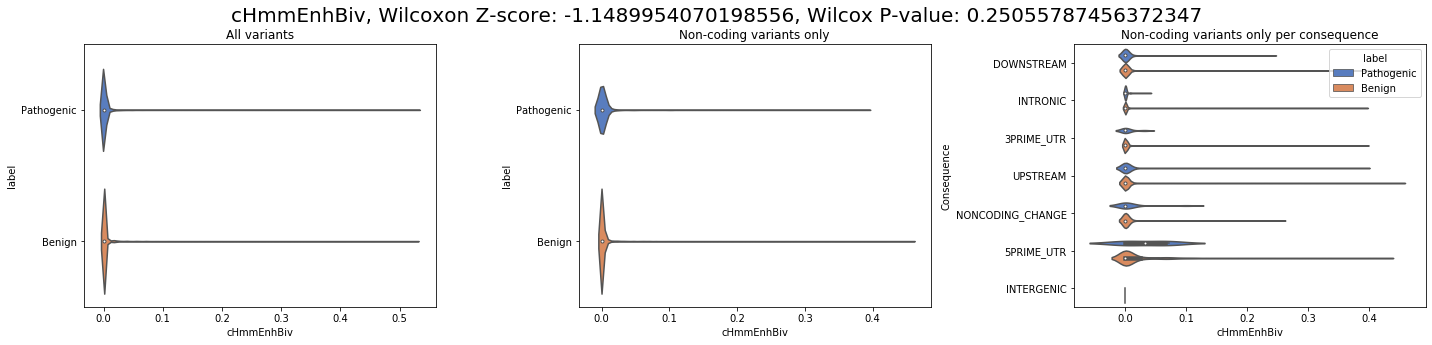

['cHmmTxWk', -0.6076195767872904, 0.5434398137035927]


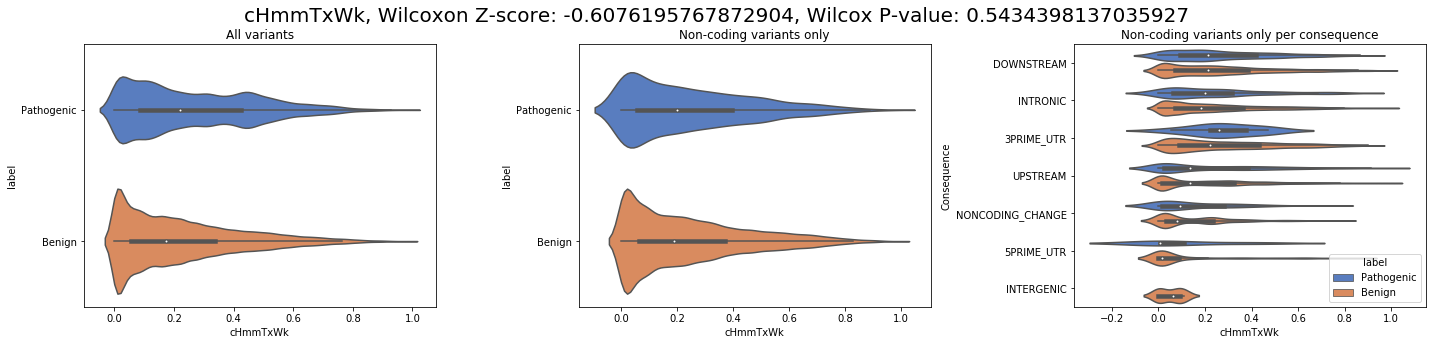

['Length', 0.5121646301163697, 0.6085357950518676]


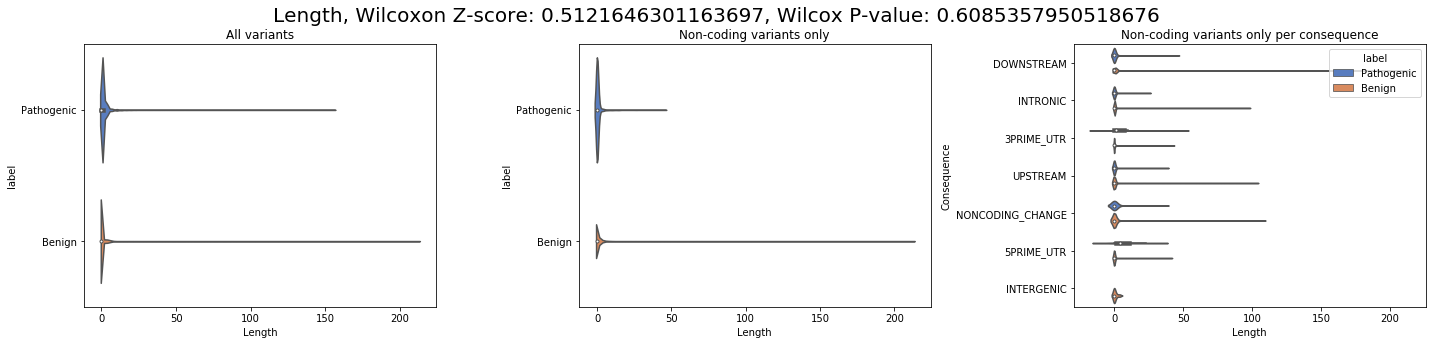

['cHmmZnfRpts', -0.4566191854693174, 0.6479447868307732]


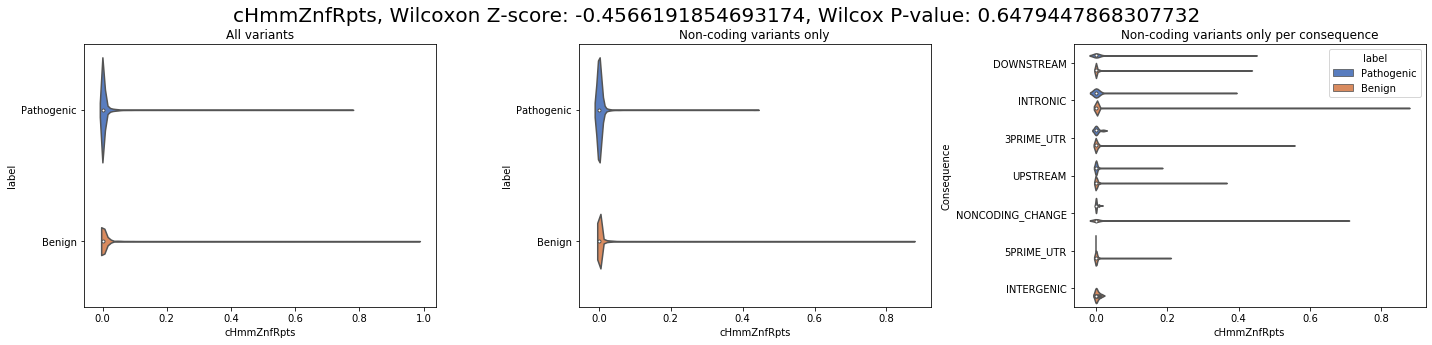

In [43]:
#perform Wilcoxon test for each feature between the benign and pathogenic variants so the plots can be sorted on importance.
l = []
for feature in numerical_features:
    w = scipy.stats.ranksums(x=nc.loc[nc['label'] == 'Benign'][feature].tolist(), y=nc.loc[nc['label'] == 'Pathogenic'][feature].tolist())
    l.append([feature, w[0], w[1]])

l = sorted(l, key=lambda x: abs(x[1]), reverse=True)

for feature in l:
    print(feature)
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))
    sns.violinplot(x=feature[0], y="label", data=data, palette="muted", ax=ax0)
    sns.violinplot(x=feature[0], y="label", data=nc, palette="muted", ax=ax1)
    sns.violinplot(x=feature[0], y="Consequence", hue="label", data=nc, palette="muted", ax=ax2)
    #sns.violinplot(x=feature[0], y="Type", hue="label", data=nc, palette="muted", ax=ax3)
    
    ax0.set_title('All variants')
    ax1.set_title('Non-coding variants only')
    ax2.set_title('Non-coding variants only per consequence')
    #ax3.set_title('Non-coding variants only per type')
    
    fig.tight_layout()
    fig.suptitle('{}, Wilcoxon Z-score: {}, Wilcox P-value: {}'.format(feature[0], feature[1], feature[2], 4), fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig('../figures/data_exploration/violinplots_nc/{}_{}.png'.format(abs(round(feature[1], 2)), feature[0]), bbox_inches='tight')
    plt.show()

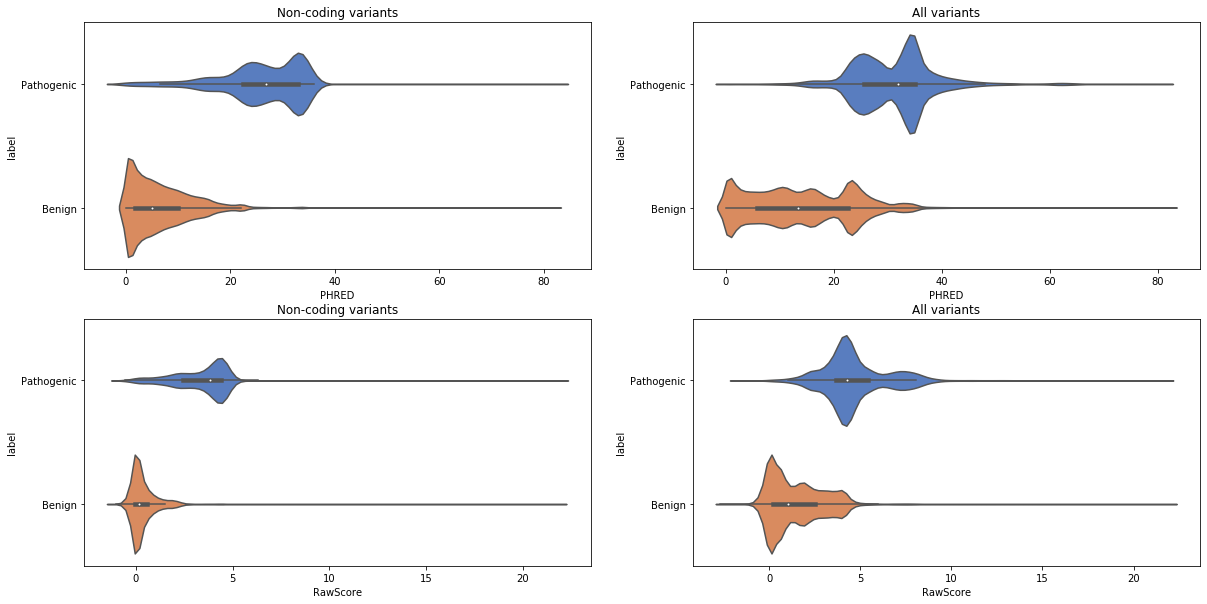

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.violinplot(x='PHRED', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='PHRED', y="label", data=data, palette="muted", ax=ax2)
sns.violinplot(x='RawScore', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='RawScore', y="label", data=data, palette="muted", ax=ax4)

ax1.set_title('Non-coding variants')
ax2.set_title('All variants')
ax3.set_title('Non-coding variants')
ax4.set_title('All variants')
plt.savefig('../figures/data_exploration/CADD_scores.png')

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.violinplot(x='PHRED', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='PHRED', y="label", data=data, palette="muted", ax=ax2)
sns.violinplot(x='RawScore', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='RawScore', y="label", data=data, palette="muted", ax=ax4)

ax1.set_title('Non-coding variants')
ax2.set_title('All variants')
ax3.set_title('Non-coding variants')
ax4.set_title('All variants')
plt.savefig('../figures/data_exploration/CADD_scores.png')

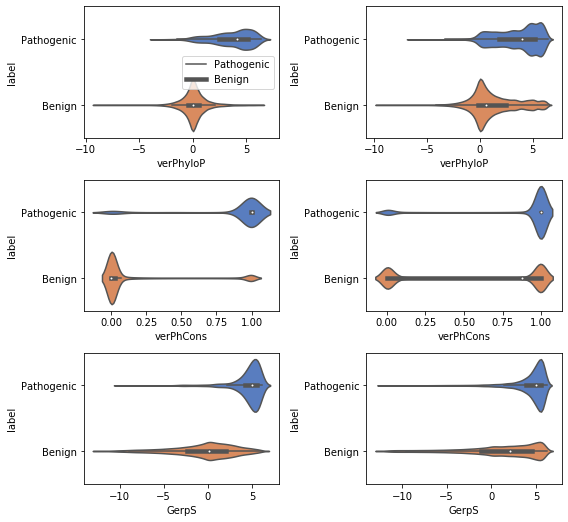

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.violinplot(x='verPhyloP', y="label", data=nc, palette="muted", ax=ax1)
sns.violinplot(x='verPhyloP', y="label", data=data, palette="muted", ax=ax2)

sns.violinplot(x='verPhCons', y="label", data=nc, palette="muted", ax=ax3)
sns.violinplot(x='verPhCons', y="label", data=data, palette="muted", ax=ax4)

sns.violinplot(x='GerpS', y="label", data=nc, palette="muted", ax=ax5)
sns.violinplot(x='GerpS', y="label", data=data, palette="muted", ax=ax6)

ax1.legend(['Pathogenic', 'Benign'], markerscale=3)

# ax1.set_title('Non-coding variants')
# ax2.set_title('All variants')
# ax3.set_title('Non-coding variants')
# ax4.set_title('All variants')
# ax5.set_title('Non-coding variants')
# ax6.set_title('All variants')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('../figures/data_exploration/thesis_design/violinplots.png')

Are the SNPs from Smedley2016 (453 SNPs) in our dataset?

In [10]:
smedley2016 = pd.read_csv('../files/ReMM/mmc2_combined.txt', sep='\t')

In [11]:
smedley2016['Chrom'] = smedley2016['Chr'].apply(lambda x: x[3:])
smedley2016.head()

Chr   Position Ref Alt        OMIM   Gene      PMID Mutation_type  \
0  chr1   21890663   G   A  MIM 241500   ALPL  10679946      enhancer   
1  chr1  209989478   C  CA  MIM 119300   IRF6  24442519      enhancer   
2  chr2  219524871   A   G  MIM 124000  BCS1L  19389488      enhancer   
3  chr7  156061506   C   T  MIM 142945    SHH  18836447      enhancer   
4  chr7  156583831   T   C  MIM 174500    SHH  17152067      enhancer   

  Annotations Chrom  
0         NaN     1  
1         NaN     1  
2         NaN     2  
3         NaN     7  
4         NaN     7

In [12]:
snp_intersection = pd.merge(train, smedley2016,  how='inner', left_on=['#Chrom','Pos', 'Alt'], right_on = ['Chrom','Position', 'Alt'])

In [13]:
snp_intersection.shape

(32, 161)

In [14]:
snp_intersection[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'PMID', 'source', 'CCDS', 'ConsDetail', 'Mutation_type', 'AnnoType', 'Consequence', 'Gene', 'sample_weight']]

label #Chrom        Pos Alt Ref_x Ref_y      PMID   source  \
0   Pathogenic     19   49468602   A   AAC   AAC  12730114     vkgl   
1   Pathogenic      1  228337561   G     A     A  20695017  clinvar   
2   Pathogenic     11   46761055   A     G     G   8916933  clinvar   
3   Pathogenic      9  130616761   A     G     G  22192717  clinvar   
4   Pathogenic     11   47470726   C     T     T  12651869  clinvar   
5   Pathogenic      2  122288485   A     G     G  21474760  clinvar   
6   Pathogenic      2  122288503   A     G     G  26522830  clinvar   
7   Pathogenic      9   35657773   C     T     T  16244706  clinvar   
8   Pathogenic      9   35657952   A     G     G  16244706  clinvar   
9   Pathogenic      9   35657945   C     T     T  11207361  clinvar   
10  Pathogenic     19   11200086   G     C     C  17625505  clinvar   
11  Pathogenic     19   11200086   C    CT    CT  14616764  clinvar   
12  Pathogenic     11    5246715   C     T     T   1374896  clinvar   
13  Pathogenic     11    5246717   C     T     T   1856830  clinvar   
14  Pathogenic     11    5248280   T     C     C   1536956  clinvar   
15  Pathogenic     16     223690   T   TAA   TAA  26193977  clinvar   
16  Pathogenic     16     223693   G     A     A  11480787  clinvar   
17  Pathogenic     16     223691   G     A     A   1581238  clinvar   
18  Pathogenic     11    5246718   G     A     A   4018033  clinvar   
19  Pathogenic     19   11200073   T     C     C  10484771  clinvar   
20      Benign      5  176836585   G     C     C  18832903  clinvar   
21      Benign      8   19796671   G     T     T   9017514  clinvar   
22      Benign      X  103031893   T     C     C   8723686  clinvar   
23      Benign      5  176836590   A     G     G  18832903  clinvar   
24      Benign     12   15130918   C     G     G  15629837  clinvar   
25      Benign      2   71913729   A     T     T  16705711  clinvar   
26      Benign      6  118869423   C     A     A  18241046  clinvar   
27      Benign      X  153991099   G     C     C  11379875  unknown   
28      Benign      9  130616643   T     C     C  22192717  unknown   
29      Benign      2  122288501   A     G     G  25735804  clinvar   
30      Benign      1   91382343   C     G     G  21695231  unknown   
31      Benign      3  169482592   T     C     C  25346280  unknown   

           CCDS       ConsDetail Mutation_type             AnnoType  \
0   CCDS12744.1       downstream          5UTR           Intergenic   
1   CCDS55689.1       downstream      promotor           Intergenic   
2   CCDS31477.1       downstream          3UTR           Intergenic   
3           NaN       regulatory          5UTR    RegulatoryFeature   
4           NaN       regulatory          5UTR    RegulatoryFeature   
5           NaN  non_coding_exon      RNA_gene  NonCodingTranscript   
6           NaN  non_coding_exon      RNA_gene  NonCodingTranscript   
7    CCDS6584.2       downstream      RNA_gene           Intergenic   
8    CCDS6584.2       downstream      RNA_gene           Intergenic   
9    CCDS6584.2       downstream      enhancer           Intergenic   
10          NaN       regulatory          5UTR    RegulatoryFeature   
11          NaN       regulatory          5UTR    RegulatoryFeature   
12          NaN         upstream          3UTR           Intergenic   
13          NaN         upstream          3UTR           Intergenic   
14          NaN         upstream          5UTR           Intergenic   
15          NaN       downstream          3UTR           Intergenic   
16          NaN       downstream          3UTR           Intergenic   
17          NaN       downstream          3UTR           Intergenic   
18          NaN         upstream          3UTR           Intergenic   
19          NaN       regulatory      promotor    RegulatoryFeature   
20  CCDS34302.1         upstream      promotor           Intergenic   
21   CCDS6012.1      5_prime_UTR          5UTR           Transcript   
22  CCDS14513.1      5_prime_UTR

In [206]:
#consequence == noncoding_change, upstream, downstream, intergenic, intronic, 5'utr, 3'utr
vgkl
#try out more annotations tools
#annovar, snpf, vep
# 
#percentage pathogenic
c = snp_intersection['label'].value_counts()
print('Percentage pathogenic:', round(float(c['Pathogenic']) / (float(c['Pathogenic']) + float(c['Benign'])) * 100, 2))

Percentage pathogenic: 62.5


In [15]:
snp_intersection_test = pd.merge(test, smedley2016,  how='inner', left_on=['#Chrom','Pos', 'Alt'], right_on = ['Chrom','Position', 'Alt'])
snp_intersection_test.shape

(4, 160)

In [16]:
snp_intersection_test[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'CCDS', 'ConsDetail', 'source', 'Mutation_type', 'AnnoType', 'Consequence']]

label #Chrom        Pos Alt Ref_x Ref_y         CCDS       ConsDetail  \
0  Pathogenic     19   11200089   T     C     C          NaN       regulatory   
1  Pathogenic      5  149340544   C     T     T          NaN       regulatory   
2  Pathogenic      9   21974860   A     C     C  CCDS56565.1      5_prime_UTR   
3  Pathogenic      2  122288468   T     C     C          NaN  non_coding_exon   

    source Mutation_type             AnnoType       Consequence  
0  clinvar      promotor    RegulatoryFeature        REGULATORY  
1  clinvar          5UTR    RegulatoryFeature        REGULATORY  
2  clinvar          5UTR           Transcript        5PRIME_UTR  
3  clinvar      RNA_gene  NonCodingTranscript  NONCODING_CHANGE

In [17]:
snp_intersection[['label', '#Chrom', 'Pos','Alt', 'Ref_x', 'Ref_y', 'PMID', 'source', 'CCDS', 'ConsDetail', 'Mutation_type', 'AnnoType', 'Consequence', 'Gene']][snp_intersection['PMID'] == 18241046]

label #Chrom        Pos Alt Ref_x Ref_y      PMID   source        CCDS  \
26  Benign      6  118869423   C     A     A  18241046  clinvar  CCDS5120.1   

   ConsDetail Mutation_type    AnnoType Consequence Gene  
26   upstream      promotor  Intergenic    UPSTREAM  PLN

In [236]:
for x in train.columns:
    if 'phylo' in x.lower():
        print(x)

mamPhyloP
priPhyloP
verPhyloP


<h1>Subsetting the data on non-coding variants</h1>

#consequence == noncoding_change, upstream, downstream, intergenic, intronic, 5'utr, 3'utr
vgkl
#try out more annotations tools
#annovar, snpf, vep
# 
#percentage pathogenic
Todo:
    - Separate noncoding SNPs
    - Plot benigh/pathogenic per feature. 
    - PCA/tSNE on numeric variables, colour on features
    - Correlation matrix for coding and non-coding (only CADD features?)

In [14]:
train.Consequence.value_counts()

NON_SYNONYMOUS      128064
SYNONYMOUS           67625
INTRONIC             44145
FRAME_SHIFT          17306
DOWNSTREAM           16284
STOP_GAINED          12788
SPLICE_SITE          11730
UPSTREAM              9335
3PRIME_UTR            8717
REGULATORY            6657
CANONICAL_SPLICE      5813
INFRAME               3399
5PRIME_UTR            1372
NONCODING_CHANGE      1278
STOP_LOST               75
INTERGENIC               9
UNKNOWN                  3
Name: Consequence, dtype: int64

To generate the noncoding subset, only keep variants where 'Consequence' points to non-coding (see list nc_consq_values below)

In [182]:
print(features_model_categorical)
for f in features_model_categorical:
    if f in nc.columns:
        print('FEATURE:', f, '\n', nc[f].value_counts())
        print('\n')

{'PolyPhenCat', 'Ref', 'Alt', 'Type', 'SIFTcat', 'Domain', 'Segway', 'nAA', 'Dst2SplType', 'oAA'}
FEATURE: Ref 
 C                                                                                                            21855
G                                                                                                            21757
A                                                                                                            15804
T                                                                                                            15285
CT                                                                                                             353
                                                                                                             ...  
GAGCGCGGTGGCGCGG                                                                                                 1
TCTGGGGACCAGAGGGCCAGAAAGCTCAAAGCCTATGTTCCCCCTGCCCCTGCATGGCCCTCCCTCCCACCAACTCATCTCT

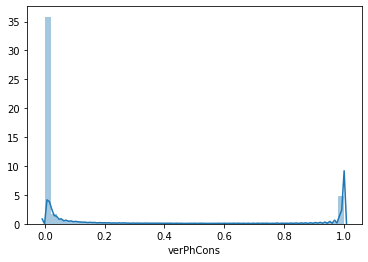

In [73]:
sns.distplot(nc['verPhCons'].dropna())

KeyError: 'PolyPhenCat'

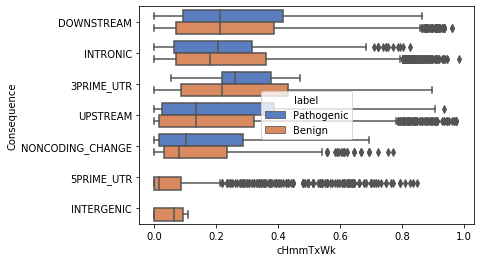

Check the first 10 PC's with tSNE.

<h1>How well does the current model predict for non-coding variants?</h1>

In [ ]:
#load test results -> subset on noncoding variants -> calculate ROC